In [2]:
import numpy as np
import nlopt
import pandas as pd
from math import log, exp
from multiprocessing import Pool, cpu_count
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
fileIn = "all_chr_2000_discrete_genome_gc.tsv"


In [4]:
def rho(rbp,g,L,d):
    r = rbp*(d+2*(g/rbp)*L*(1 - exp(-d/L)))
    return(r)

In [5]:
def single_dist_obj_fun(r,x):
    d,h0,h1,h2,th = x
    r = r*(d)
    calcH0 =(18+13*r + r**2 + 36*th + 22*th**2 + 4*th**3 + r*(6*th+th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH2 = (th**2*(36+14*r+r**2+36*th+6*th*r+8*th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH1 = 1 - calcH0 - calcH2
    
    val = h0*log(calcH0) + h1*log(calcH1)+h2*log(calcH2)
    return(val)

In [6]:
def single_dist_multi_ind_obj_fun(r,xl):
    res = [ single_dist_obj_fun(r,xs) for xs in xl]
    res = sum(res)
    return(res)

In [7]:
def find_max_like_single_dist(args):
    d, testChr = args
    opt = nlopt.opt(nlopt.LN_NELDERMEAD,1)
    opt.set_lower_bounds([0.0001])
    opt.set_upper_bounds([0.1])
    startPoint = [0.001]
    opt.set_max_objective(lambda x, grad: single_dist_obj_fun(x,testChr))
    res = opt.optimize(startPoint)
    return(res[0])

In [8]:
def calc_single_dist(x,rbp,g,L):
    d,h0,h1,h2,th = x
    
    r = rbp*(d+2*(g/rbp)*L*(1 - exp(-d/L)))
    
    calcH0 =(18+13*r + r**2 + 36*th + 22*th**2 + 4*th**3 + r*(6*th+th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH2 = (th**2*(36+14*r+r**2+36*th+6*th*r+8*th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH1 = 1 - calcH0 - calcH2
    
    val = h0*log(calcH0) + h1*log(calcH1)+h2*log(calcH2)
    return(val)

In [9]:
def single_chr_obj_fun(x_,arr):
    rbp, g, L = x_
    test = np.apply_along_axis(lambda x: calc_single_dist(x,rbp,g,L),1,arr)
    obfun = np.sum(test)
    #test = [calc_single_dist(x,rbp,g,L) for x in arr]
    #obfun = sum(test)
    return(obfun)

In [10]:
def across_chr_obj_fun(x,dfArrList,numChrs):
    
    rList = x[0:numChrs]
    gList = x[numChrs:numChrs+numChrs]
    L = x[-1]
    
    obFun = sum([single_chr_obj_fun([rs,gs,L],arr) for (rs,gs,arr) in list(zip(rList,gList,dfArrList))])
    
    return(obFun)

In [11]:
def find_max_like_single_ind(rep):
    
    numberChromsomes = 19
    dfListAuto = [ df.loc[(df['chromosome']== x) & (df['replicate']==rep) & (df['sample']==1) & (df['Unnamed: 0']<=10)] for x in list(range(1,numberChromsomes+1))]
    dfListAuto = [x.iloc[:,[0,4,5,6,11]].to_numpy() for x in dfListAuto]

    lowerBounds = [0.0001 for x in range(numberChromsomes)]+ [0.0001 for x in range(numberChromsomes)]+[10]
    upperBounds = [0.1 for x in range(numberChromsomes)]+[0.1 for x in range(numberChromsomes)]+[2000]
    startPoints = [0.001 for x in range(numberChromsomes)]+[0.001 for x in range(numberChromsomes)]+[50]


    opt=nlopt.opt(nlopt.LN_NELDERMEAD,numberChromsomes+numberChromsomes+1)

    opt.set_lower_bounds(lowerBounds)
    opt.set_upper_bounds(upperBounds)

    opt.set_max_objective(lambda x,grad: across_chr_obj_fun(x,dfListAuto,numberChromsomes))

    res = opt.optimize(startPoints)
    return(res)

In [12]:
def combine_across_individuals(thisDF):
    test = thisDF
    numSamples = len(test['sample'].unique())
    test = test.groupby(['Unnamed: 0'],as_index=False).sum()
    test['H'] = test['H']/numSamples
    return(test.iloc[:,[0,4,5,6,11]].to_numpy())
    #return( test.iloc[:,[0,4,5,6,11]].to_numpy() )

In [13]:
def find_max_like_group_ind(rep):
    
    numberChromsomes = 19
    dfListAuto = [ df.loc[(df['chromosome']== x) & (df['replicate']==rep) & (df['Unnamed: 0']<=10)] for x in list(range(1,numberChromsomes+1))]
    dfListAuto = [combine_across_individuals(x) for x in dfListAuto]

    lowerBounds = [0.0001 for x in range(numberChromsomes)]+ [0.0001 for x in range(numberChromsomes)]+[10]
    upperBounds = [0.1 for x in range(numberChromsomes)]+[0.1 for x in range(numberChromsomes)]+[2000]
    startPoints = [0.001 for x in range(numberChromsomes)]+[0.001 for x in range(numberChromsomes)]+[50]


    opt=nlopt.opt(nlopt.LN_NELDERMEAD,numberChromsomes+numberChromsomes+1)

    opt.set_lower_bounds(lowerBounds)
    opt.set_upper_bounds(upperBounds)

    opt.set_max_objective(lambda x,grad: across_chr_obj_fun(x,dfListAuto,numberChromsomes))

    res = opt.optimize(startPoints)
    return(res)

In [14]:
def combine_across_individuals_and_replicates(thisDF):
    test = thisDF
    numSamples = len(test['sample'].unique())
    numReplicates = len(test['replicate'].unique())
    test = test.groupby(['Unnamed: 0'],as_index=False).sum()
    test['H'] = test['H']/(numSamples*numReplicates)
    return(test.iloc[:,[0,4,5,6,11]].to_numpy())
    #return( test.iloc[:,[0,4,5,6,11]].to_numpy() )

In [15]:
df = pd.read_csv(fileIn,delimiter='\t')
df = df.loc[ df['chromosome'] != 'X']
df = df.astype({'chromosome':'int64'})

In [16]:
df

,Unnamed: 0,sample,replicate,chromosome,h_0,h_1,h_2,total,h_0_frac,h_1_frac,h_2_frac,H
0,1,1,1,10,52300306,733406,4946,53038658,0.986079,0.013828,0.000093,0.007007
1,2,1,1,10,52300285,733446,4926,53038657,0.986079,0.013829,0.000093,0.007007
2,3,1,1,10,52300265,733484,4907,53038656,0.986078,0.013829,0.000093,0.007007
3,4,1,1,10,52300472,733069,5114,53038655,0.986082,0.013821,0.000096,0.007007
4,5,1,1,10,52300384,733243,5027,53038654,0.986081,0.013825,0.000095,0.007007
...,...,...,...,...,...,...,...,...,...,...,...,...
37999995,1996,10,100,9,45941047,642166,2865,46586078,0.986154,0.013785,0.000061,0.006954
37999996,1997,10,100,9,45940956,642346,2775,46586077,0.986152,0.013788,0.000060,0.006954
37999997,1998,10,100,9,45940797,642662,2617,46586076,0.986149,0.013795,0.000056,0.006954
37999998,1999,10,100,9,45940891,642472,2712,46586075,0.986151,0.013791,0.000058,0.006954


In [261]:
#single_dist_obj_fun(0.0014,testChr[400])
#calc_single_dist(testChr[400],0.0014,0,0)

/home/derek/anaconda3/envs/simulation/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


-4732721.749829463

Here obtaining a single estimate compositing over all distances with data pooled across individuals and replicates for chromosome 19 data only

because of discrete genome, we need to limit to a minimum distance for estimation, where double-mutation events are WAY less likely than recombination events, which confound results for short distance. 

The minimum distnce d is chosen so that (rho)(d) >> theta, i.e. d >> theta/rho. Here theta/rho ~= 5, so chosen d>= 50 as minimum distance.  This is in concordance with the single-distance estimates converging to the model expectation around that distance

In [39]:
testPooled = df.loc[(df['chromosome']==19) & (df['replicate']<= 100) & (df['Unnamed: 0']<=2000) & (df['Unnamed: 0']>= 300)] 
testPooled = combine_across_individuals_and_replicates(testPooled)

In [40]:

lowerBounds = [ 0.0001, 0.0001,10]
upperBounds = [ 0.1, 0.1, 2000]
startPoints = [ 0.001, 0.001, 50]

opt=nlopt.opt(nlopt.LN_NELDERMEAD,3)

opt.set_lower_bounds(lowerBounds)
opt.set_upper_bounds(upperBounds)
opt.set_max_objective(lambda x,grad: single_chr_obj_fun(x,testPooled))
res = opt.optimize(startPoints)

print([x for x in res])

[0.0014634442728587087, 0.0038046911612805495, 193.40884940300901]


In [17]:
def test_min_dist_effect(minDist):
    testPooled = df.loc[(df['chromosome']==19) & (df['replicate']<= 100) & (df['Unnamed: 0']<=1000) & (df['Unnamed: 0']>= minDist)] 
    testPooled = combine_across_individuals_and_replicates(testPooled)
    
    lowerBounds = [ 0.0001, 0.0001,10]
    upperBounds = [ 0.1, 0.1, 2000]
    startPoints = [ 0.001, 0.001, 50]

    opt=nlopt.opt(nlopt.LN_NELDERMEAD,3)

    opt.set_lower_bounds(lowerBounds)
    opt.set_upper_bounds(upperBounds)
    opt.set_max_objective(lambda x,grad: single_chr_obj_fun(x,testPooled))
    res = opt.optimize(startPoints)
    return([x for x in res])

In [17]:
estimateByMinDist = [test_min_dist_effect(x) for x in list(range(1,100,10))]

In [18]:
np.transpose(np.asarray(estimateByMinDist))

array([[1.47997366e-03, 1.47888447e-03, 1.47704747e-03, 1.47479437e-03,
        1.47282250e-03, 1.47134983e-03, 1.46966073e-03, 1.46877987e-03,
        1.46798144e-03, 1.46683904e-03],
       [3.89908822e-03, 3.89355854e-03, 3.88422181e-03, 3.87257976e-03,
        3.86206355e-03, 3.85412455e-03, 3.84480378e-03, 3.83970542e-03,
        3.83500953e-03, 3.82806200e-03],
       [1.85763505e+02, 1.86220056e+02, 1.86993901e+02, 1.87957847e+02,
        1.88822683e+02, 1.89478600e+02, 1.90244068e+02, 1.90658011e+02,
        1.91037592e+02, 1.91595261e+02]])

In [34]:
testChr = 19
modelTruth = [rho(0.00144168,0.00356648,200,d+1)/(d+1) for d in list(range(0,2000))]
modelConstant = [ 0.00144168 for x in list(range(2000))]
modelEstimatedGloballyAsMedian = [rho(0.00164344,0.0038803,167.4,d+1)/(d+1) for d in list(range(0,2000))]
modelEstimatedChr19CombinedReps = [rho(0.00147997365514947,0.003899088222053838,185.76350529678086,d+1)/(d+1) for d in list(range(0,2000))]


In [18]:
jobs = list(range(1,1000,50))
with Pool(cpu_count()-2) as p:
    estimateByMinDist=p.map(test_min_dist_effect,jobs)
estimateByMinDist = np.transpose(np.asarray(estimateByMinDist))    

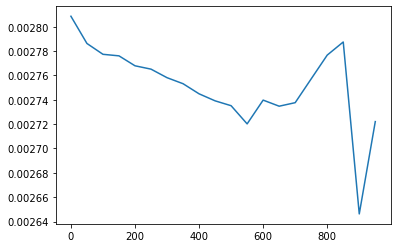

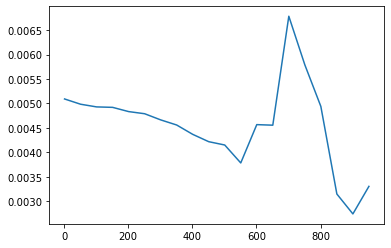

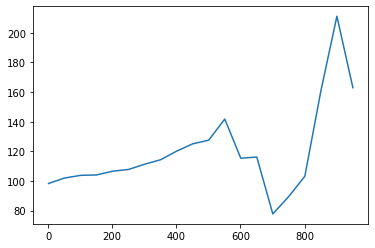

In [19]:
xvals = list(range(1,1000,50))
plt.plot(xvals,estimateByMinDist[0])
plt.show()
plt.plot(xvals,estimateByMinDist[1])
plt.show()
plt.plot(xvals,estimateByMinDist[2])
plt.show()

Here we are trying a single iteration

In [35]:
testChr =  df.loc[(df['chromosome']== 19) & (df['replicate']==1) & (df['sample']==5)& (df['Unnamed: 0']<=500)] 
testChr = testChr.iloc[:,[0,4,5,6,11]].to_numpy()

In [36]:
jobs = [[x+1,testChr[x]] for x in list(range(0,500))]
with Pool(cpu_count()) as p:
    thisResOneInd = p.map(find_max_like_single_dist,jobs)

/home/derek/anaconda3/envs/simulation/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


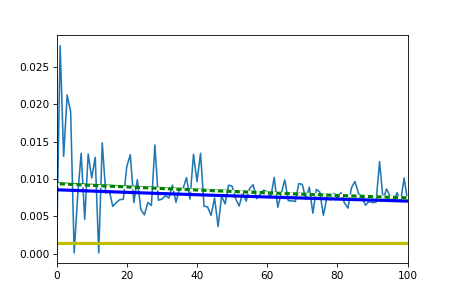

In [70]:
plt.plot(thisResOneInd)
plt.plot(modelTruth,"b",linewidth=3)
plt.plot(modelConstant,"y",linewidth=3)
plt.plot(modelEstimatedGloballyAsMedian,"g",linewidth=3)
plt.plot(modelEstimatedChr19CombinedReps,"w:",linewidth=3)
plt.xlim([0,100])
plt.show()

Here combining across individuals to get an estimate of Rho/d (r/bp) for each distance  

In [48]:
testPooled = df.loc[(df['chromosome']==19) & (df['replicate']<= 100) & (df['Unnamed: 0']<=2000)] 
testPooled = combine_across_individuals_and_replicates(testPooled)

In [49]:
jobs = [[x+1,testPooled[x]] for x in list(range(500))]
with Pool(cpu_count()) as p:
    thisRes = p.map(find_max_like_single_dist,jobs)

<IPython.core.display.Javascript object>


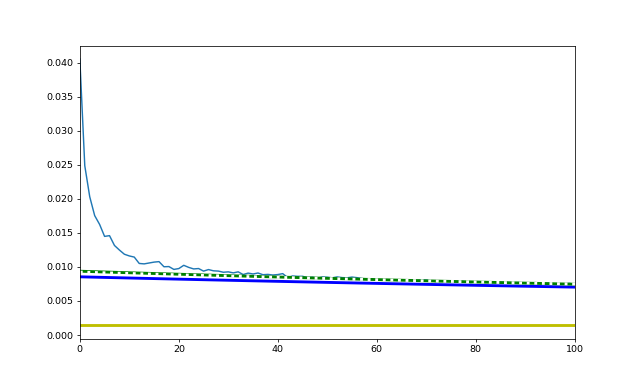

In [53]:
plt.plot(thisRes)
plt.plot(modelTruth,"b",linewidth=3)
plt.plot(modelConstant,"y",linewidth=3)
plt.plot(modelEstimatedGloballyAsMedian,"g",linewidth=3)
plt.plot(modelEstimatedChr19CombinedReps,"w:",linewidth=3)
plt.xlim([0,100])
plt.show()

# plotting the effect of minimum distance on estimates for all autosomes. Individuals are pooled.  Here, all replicates are also pooled


In [20]:
autosomeNames = list(range(1,20,1))
autosomeNames

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [21]:
def calc_min_dist_effect_V2(argv):
    cName,minDist = argv
    testPooled = df.loc[(df['chromosome']==cName) & (df['Unnamed: 0'] <= 1000) &(df['Unnamed: 0']>= minDist)] 
    testPooled = combine_across_individuals_and_replicates(testPooled)
    
    lowerBounds = [ 0.0001, 0.0001,10]
    upperBounds = [ 0.1, 0.1, 2000]
    startPoints = [ 0.001, 0.001, 50]

    opt=nlopt.opt(nlopt.LN_NELDERMEAD,3)

    opt.set_lower_bounds(lowerBounds)
    opt.set_upper_bounds(upperBounds)
    opt.set_max_objective(lambda x,grad: single_chr_obj_fun(x,testPooled))
    res = opt.optimize(startPoints)
    return([x for x in res])

In [22]:
def get_chr_min_dist_effect_V2(cName):
    jobs = list(range(1,1000,10))
    jobs = [(cName,x) for x in jobs]
    with Pool(6) as p:
        estimateByMinDist=p.map(calc_min_dist_effect_V2,jobs)
    estimateByMinDist = np.transpose(np.asarray(estimateByMinDist))
    return(estimateByMinDist)

In [23]:
resByChromosome = [ get_chr_min_dist_effect_V2(xs) for xs in autosomeNames]
print([np.ndarray.tolist(resByChromosome[i]) for i in list(range(len(resByChromosome)))])

[[[0.001513359440646626, 0.0015115471479138147, 0.0015086356399900487, 0.0015060323423433703, 0.0015034010865453736, 0.0015012144662653938, 0.0014996510674692024, 0.001497942014490893, 0.0014963872304089517, 0.0014955653196160475, 0.0014947383311900517, 0.0014941025344657826, 0.0014937005072708062, 0.0014936493998787758, 0.0014936344909510621, 0.0014934530868485104, 0.0014922246591209888, 0.0014924873112079342, 0.001493159307049012, 0.001493479755017351, 0.0014938439132798544, 0.001493405861415953, 0.001494024034318215, 0.001492702040991228, 0.0014929073388987523, 0.0014927212330064783, 0.0014926744393044034, 0.0014933016612942852, 0.0014941175303961843, 0.0014935916906850004, 0.0014938617501524631, 0.001493682206432137, 0.0014945959364275892, 0.001494799227790236, 0.001494987312527864, 0.0014952990033950545, 0.001495333208461127, 0.0014956103788607996, 0.0014955614999127452, 0.00149693239547285, 0.001497076448960735, 0.0014964958903498234, 0.001496329542337451, 0.0014982090071157818, 

In [ ]:
resByChromosomePooledReps = [[[0.001513359440646626, 0.0015115471479138147, 0.0015086356399900487, 0.0015060323423433703, 0.0015034010865453736, 0.0015012144662653938, 0.0014996510674692024, 0.001497942014490893, 0.0014963872304089517, 0.0014955653196160475, 0.0014947383311900517, 0.0014941025344657826, 0.0014937005072708062, 0.0014936493998787758, 0.0014936344909510621, 0.0014934530868485104, 0.0014922246591209888, 0.0014924873112079342, 0.001493159307049012, 0.001493479755017351, 0.0014938439132798544, 0.001493405861415953, 0.001494024034318215, 0.001492702040991228, 0.0014929073388987523, 0.0014927212330064783, 0.0014926744393044034, 0.0014933016612942852, 0.0014941175303961843, 0.0014935916906850004, 0.0014938617501524631, 0.001493682206432137, 0.0014945959364275892, 0.001494799227790236, 0.001494987312527864, 0.0014952990033950545, 0.001495333208461127, 0.0014956103788607996, 0.0014955614999127452, 0.00149693239547285, 0.001497076448960735, 0.0014964958903498234, 0.001496329542337451, 0.0014982090071157818, 0.0014977066035098767, 0.0014975725286043655, 0.0014991349596342215, 0.0014974859836430685, 0.0014982197123806747, 0.0014976276670243065, 0.001498205310686283, 0.0014992896420473372, 0.0014993242672203, 0.0014991980028429353, 0.0014995964336992121, 0.0014995903098115374, 0.0014996438034533379, 0.0014985040688774137, 0.001499476426557253, 0.001498845790242368, 0.001497934490224958, 0.0014954902280498665, 0.0014992672831526815, 0.0014995919030715052, 0.0014968577181777628, 0.0014999450063862573, 0.0015001223821370264, 0.0014982131761015704, 0.001496857050794562, 0.0014991638147589161, 0.0015019497460460702, 0.0015019291196455157, 0.0014960311699740475, 0.001501013053653784, 0.0014991313089767542, 0.001508548093745881, 0.0015063360140803415, 0.001502392580984854, 0.0015027186078054246, 0.001502338303152254, 0.0014999065731707757, 0.0014978229216806977, 0.0015039299053093938, 0.001501452832849076, 0.0015153667722253483, 0.0014995634567835357, 0.001514776195573617, 0.0014951992365077524, 0.0014712472175093401, 0.0014598244966536561, 0.0014549862059135693, 0.0014370328165341103, 0.0014707004955354292, 0.0014485118974064178, 0.0013920232605293065, 0.0014626749642376665, 0.001546215772762442, 0.001680977940536981, 0.0017915964084659305, 0.0017911905614193236], [0.0027767925490064824, 0.00276499162416905, 0.002745765915742997, 0.0027284761936858877, 0.002710380974798015, 0.0026947470548258, 0.0026833472975028986, 0.002670111488197001, 0.0026575841693375424, 0.0026508301563427216, 0.0026435688438655224, 0.002637731340338731, 0.0026339729307180435, 0.002633473247099046, 0.002633355006189513, 0.0026312056387834256, 0.0026163796267824743, 0.002619609486457616, 0.002628900758748446, 0.0026336970295318426, 0.0026391105574374934, 0.0026319644554220105, 0.0026430941594222596, 0.002618222541916102, 0.0026223619340564773, 0.0026187134231222186, 0.002618086772879279, 0.002632395788522625, 0.0026536855184417143, 0.0026384135611761906, 0.002646561267063186, 0.0026405790966030082, 0.002671800692879275, 0.002681106650110528, 0.0026867068980995076, 0.0027000414454747294, 0.0027026741762373324, 0.002716603829666603, 0.0027121207919649217, 0.002802151926265001, 0.0028105698720610438, 0.0027677166170391437, 0.002755288557162361, 0.0029426846767906046, 0.002880118289975516, 0.0028585101439497457, 0.0031424353181683374, 0.0028370953185005996, 0.002949708017738938, 0.002868592117662752, 0.0029770069260970497, 0.003469894253029886, 0.003358496895934208, 0.0034104861729475217, 0.003989914401059639, 0.0033544464969893, 0.003180818678426153, 0.003187894856942594, 0.0030318197201390246, 0.0029103558150430546, 0.0025694617174380147, 0.0025540133749526323, 0.0033756467795000066, 0.00345594183817374, 0.0027611351173519733, 0.0030732980138259815, 0.0026770842868373925, 0.0025556918571343003, 0.0026514422496290643, 0.0026692864118484714, 0.0030375669627762084, 0.0027590743711098254, 0.0019746360754854825, 0.002384116011431208, 0.002013848363483628, 0.002730729050628827, 0.0026798837062901393, 0.0027367512666529193, 0.002722871625039951, 0.0021957975079264797, 0.00211393071487546, 0.0020879867068846363, 0.001915159636504504, 0.002312674373173509, 0.0022583907124302687, 0.0019430098764286873, 0.0030204936354155517, 0.0028518650845380453, 0.002983558587958474, 0.003317218457773475, 0.002195332023836684, 0.002425157306999483, 0.002468544367657841, 0.001865514326438198, 0.001699685996845633, 0.0021925899422632535, 0.001980142892274877, 0.0017699995096982452, 0.0017704789325645007, 0.0017727884359355925], [94.73305837885243, 95.37346051304836, 96.42334577995621, 97.37955067110705, 98.38305415815941, 99.25170465619917, 99.887701954154, 100.62168846013361, 101.31436215899335, 101.68936991174968, 102.08573702468665, 102.40401778530314, 102.6078734769055, 102.63436629705802, 102.64101870509418, 102.75184271832376, 103.51744576046798, 103.35072584486699, 102.88449956409568, 102.64935115050959, 102.38398784400562, 102.72807671223448, 102.20266850695893, 103.3762377275912, 103.1813862967944, 103.35286404029044, 103.38450216383356, 102.72650589395279, 101.77493046233104, 102.44723536923671, 102.08910496740293, 102.34871538167003, 101.00943633674956, 100.62598365225233, 100.38786929736057, 99.84299799371999, 99.73948373956469, 99.18460971200426, 99.35695886694089, 95.95311526143473, 95.64449921257426, 97.21546437055285, 97.68115329552795, 91.17910829304549, 93.23674203156301, 93.9629935678602, 85.25046832046212, 94.68617291804954, 90.96133936025217, 93.62311354632305, 90.12602573450138, 77.17954770243372, 79.73854204814387, 78.53608880160971, 67.08659537658265, 79.80100841421596, 84.15437190011036, 84.1172945160835, 88.31693056395356, 92.09919546576049, 104.49982564224322, 105.54459189727717, 79.34127481223982, 77.45662766834442, 97.39513467526334, 87.05387286019385, 99.92595100617439, 105.01205830199358, 101.43788668533118, 100.37500999300157, 87.7865809971378, 96.65746093637637, 136.59761841557176, 112.06324927435327, 133.20981860855858, 96.56136718582619, 98.77333357312921, 97.37940666475487, 97.82190840932147, 121.43927571165122, 126.6985747551278, 128.7485843085368, 138.94482957459536, 115.46027695449456, 115.33034965662114, 138.0081864332676, 86.29309984637706, 94.67291047328463, 94.33696334069636, 86.50301941117749, 131.86061680540558, 122.91593216595382, 114.10210508136808, 157.06616006765455, 189.40571637129176, 130.24202992281354, 123.39948882719497, 100.39534411688979, 69.20844288545258, 69.23376681468494]], [[0.001888539903448146, 0.0018857382828680537, 0.001881301723357355, 0.0018770131838672555, 0.0018730247490322469, 0.0018695550442612882, 0.0018672085553848997, 0.001865576755627686, 0.0018643341354360144, 0.0018630461863392521, 0.0018625335651744311, 0.0018615433453427637, 0.0018606999424420323, 0.0018601196721773879, 0.0018593999342173414, 0.0018587298473186293, 0.0018580574136877947, 0.0018581419898718594, 0.0018576811618019999, 0.001856677795920459, 0.0018562825701798334, 0.0018554260318589604, 0.0018552255883997671, 0.0018555807447420871, 0.001855194514488088, 0.0018558750859221423, 0.0018564289394904904, 0.0018576766895450623, 0.0018588988400744313, 0.0018586154332008871, 0.0018597578657275843, 0.001860740411962504, 0.0018620908794209391, 0.001863045108132468, 0.001863425006093389, 0.0018640956217771442, 0.001863726124122492, 0.0018621775159283788, 0.0018628067642907841, 0.0018620796968097859, 0.0018623097987392123, 0.0018609090390490882, 0.0018601078914174077, 0.0018616193004530825, 0.001862454324361154, 0.001860910814925188, 0.001859731733465713, 0.0018608572853780923, 0.0018586503056036603, 0.001858440508912489, 0.00185838261855472, 0.0018617445443073611, 0.0018586123715612695, 0.0018574196607335114, 0.0018610491159827746, 0.001857132381336331, 0.0018583524336176845, 0.0018596598945545993, 0.0018508708351658845, 0.001852467419064159, 0.001853781069377717, 0.0018513430264143708, 0.0018580811877249475, 0.0018584504225717415, 0.0018619065526763571, 0.001855913320184865, 0.0018521899010520274, 0.0018633708820044847, 0.0018603748036187424, 0.0018605164965561287, 0.001858923230421532, 0.0018557039166299306, 0.0018558328200222844, 0.0018599612852563928, 0.001861927499679644, 0.001863002392906808, 0.0018637689575349884, 0.0018632986732278031, 0.0018647749203915278, 0.0018624994010337588, 0.0018709103985264793, 0.001872618584054745, 0.001871133423390185, 0.0018693071017503939, 0.0018744922927251776, 0.0018796973044488902, 0.0018790361492836832, 0.0018900043383263258, 0.0018870195164481193, 0.0018827925109254377, 0.0018592464070910611, 0.0018194392600510757, 0.0018219224194389646, 0.0018443910407520189, 0.001864248430816639, 0.0019375143621613773, 0.0019044907780303528, 0.0017977729323724557, 0.0015972606952401962, 0.00036500707807494135], [0.003929735038533963, 0.003914019721339375, 0.0038887077240507342, 0.0038632630829684243, 0.0038391228750457897, 0.0038173976184728686, 0.003802059199048846, 0.0037909750993204722, 0.0037820393055269528, 0.0037722121286350684, 0.0037683003000321745, 0.0037598704279739447, 0.003752470870177492, 0.0037470230342689387, 0.0037397216393684485, 0.003732631538050467, 0.003725045244635173, 0.0037261317301670233, 0.0037202552750310526, 0.003706975055190775, 0.003701561317978118, 0.0036891716169791446, 0.0036858210954006172, 0.0036916931544159134, 0.0036851795282430893, 0.0036971643468398513, 0.0037083275609509276, 0.003735590706549487, 0.003765314665693945, 0.003758356125490429, 0.0037895598764028054, 0.003818016518154864, 0.0038648783505855185, 0.0039001523138722976, 0.003916666782997588, 0.0039464463997884594, 0.003929838244696419, 0.003853191628819494, 0.003883348337294422, 0.0038433489210013675, 0.0038579956653479216, 0.0037814930286478765, 0.003739197277925218, 0.003833045690929031, 0.003892559834815506, 0.0037798703519491446, 0.00369828834672387, 0.003782855345242895, 0.0036289413278702016, 0.0036112733972246853, 0.0036031566156474056, 0.003925143965654193, 0.0036028545205310314, 0.0035237283144347225, 0.0037766210926860827, 0.0035299060950355976, 0.003623728690230607, 0.0037403589355471285, 0.0032674244983431594, 0.0033348644308012357, 0.003311089868874968, 0.0031257894305985684, 0.0033935178419330306, 0.0034680393785351113, 0.004320918003584002, 0.0035203930288288925, 0.0031169218759316496, 0.0045465150756659085, 0.003334568509637869, 0.0032044243195613496, 0.0036399982893203287, 0.003421100182230837, 0.0034205976597834658, 0.003586490442863713, 0.0038004141515530394, 0.0034985831855763117, 0.0036756914053730485, 0.003498166632607949, 0.0037306754535704105, 0.0034484905242833383, 0.0035229000694669077, 0.003684145290158287, 0.003439594080002939, 0.003457793614230701, 0.003253407045147709, 0.0034719939590284136, 0.003451388076178537, 0.003331215420113715, 0.0030244419722852234, 0.003803999390977264, 0.0043079370386724485, 0.0036887505279373095, 0.003172948478723631, 0.003567613032072944, 0.0030483003165987337, 0.002571649696321199, 0.003249874393060031, 0.0035785859669362134, 0.003241873487766571, 0.008386971755158021], [96.60817735794448, 97.25036975831932, 98.29065262452264, 99.33834842855339, 100.33899698121681, 101.24120157831842, 101.8769829860626, 102.3328679907102, 102.69721598726588, 103.09224453973036, 103.24957155051288, 103.58173142238903, 103.86960838427925, 104.0809828970529, 104.35775180448702, 104.62625425495327, 104.90953867809256, 104.86900384198097, 105.08360799260024, 105.56719202626626, 105.7637096253568, 106.21137900510305, 106.33009012893724, 106.12126179029755, 106.3518739787072, 105.93349488254887, 105.5531419008145, 104.64476933829913, 103.68465651553589, 103.90753175304317, 102.92724896654525, 102.05341391033753, 100.66956764831737, 99.65651522152152, 99.19558412662712, 98.37519200742005, 98.83042792429127, 100.96743463796975, 100.11459440010415, 101.23877232036071, 100.82813333673829, 103.0285133885868, 104.28863757417415, 101.56093645224695, 99.91280615586334, 103.07349717669615, 105.49154249301262, 102.99673587291514, 107.63969215809392, 108.19383258764026, 108.44590402485166, 99.1546829129195, 108.42946153197678, 111.01775450664917, 103.14879337460488, 110.85833284179262, 107.83221408957618, 104.30516614332802, 120.64031172561597, 117.97660364169936, 118.66122584603454, 126.09229405194878, 115.21358115208355, 112.68066704717505, 90.04462769517399, 111.31244864969405, 126.33315161588871, 85.43226176442144, 116.95064782171809, 121.70668609087028, 107.2852834501272, 114.59308590424732, 114.59264063584523, 108.758529099242, 102.38895393765092, 111.10139655683906, 105.640979592274, 111.07740700911373, 103.95860354534383, 112.78645480771682, 109.29045149089268, 104.28347525849198, 111.91226561221602, 111.57274479251187, 117.84377758493696, 109.70120837463358, 110.44873912061715, 112.86593263948811, 124.81682181300339, 99.73198522454135, 90.7012444160881, 111.1629750718035, 128.8991538189128, 111.52786034021547, 127.38504885941035, 137.0232236860146, 113.37844708398708, 117.74661100014873, 161.01817314527216, 135.29029329279382]], [[0.0019377984589259221, 0.0019352968250636363, 0.0019314076110603915, 0.0019273219253828219, 0.0019241754994129268, 0.0019220856125904172, 0.0019205746700131244, 0.0019192192577266857, 0.0019179084070481858, 0.0019170772679647594, 0.0019158853584704829, 0.0019157887841673436, 0.0019152001817702305, 0.00191515142740778, 0.001915062899727519, 0.0019150530010408318, 0.001915148538997441, 0.0019143092514097603, 0.001914554375229626, 0.0019152115030652526, 0.001915892197167915, 0.0019148991997147433, 0.0019159272945238537, 0.0019154878893029995, 0.0019165059991360172, 0.0019170138682765914, 0.001918649245385398, 0.0019190871488761023, 0.0019188200360413434, 0.0019186143763052404, 0.001917968947445272, 0.0019173983158790602, 0.0019171962539602013, 0.0019169658401976303, 0.0019196309169158443, 0.0019224638639976526, 0.0019240887135566417, 0.001924018255059691, 0.0019255000496044773, 0.0019273676875155793, 0.001927324388302212, 0.0019275227899004984, 0.0019286527931372827, 0.0019279241209499594, 0.0019260546301171234, 0.0019263434454862842, 0.0019275695227613239, 0.0019283027633165166, 0.001930228022964926, 0.0019301275952902615, 0.0019296853899104303, 0.00192980736780476, 0.0019287678892491202, 0.0019290919173403681, 0.0019297845886178052, 0.0019301528830015838, 0.0019285960782056072, 0.0019295213481909713, 0.0019296279680470244, 0.0019241413434212566, 0.0019269957944201721, 0.0019295363754043772, 0.0019294675210427986, 0.001928625528135826, 0.0019126773254739978, 0.0019304937469434122, 0.001913360313357941, 0.001915191757555464, 0.0019012751788049793, 0.0019094508161547202, 0.0019167194301996625, 0.001915120822183698, 0.0019273457766604287, 0.0019203981470308658, 0.0019234791329880755, 0.0019197935471471231, 0.001916483990171389, 0.0018982971742737965, 0.0019164087538399903, 0.0019266175192794994, 0.001916998210190376, 0.0019120093237425086, 0.0019089718714226862, 0.0019104317841651852, 0.0019273524060249392, 0.0019436994093726659, 0.001939282524398361, 0.0019452632679596879, 0.001935919224604403, 0.001918330580993837, 0.0019096418998986008, 0.0019055360090478666, 0.0019033510834422767, 0.0019436508043166566, 0.0019546422447467003, 0.002091661495566999, 0.001978205750101674, 0.0020576455333519423, 0.0019449453630744002, 0.0023421567663859146], [0.00397644733099612, 0.003963203278776066, 0.003941901515038967, 0.003918852610063804, 0.0039005811247193557, 0.0038878717447768957, 0.0038781774535292923, 0.0038692966526464104, 0.003860049850275606, 0.0038536784851733526, 0.0038443108742674294, 0.0038433811676216673, 0.003838286178699366, 0.003838033256146174, 0.0038369404656809786, 0.003836699379794113, 0.003838233841323495, 0.0038285545219343665, 0.003831203849182903, 0.0038401157319643926, 0.0038499511507806613, 0.0038341883283823652, 0.0038513339379058755, 0.0038433938065826814, 0.0038624458277524724, 0.0038738954611090767, 0.00390988939988531, 0.003920694867424402, 0.003913452020857835, 0.003907875337300942, 0.003888630072311008, 0.003870231684505918, 0.003865389009044832, 0.0038568581565717455, 0.003959255475759402, 0.004087300846132763, 0.004178874688731196, 0.00417726259303625, 0.004289415135026076, 0.0044609120382083246, 0.004455582861559962, 0.0044766284403910984, 0.004647050525019403, 0.004526621795292075, 0.00427354195033014, 0.004296078388520122, 0.004496349673101465, 0.004642906666868703, 0.005629033619187993, 0.005553577991542397, 0.00530572387533656, 0.0051232751331840845, 0.004613012838445688, 0.00605466085630239, 0.005843554166847712, 0.005709351296200675, 0.004251089622120779, 0.006057748941438546, 0.0047846513882002385, 0.0034857920228146553, 0.0037969009353651852, 0.005150162094960227, 0.004900207682763943, 0.004226867944104084, 0.002840756598024136, 0.003802723493927614, 0.0028461487135917566, 0.0028639694592014343, 0.002554813624281282, 0.0026935715427794374, 0.0029863069392891397, 0.0028671945085292066, 0.003292760882784331, 0.003342203661376068, 0.00345647060600453, 0.0032742543610803894, 0.002769226157129743, 0.0024215635130923783, 0.0031656712923892215, 0.0033700053205661523, 0.003222628738403276, 0.0034070424461072587, 0.003669729610013616, 0.0032652506399779746, 0.0031024603832391965, 0.00328034133418734, 0.003388501860072269, 0.0033631647787489734, 0.003520595840046801, 0.003552001570788263, 0.0033955024703517973, 0.003870384296553622, 0.0032070464218057083, 0.003027336854026518, 0.0029361768232825268, 0.00288090007333884, 0.0032912150666228176, 0.0030551851284268986, 0.0032610423511589826, 0.0022526936309308883], [98.4865681728797, 99.04082730901403, 99.92966577102143, 100.89399648450228, 101.6594421987156, 102.18866365103429, 102.5873958137806, 102.95161893155269, 103.3241520613628, 103.57647615015208, 103.94445888949122, 103.9801872591573, 104.17577483361526, 104.18760218707229, 104.22639640144332, 104.23480345025483, 104.18184258911637, 104.5304001528203, 104.43376915114257, 104.12408159246434, 103.78877643990464, 104.31869615629468, 103.74654097847865, 104.0068185059909, 103.38789293692392, 103.02806931438344, 101.91123228207684, 101.58392186598329, 101.79959269578015, 101.96716063117327, 102.5414623387525, 103.09051817264182, 103.24034407034523, 103.49417034005316, 100.5318350467106, 97.09062286229121, 94.79835526293172, 94.84115269299494, 92.21374545488686, 88.49058290841728, 88.6011737367276, 88.16590791099804, 84.82697579939986, 87.15358412057049, 92.5052471964003, 91.99184074304203, 87.77413000111437, 84.93417476019158, 69.90397211169434, 70.86176802869994, 74.20452450829762, 76.84164249378566, 85.44221788698565, 65.0653316263089, 67.36724675648509, 68.92525888526117, 92.74229200897732, 65.00466989616369, 82.29676720279707, 113.72282235533228, 104.04488124523024, 76.46482048739023, 80.3728761488456, 93.27267836247438, 141.57794897593254, 103.48313132376258, 141.19969042577412, 140.02529187884522, 159.7593542519014, 149.9827401802539, 133.9972031864006, 139.87665580818174, 119.98767522256415, 119.14589224859222, 114.78743595456248, 121.71490207458848, 144.652792819024, 169.34733104302, 126.4087544211241, 117.30541135776159, 124.0835805564016, 118.02906532439974, 109.94887287710651, 123.39526300712876, 127.3113971153026, 118.01619809545444, 114.85918287315678, 114.87796469113408, 111.00463161314494, 112.40384322187725, 118.83279751574963, 104.74404115022591, 126.78945265650057, 127.8349234034263, 129.97317003804102, 109.05042193096162, 112.45730678606506, 108.3281476633212, 118.58665711166421, 83.86877579696953]], [[0.001669145047529675, 0.001667170826454548, 0.0016641671156220252, 0.001661017171001344, 0.001658658217691992, 0.0016562642131135157, 0.0016543884677364886, 0.0016529163222712391, 0.0016514407595510255, 0.0016511487938902, 0.0016510117439909955, 0.0016504443861678287, 0.001649452178590742, 0.0016490949378241714, 0.0016490068278481626, 0.0016492372056981005, 0.0016503082839539498, 0.001650558559147389, 0.0016503206586810288, 0.0016491567288232482, 0.0016477507791515197, 0.0016477650148844858, 0.0016473943770365551, 0.0016480104342681025, 0.0016488663031164947, 0.0016490620832559154, 0.0016498586808881789, 0.0016500253836777127, 0.0016503909789466358, 0.0016499053328887982, 0.001650511424020991, 0.001650651702385637, 0.0016514304467355957, 0.0016518383064438571, 0.0016520116555610294, 0.0016543711677403593, 0.00165361660269112, 0.0016549041044237696, 0.001654779070110659, 0.001657081121374001, 0.0016579733955288589, 0.0016584811806370924, 0.001658804433610195, 0.0016583929934644655, 0.001658353361780743, 0.0016578310972160896, 0.0016575341462264003, 0.001655677068050663, 0.0016559702491051116, 0.0016547763928867303, 0.0016579140433690255, 0.001656142515859164, 0.0016580884858793307, 0.0016578765932650777, 0.0016570450055978022, 0.0016568290458135637, 0.0016577579342080422, 0.001658510689802016, 0.0016504213555926903, 0.001658536713291215, 0.0016544499754463783, 0.0016521908312977836, 0.0016585100396908656, 0.0016600552238049278, 0.0016603719077227632, 0.0016637704223027472, 0.0016329550384388137, 0.0016621038449628185, 0.001659691045739499, 0.0016595910522795216, 0.0016578455642545999, 0.0016541685960329614, 0.001651403046881121, 0.0016504122385053036, 0.0016488007550940083, 0.001644835431487046, 0.0016555580018922926, 0.0016517304035149755, 0.0016539558600133836, 0.0016515901101907854, 0.0016548978671134316, 0.0016587354515682734, 0.0016554647103710427, 0.0016618185013727608, 0.0016665697353096007, 0.0016607013989778246, 0.001662579854198128, 0.001652330822139586, 0.0016598563861363554, 0.0016447294236681216, 0.0016532835804424434, 0.0016467515582900974, 0.0016172177174849593, 0.001665881022371962, 0.0016415533503854297, 0.0015908757611660961, 0.0016405486917336653, 0.001545803528674537, 0.001896412295554947, 0.0018938336836936856], [0.0026723688594289387, 0.0026600687588227163, 0.0026410665017996397, 0.002620743724082623, 0.002605279711473848, 0.0025889839319739403, 0.0025756760376984566, 0.0025649852574261924, 0.00255359583142189, 0.0025511002812662505, 0.0025500393078862933, 0.0025447582735139067, 0.002535312498463225, 0.0025317543972120057, 0.002530907266147589, 0.002533319188769716, 0.002546058457641726, 0.002549632206833373, 0.00254610620880964, 0.0025294342605087176, 0.0025081671863610086, 0.002508723221862126, 0.00250272984668773, 0.002513787035373358, 0.002530614335900878, 0.0025347842701073497, 0.002553053437720018, 0.002557026272622235, 0.0025666940603570948, 0.002553536463001686, 0.002570673331936524, 0.0025761189018152146, 0.0026043424239617736, 0.002619798282591011, 0.0026272682868647285, 0.002749679294944056, 0.0027066142508279933, 0.0027901778983972754, 0.0027898359471258856, 0.0030264857876177356, 0.003171189776635462, 0.0032702470627235603, 0.003378356431535696, 0.003233734081620058, 0.0032244906644184573, 0.003079233190930311, 0.0030135329558184697, 0.002741999039287029, 0.0027313711033298766, 0.0026548085444139864, 0.003221573789990647, 0.0028913524934198066, 0.0034329401315413384, 0.0036469402769347603, 0.004347648366618058, 0.0041533652582417015, 0.003912853923064985, 0.003972662127933233, 0.0021457953224649183, 0.0036672510170830744, 0.0024428334534039274, 0.002177810314516853, 0.002519944753501157, 0.0022933120626415972, 0.002490373783639377, 0.002484490302062323, 0.0015192132542287827, 0.0026408805621501294, 0.0024985095837992627, 0.002357773778981176, 0.0022516967617298754, 0.00238066058644361, 0.0021252847882679725, 0.002217104246849598, 0.002181189443857178, 0.0018442567191485964, 0.002343360150342955, 0.002023639230363781, 0.0020493848688849653, 0.0020757488060893278, 0.0022729999440530236, 0.002143793755483487, 0.0018624065998952696, 0.0021230548313370904, 0.002357779944652489, 0.001965686340959202, 0.002261289224492315, 0.0024272923030789002, 0.002299569442856359, 0.0026155790681850017, 0.0018882246749902904, 0.0020187879342527665, 0.001668748558981011, 0.0024855954495463634, 0.0018698922095398164, 0.0019160890113076433, 0.002111618444780484, 0.0019681562885801346, 0.001921113614393709, 0.0019186739006656901], [94.76145571485415, 95.4639130522445, 96.55779272528846, 97.738985925072, 98.64692843101794, 99.60460147824237, 100.38756804016977, 101.01742396943175, 101.68330734805512, 101.8253502489594, 101.8878477117095, 102.18449639492141, 102.71369224495082, 102.9118109139259, 102.95876194674283, 102.82665950835569, 102.14889674489015, 101.96742165533423, 102.14546523995897, 102.99906668632414, 104.09506147143232, 104.06897370881461, 104.37665077449316, 103.8203041214287, 102.99189778834337, 102.79124797642217, 101.92856185682726, 101.74422484016992, 101.30327643859454, 101.90205670742984, 101.12573533736155, 100.88987980748232, 99.66974906541438, 99.01710819366576, 98.7082309991433, 93.95294567987861, 95.5634600022376, 92.50697637274338, 92.53565195077795, 84.9760622532117, 80.9794164657709, 78.461553233671, 75.90966363789823, 79.35985012322672, 79.59255580220467, 83.42080989966445, 85.2819970489248, 94.02319799546424, 94.34727559074724, 97.25944205605094, 79.71976070201856, 89.08898400984614, 74.78685815941856, 70.4199223501856, 59.149177811090155, 61.93594444880343, 65.64773388894878, 64.57945410392057, 121.32013496492459, 69.95378154911529, 105.78241720686745, 119.17287269462682, 101.84342351233923, 111.6519809572539, 102.73448161930281, 102.38187455954434, 177.71001545286316, 96.58512037213832, 102.52527349118552, 108.67910214825653, 114.16238469347093, 108.65139365478653, 122.34651984353312, 117.45970512688893, 119.73673190005857, 142.7783433913026, 110.10576608319431, 128.44595713798822, 126.32062342173361, 125.23768391815703, 113.65328223795963, 119.6881853677574, 138.70500709438238, 120.17501986940647, 107.23575108614524, 130.11559456580193, 112.66268604859576, 106.96883117785832, 111.34998881430931, 100.66342632221615, 137.37084582491792, 130.00997548807726, 166.26813089402953, 101.77620978484978, 141.79082676162193, 151.45509639404838, 125.69914138102033, 158.93079365204977, 72.08068263252261, 72.06413292637822]], [[0.0020217280315443327, 0.0020193140856482055, 0.002015493786656244, 0.002011531725987873, 0.0020085248078166936, 0.002005565714832837, 0.002002747718797461, 0.0020004734855492436, 0.001998962188391528, 0.0019978824782654293, 0.0019974253019919425, 0.001996604446990594, 0.001996088367279442, 0.0019961256148630824, 0.001995816272463411, 0.0019958260044767367, 0.001995856346172881, 0.0019965024223014653, 0.0019965052960654577, 0.001995556551170473, 0.0019949464481888585, 0.0019930840886662115, 0.0019934482864568098, 0.0019931324532479586, 0.001992415235098581, 0.00199156777691347, 0.00199056697632882, 0.001989335388569067, 0.001990081164950621, 0.001991009201022651, 0.0019897227719414675, 0.001988319081211133, 0.001988440353990153, 0.0019889947997422017, 0.0019891100170764415, 0.0019902049137064627, 0.001988976887215734, 0.001989496850244153, 0.0019920055808330915, 0.0019913894672152184, 0.0019909432785860984, 0.0019946179349465036, 0.001994418126426061, 0.0019961549377070197, 0.001997771700094031, 0.0019939901518371906, 0.0019992428306272137, 0.002000754023991424, 0.0020012403414548683, 0.0019995010152350544, 0.0020010621964652534, 0.002000956161810603, 0.0019915329552498235, 0.002001090269641436, 0.0020003216027708725, 0.001997819888062865, 0.002000125290293844, 0.0020005108823464178, 0.0020005842435439035, 0.002000352947488496, 0.0019908341881570276, 0.00199678525295179, 0.0019932437366117837, 0.0019970744689134096, 0.0020010941062225326, 0.0020011330860014026, 0.0019957619676909655, 0.0020019169312339366, 0.0019970347902461385, 0.001994565492061633, 0.001997996990790938, 0.0020032924119633604, 0.0020056850902131066, 0.002003714364970998, 0.0020007368816506907, 0.0020023132869807355, 0.0020011577832190946, 0.002007155453654554, 0.0020053509184892017, 0.002002344871473997, 0.0020148394084143874, 0.002020022456422079, 0.0020257316099663997, 0.0020203545966880456, 0.0020251127735617285, 0.0020295073297163587, 0.002038910543773132, 0.0020380789147465867, 0.002036542622015472, 0.0020405426850719833, 0.0020749940011566877, 0.0020858021157339644, 0.0020400584456998255, 0.0020047883216915575, 0.001984219594445286, 0.002060888042527089, 0.001889930215072823, 0.002331957406928186, 0.0025647830112844445, 0.0023335856179788374], [0.0035238077359287384, 0.0035106325580877163, 0.003489509360876405, 0.0034671699859493256, 0.003449389162268909, 0.003431335096054172, 0.003413730011079332, 0.003398774586825908, 0.00338817284423904, 0.003380547061754618, 0.003377252488902781, 0.0033706028289968476, 0.003366237350522029, 0.003366446170668556, 0.0033637441713271054, 0.003363965735787496, 0.0033643152550730344, 0.0033720228248057035, 0.0033721490864392373, 0.0033597007966176995, 0.003351288311678899, 0.003324201911107208, 0.003329526576024959, 0.003324485398997417, 0.003312253449813804, 0.0032976392659540507, 0.003279468523651443, 0.003255782572794286, 0.0032712165132794567, 0.0032908027685490423, 0.0032610458261429394, 0.0032293642865727926, 0.003232800675170262, 0.0032468317786129844, 0.003250103441643946, 0.003284331907205275, 0.003244584995305959, 0.0032597502541302677, 0.0033580896697990616, 0.003331266378939602, 0.0033101170693889364, 0.0035061184168566264, 0.003511418141414875, 0.0036205763965577007, 0.003782993428362214, 0.003524671337398585, 0.004014189120780089, 0.004480372602115978, 0.004783456327697961, 0.00400728825969055, 0.004837822014420971, 0.004997317710385835, 0.003307656709829539, 0.00443170805768269, 0.004005211524700827, 0.0034277537005423207, 0.003952696231841873, 0.00515273506783117, 0.004562116113888862, 0.004938264636093871, 0.002896598408384279, 0.0032074454805397943, 0.002992926895909683, 0.0032036629963619404, 0.004076291689139563, 0.00439224031450976, 0.0030526182679568815, 0.003989578842934372, 0.0031925458826826793, 0.003150050552267864, 0.003057418590848219, 0.003950875336804115, 0.003812470713461226, 0.003990040592497798, 0.0030662067510836078, 0.0030479015280025163, 0.00280879166551673, 0.003075560952981393, 0.0031259674607770896, 0.0026814995264838573, 0.00311827626034752, 0.0029342972304756522, 0.0030074595243030073, 0.0028811016116506672, 0.0027325002597151874, 0.002801317456823523, 0.0029864128797363514, 0.003198991302937086, 0.002890188181493324, 0.0028985241588847946, 0.0030135881648349623, 0.0027735310990685802, 0.00291531213109733, 0.0029852586284175014, 0.0030959571546593035, 0.0031059873375069566, 0.0038211519797189362, 0.002242041727632051, 0.0013887635936321455, 0.0022408613726332856], [97.07648423329626, 97.68383016171717, 98.66474457159194, 99.70889153609264, 100.53666792728022, 101.37874762791395, 102.20272745469038, 102.89862511116092, 103.38636682122426, 103.73755212608035, 103.88873912939076, 104.18556246349155, 104.37846694006353, 104.36889527559859, 104.48677217364923, 104.47864620823795, 104.46506977447132, 104.15076942527773, 104.14606596256323, 104.64296541408555, 104.97757514754788, 106.05637606116568, 105.84216807373123, 106.04144080745522, 106.52063565926383, 107.09669497536163, 107.81461882428368, 108.75525783515063, 108.1477956191325, 107.38679728676209, 108.53237306546961, 109.77897785557565, 109.64598296713432, 109.09918810302948, 108.9746168449994, 107.69451381306064, 109.17810731922941, 108.6034360276961, 105.09662562000898, 106.02279202365897, 106.75996712968879, 100.33280813214246, 100.20293533702977, 96.97432522778988, 92.62356292675884, 99.86929944272762, 87.12776400664846, 77.91179810652869, 72.93024727540293, 87.2498714866044, 72.12712727414, 69.83120982679175, 106.75951408168565, 78.73758583947057, 87.20893532223116, 102.24424223911024, 88.39064632126602, 67.76327095286824, 76.53329431194894, 70.71973313224807, 122.12678197548463, 109.42648525707851, 117.82218443694941, 109.51639669077815, 85.60551949925431, 79.44106457322178, 115.1463964433027, 87.37671087748319, 109.9051074406853, 111.74175558247848, 114.63808435842759, 88.07321303726727, 90.99151950246619, 87.16148466506161, 113.90857724339443, 114.35826257266088, 124.32217423862834, 112.60444241162199, 111.05052473490477, 130.05782247966653, 109.90785202818876, 115.99034458725754, 112.27361279502841, 118.0892530652898, 123.70988854445497, 119.91695897068733, 110.96756040994349, 103.70624821349259, 115.06612287675092, 114.07198686662946, 104.18343362783459, 111.32847660144692, 113.54016578325015, 116.65119979584708, 115.72031701181501, 103.20313697283132, 105.94063555610927, 83.07714080932229, 50.4682097173706, 83.05952494639304]], [[0.0017778499356155102, 0.001775417716214342, 0.0017717442841758625, 0.001768055561582951, 0.0017648048870636088, 0.0017618895123337093, 0.0017600570518936354, 0.0017581646968403398, 0.0017571800612054696, 0.0017557819667265457, 0.001754753707864088, 0.0017533528223739982, 0.0017523618102322377, 0.0017515856573481015, 0.00175149548393281, 0.001751347126894104, 0.0017510106533454644, 0.0017509761480035526, 0.0017514185964548638, 0.0017516291599255895, 0.0017510805651123592, 0.0017500320568938576, 0.0017505698710898244, 0.0017508783688113838, 0.001751514494286639, 0.0017510652822102222, 0.0017501013793257349, 0.0017495422885713807, 0.0017496329829243462, 0.0017492819131677884, 0.0017472449516338193, 0.0017476780385141271, 0.0017477604636896224, 0.001746032405219956, 0.0017464360248520083, 0.0017460925993282258, 0.0017471475126362855, 0.001746701369572922, 0.0017469501187333354, 0.0017486433605550648, 0.0017494496435135152, 0.0017480161480642677, 0.0017486028261497893, 0.0017486862585229476, 0.0017494611349362244, 0.0017451264957813915, 0.001749695174077352, 0.0017429164075800849, 0.001742082898851349, 0.0017386128588907377, 0.001738183211889317, 0.0017416637130312361, 0.0017386978679871912, 0.0017413921087273394, 0.001740922839713452, 0.0017423996304984396, 0.0017395420316979782, 0.0017436380301014572, 0.0017484131217197175, 0.001745809788680231, 0.001746126964500288, 0.0017454098405119073, 0.0017457163443087367, 0.001743342952779307, 0.0017435241948996814, 0.001742982458068839, 0.0017435821472740832, 0.0017424942890007862, 0.001743962544111471, 0.001740214452942227, 0.0017442440834343515, 0.0017449201214846833, 0.0017440141165637195, 0.001743465648271199, 0.0017430720311979377, 0.001741891255956451, 0.0017444794557997323, 0.0017447722947806022, 0.0017464365288363272, 0.0017518923939727695, 0.001756935501271135, 0.0017578643970347987, 0.00175789727257569, 0.0017557647406354088, 0.0017567940934903577, 0.001764456850820776, 0.0017581360792503573, 0.0017737501943623914, 0.0017407428311532638, 0.0017278379751040122, 0.0016964497145074125, 0.00169400755682205, 0.001746456103668235, 0.0017647312277423023, 0.0016291803843527632, 0.001509196585317021, 0.0015983159472783186, 0.0017787385431977279, 0.0023521227591612502, 0.001530357431137585], [0.0031888045261746763, 0.003174426224331421, 0.003152130938287225, 0.0031291584374921137, 0.0031082389923178756, 0.0030889889057223938, 0.003076494808351775, 0.0030630914606053807, 0.0030555874650584104, 0.0030446863675734686, 0.003035959485920962, 0.0030238998455753455, 0.0030150685176188264, 0.003007640407119071, 0.003006610244260851, 0.0030050909612810077, 0.003001001301819573, 0.0030006651477072497, 0.0030060661858164837, 0.003008788535897273, 0.0030010739697656367, 0.002984710772650911, 0.0029936261111229187, 0.0029986908565432374, 0.003010336762027191, 0.0030017017744661412, 0.002982400585780839, 0.0029708221633215227, 0.002973173699999381, 0.0029639339091726913, 0.0029154546510398146, 0.002925297334665892, 0.002928562628473727, 0.0028818988957808774, 0.0028933364155477826, 0.0028840229733576887, 0.002918133426237708, 0.002901657835847388, 0.00291068694358379, 0.0029658419359799007, 0.003018897626595933, 0.0029692407538861004, 0.0029697595746493036, 0.002970612302181713, 0.0029700952790692303, 0.0028136560899065547, 0.002969149012762372, 0.0027213434810719464, 0.002686176915280161, 0.002560384793885661, 0.002547698878792654, 0.002684825608674111, 0.002562857136355102, 0.0026832625638141617, 0.0026589915916165616, 0.002739865367326624, 0.0025827296406277503, 0.0028188580956016685, 0.0032560904903008257, 0.0030037152261187736, 0.0030575016985670504, 0.0030519410872251714, 0.0032003436387579346, 0.0028184652220649147, 0.0028771665176967106, 0.0028917922099498043, 0.003200290529366569, 0.002991524620978428, 0.003809948351099949, 0.0026696308831619013, 0.002775294891959115, 0.003212470512781635, 0.0029224368682086157, 0.002956308714292805, 0.0031274440421424424, 0.0029812075197240143, 0.0036052380539928104, 0.002857360506343715, 0.0028915253731285795, 0.002598658413854629, 0.002840975300509105, 0.0024446375932204566, 0.0026378439562036835, 0.0029078562181999376, 0.0024931126428995344, 0.002960218151508492, 0.00263962427909084, 0.0024662465236719045, 0.002425158231816018, 0.0029273575617339816, 0.0025238068644215725, 0.002165242836398941, 0.002498218390165397, 0.0024679567551686523, 0.0017045769800295713, 0.002334388548051027, 0.0025831471850387925, 0.0020890148671903336, 0.001287715701974202, 0.002306920654890318], [95.027315417354, 95.72874978220854, 96.82112217434377, 97.95580006156418, 98.99283193771078, 99.9535402828532, 100.57751433597267, 101.24421807191611, 101.61318309572039, 102.14822592632726, 102.57005510320263, 103.15398886275847, 103.58013729181559, 103.93364943309462, 103.98203546536142, 104.05313015385087, 104.23888341895415, 104.25472725682998, 104.01024320936604, 103.88898087720533, 104.22799863966858, 104.93962590521227, 104.55544206347744, 104.33698768639577, 103.84816493732774, 104.20783557931829, 105.0133260971701, 105.4993337103449, 105.40297384525194, 105.78238221455439, 107.83171488798635, 107.40781009198136, 107.27464687948986, 109.26732300863506, 108.77524593308324, 109.1781146107694, 107.74545342613166, 108.42417946589796, 108.05023009627593, 105.7977713506551, 103.81631482237533, 105.75657322558001, 105.66156381778876, 105.61903471437316, 105.53520103045258, 112.0727794567388, 105.53825958447965, 116.24228758764916, 117.9080219825833, 124.33054351490667, 125.02834634989263, 118.03304736442752, 124.19550026740617, 118.14530083802345, 119.30796477326236, 115.53145490774853, 123.08951600979603, 112.0894472766339, 96.36502835563405, 104.85232187726163, 102.95815159647111, 103.2459441325643, 98.40727736527964, 112.147147775886, 109.8234091105858, 109.34771245761422, 98.69967320693442, 105.76339768084125, 82.8487581931731, 118.94270637250006, 113.74621687738508, 98.13904635449627, 108.03924327221307, 106.88230215490165, 101.08095048836027, 106.22749598023906, 87.49735827583059, 110.37892271818092, 108.80827926604096, 120.13002380805787, 109.03164067073374, 126.59131231165213, 117.27793658166652, 106.7106657654752, 124.31453844598997, 103.42999109355164, 117.15299344409966, 122.37831183108787, 131.01040884312798, 110.5970365011512, 134.36312643668583, 157.38506452634383, 125.97828062883111, 123.91408940421532, 220.87245450528394, 185.55566349762904, 150.05643657519838, 142.6908718048377, 10.000044948203804, 184.3040743395773]], [[0.0017378965913778957, 0.0017357717684399637, 0.001732219786884018, 0.0017290652742365429, 0.0017266000464445088, 0.001723748556178301, 0.001722050200011613, 0.0017202994383908481, 0.001718903379984147, 0.0017179410494083584, 0.0017165822357558588, 0.00171599570506146, 0.00171535468463238, 0.0017152111081214804, 0.0017149198971654809, 0.0017148318037767765, 0.0017147854417754746, 0.0017142133699787395, 0.0017144270690744444, 0.001713622988394186, 0.001713743508472866, 0.0017136692157855094, 0.001713208907183101, 0.0017134785476942747, 0.0017137251697138113, 0.0017140914954101214, 0.001714486759303543, 0.001713271016584679, 0.0017117052855233897, 0.0017135551637845162, 0.001713255149415368, 0.0017138267004642395, 0.0017141255964752248, 0.0017131464631374386, 0.0017136741784049216, 0.001713692077697375, 0.0017135998100868718, 0.001712024321239423, 0.0017131165392718617, 0.001712415852677363, 0.0017116284521071514, 0.0017124892002987318, 0.0017109763228364307, 0.001709200654634996, 0.001707411757572368, 0.001707794241566478, 0.0017065527185912447, 0.0017069531272174343, 0.0017066653572159751, 0.0017039306768986376, 0.001702496951305902, 0.001702674791854695, 0.0016978684764685148, 0.001693510615297997, 0.0016950521993082507, 0.0016951108648544878, 0.0016857474355522167, 0.001686185345876304, 0.0016831513316505954, 0.0016828778742623896, 0.001687300859518018, 0.001691818513068704, 0.0016810581381499895, 0.001677881724674401, 0.0017015880146943685, 0.0016998425972800406, 0.0017033404420187673, 0.0016860268625734111, 0.0016982305446650117, 0.0017037807446518257, 0.0016178200171957841, 0.0015849733700277438, 0.001709623354441314, 0.0017074275418067744, 0.0017024768648297344, 0.0014783618460479323, 0.0016912804071855868, 0.0016887600671080985, 0.0015651416751093575, 0.0016877859719275513, 0.0016822944388313068, 0.001325244500552243, 0.0016799148135562983, 0.0016764322931362764, 0.0016684362580743238, 0.0016614935426973723, 0.0016478333214792686, 0.0016280489959872861, 0.0016450885963235884, 0.0016504598038058166, 0.0016511531302571558, 0.001700138160262734, 0.0016963520292368871, 0.0017431521064004106, 0.0017722289639342107, 0.0017600424605248542, 0.0015926735374148051, 0.00201479322182096, 0.0020137391996905623, 0.0020148333103830766], [0.0030775306866953913, 0.003064703559494289, 0.003042393119674493, 0.003022487164651078, 0.003006168876030133, 0.0029868375279379776, 0.0029748762889914553, 0.0029621248853450043, 0.0029513128606506907, 0.0029436097449388734, 0.002932057700527014, 0.0029267689413350183, 0.002920882680642204, 0.0029192627130096996, 0.0029162587744236434, 0.0029149922554911447, 0.002914436369681902, 0.0029076678503428405, 0.00291016757671361, 0.002897890204238549, 0.002900638469573205, 0.002899512765670801, 0.002892220326955614, 0.0028968945927723127, 0.0029009006328312844, 0.0029095644596551728, 0.002918150522309607, 0.0028903211121543725, 0.0028538729669945542, 0.002902709740534723, 0.0028919897768073864, 0.0029083944081297252, 0.002916463220483561, 0.0028844571598409686, 0.002902380128441982, 0.0029024583675441645, 0.002897853770815771, 0.0028351640964521304, 0.0028786886644732784, 0.0028372502449124136, 0.002818037562697614, 0.0028552323078438616, 0.0027896833148159184, 0.0027123157703553918, 0.002639868829753, 0.00265658871289309, 0.0026073711502418925, 0.002623550918103822, 0.002613418647832065, 0.0025184096213020117, 0.002454532460988064, 0.0024614726458436825, 0.00231029737841243, 0.0022048265888306674, 0.002239870286172089, 0.002240321448527943, 0.00204819662404185, 0.002055726460156752, 0.0020051676070478005, 0.001999765849153373, 0.0020804195545341235, 0.0021882647794539273, 0.00197453427640223, 0.0019121980606045539, 0.0028194643035895977, 0.0026128450794792118, 0.0026957922338081506, 0.0020158154696345177, 0.0023288767220836226, 0.0025355474785489617, 0.001455960970468333, 0.0013630738985492955, 0.0031024542342294233, 0.0031403218409461454, 0.0031651263567609314, 0.0012252499479440174, 0.003454262727946604, 0.002684909368689572, 0.0013310858078929568, 0.0031280407364149554, 0.0027403704296991814, 0.0011612834084115966, 0.0030500039101666347, 0.0030506745241882416, 0.003082394502302523, 0.0030591676161600264, 0.0025241587799929156, 0.002120367250377812, 0.002334467390723253, 0.002460507238338826, 0.002509946780882794, 0.002358572882487014, 0.0018947750001089996, 0.0029022924157179096, 0.0025526514743742018, 0.0025212622657010517, 0.0036832579478812367, 0.002031122336089298, 0.002029532880068844, 0.0020311660402973016], [94.65445771676126, 95.29571367896298, 96.41290694139954, 97.42123397071211, 98.24767087992377, 99.23081935410266, 99.83876689852372, 100.48538324018574, 101.03001402478193, 101.41556926557975, 101.98954095210125, 102.24910874451459, 102.53838251951989, 102.61395114736688, 102.7575503748442, 102.81450974394653, 102.84101624629287, 103.15580017226574, 103.03850349023344, 103.58486419265608, 103.47015902248772, 103.51978230682425, 103.8448873605938, 103.640481081083, 103.46342531290838, 103.10311721559623, 102.74459772404273, 103.90576599970629, 105.45953957465085, 103.41926122449365, 103.84707429287495, 103.17969370545116, 102.85219412699593, 104.1366307460195, 103.41590949828341, 103.41053175592316, 103.58940595656316, 106.11926336023556, 104.35080743098524, 105.98620546271519, 106.82523473643523, 105.30292624789777, 108.013652104171, 111.38653532439224, 114.74778482185268, 113.9608180596422, 116.32852276020822, 115.54126773537858, 116.03838442071378, 120.91185756319368, 124.3392256735412, 123.95433224355631, 133.05901610412835, 140.38077337967857, 137.84804985271063, 137.80866634060976, 153.00628807833797, 152.3377331945487, 156.94798714009653, 157.44479147828193, 150.25277573708922, 141.8027200713631, 159.91784738463386, 166.0373630329654, 108.31026385160916, 117.2007394984849, 113.01021593628849, 155.45055185537623, 131.9115876183484, 120.10931521639452, 241.67162295219802, 272.91419674258725, 97.26420243877374, 96.40586622019502, 96.3579956777757, 361.79451438428464, 89.76702387071464, 115.9628076365517, 288.67852656285936, 99.65256181810719, 114.70717228673756, 485.33793628258445, 103.40883602711982, 103.92379509775357, 104.078959890427, 105.94585555054037, 131.05251266997476, 160.78933743443673, 142.34257802251662, 133.9393807872653, 131.15003413455992, 129.5046382967808, 162.50665409385167, 97.97815070056201, 105.84411138180317, 109.54938240997234, 97.37872600876119, 74.06240587317947, 74.04314351703732, 74.0631454592424]], [[0.002426946600646078, 0.002423176570029676, 0.0024175027727215957, 0.0024117017751919207, 0.0024069744643073782, 0.0024037452512576437, 0.0024019785330373486, 0.0024003049062844024, 0.0023993628070713407, 0.002397881506094502, 0.0023960837727827963, 0.0023954075812837763, 0.0023941387805439533, 0.002391982382476946, 0.002392324500515976, 0.002392629915578522, 0.0023928412052153193, 0.002393265155544471, 0.002393285995461197, 0.0023941802197866213, 0.0023926893650174936, 0.0023936708496240175, 0.002391401709878703, 0.0023912795795725302, 0.0023917495668235415, 0.0023928776990838783, 0.002390405697050765, 0.0023902942931748545, 0.002389785748167896, 0.002388815588085452, 0.0023889691948466617, 0.0023889718975556697, 0.0023913961431263273, 0.0023930136432835673, 0.0023919071072465003, 0.0023937314616695486, 0.0023952560666347577, 0.0023982459388337115, 0.00239862274772807, 0.002397236786719414, 0.002396941635264044, 0.0023952775716508624, 0.0023964133720658204, 0.002398204902228907, 0.002397055126057114, 0.002400507891108316, 0.002403361531180581, 0.002403822078048287, 0.0024025508209303244, 0.002402478179304202, 0.0024035637108850015, 0.002403772760819628, 0.0024004772070252934, 0.0023981538714321106, 0.0024023520801155548, 0.002400494807196083, 0.002402058432708626, 0.0024018750681614183, 0.002402266802703064, 0.002402172358898468, 0.0024017114790527263, 0.002401627731745781, 0.002400421298650291, 0.0023998646466823724, 0.002402107709570021, 0.0024028625145760497, 0.0023952807889678933, 0.0023989671037846234, 0.0023988580044180417, 0.0023995175752028605, 0.002399249018364394, 0.0024061032686458926, 0.002405309561781489, 0.0024026191930592673, 0.0024031774080876768, 0.0024045687980922183, 0.0024052061606384192, 0.0024041799004950832, 0.002403394238234622, 0.0024067185336633934, 0.0024106351123738138, 0.0024070334601547128, 0.0023999035807709046, 0.0023946678798078174, 0.0024134681402136248, 0.0023983978789190947, 0.00238786273761886, 0.002394074782407608, 0.0023877660630437386, 0.0024005928602823445, 0.002380737050347536, 0.002428339110730975, 0.0023784543320370926, 0.002214780078717166, 0.002119160278058528, 0.002254891556727839, 0.0023230284830804953, 0.002289516939112237, 0.002798128043989472, 0.00010023497263676726], [0.004343228631617235, 0.004324122437508014, 0.004294732917518913, 0.00426360083806702, 0.004237461388089598, 0.004218887331847653, 0.004208304021939099, 0.004197618992664229, 0.004191423142276515, 0.004180935294656348, 0.004167455272163349, 0.004161835359602324, 0.004151268762352221, 0.004131931768101514, 0.004135442630526849, 0.004138400384564318, 0.004141030396042109, 0.004145291258693623, 0.00414612639964238, 0.004157654098151296, 0.004137193527507167, 0.004151595112697255, 0.004114532399608451, 0.004112923547628226, 0.004121045882302389, 0.00414220285477968, 0.004093474368457809, 0.00409115933182452, 0.004079433172518193, 0.00405760443801787, 0.004061729390630039, 0.00406236566604849, 0.00413242788197833, 0.004184183194548845, 0.004149478723970647, 0.004217572096448994, 0.004284386957346115, 0.004442103396575926, 0.00446584168375317, 0.004376790615854019, 0.0043572861760822965, 0.004250036741267573, 0.0043241208323944146, 0.004471209568444407, 0.004362628322706558, 0.004759071338206239, 0.005403827320495039, 0.005623566829582515, 0.005108590338635054, 0.005139916677327889, 0.005723680724783955, 0.0062760617226603616, 0.004552592902679557, 0.004156961654292348, 0.005189436758944242, 0.004563787617157682, 0.005192537272878078, 0.00582593210867954, 0.005564331033978008, 0.004984986873449473, 0.005856958904176203, 0.005592090990033499, 0.005632187993109814, 0.0060397195238388116, 0.005351766363677155, 0.005417361357589037, 0.0034646594196952422, 0.0037054597565868708, 0.003628803789801095, 0.0033834209622439545, 0.0035635508551668123, 0.0036190042035399014, 0.003317952950046215, 0.0031715220496812725, 0.003217409115362617, 0.0032734698002716113, 0.003272597967434297, 0.0034150589877143646, 0.003308131714675473, 0.0035580917302719226, 0.0032167876624311304, 0.0032948558313888104, 0.00316911783776978, 0.0032869939498103547, 0.003407952879608358, 0.0032326379047065254, 0.0033554575166597315, 0.003376277008403373, 0.0037371230066028448, 0.0035972726650446095, 0.0035402306918618422, 0.003519887211062383, 0.003754356457574726, 0.003955806225823004, 0.0027191789664703534, 0.0030891653954484804, 0.003348069985662907, 0.003474918019335081, 0.002557149664566074, 0.004286283419809514], [96.09761275928604, 96.82596104923593, 97.95116664027968, 99.14710731470754, 100.15669233342948, 100.87185723808773, 101.27724885543256, 101.6808563155378, 101.91172667217248, 102.29749146708622, 102.78813864319278, 102.98855367408625, 103.36412940961057, 104.04537850122257, 103.92504426786284, 103.82294595817655, 103.73649105573563, 103.59211178137627, 103.56798030679359, 103.1977581463639, 103.84775907185927, 103.39480242637218, 104.54678936708461, 104.59840668430834, 104.34665355665194, 103.70364519568344, 105.18251150375815, 105.252931042758, 105.60733274468467, 106.27381959379, 106.14997431248537, 106.13258633812382, 104.0879404431124, 102.63845198884141, 103.60615730460694, 101.75196193115696, 100.01402609637682, 96.1766297508809, 95.63142768460719, 97.71122707728526, 98.17750463366923, 100.82552446094245, 98.98365792040833, 95.55253734305452, 98.04704117352554, 89.55917709629789, 78.64377280234723, 75.5340663407583, 83.25900035229404, 82.7560354031175, 74.2324031147118, 67.68169851872307, 93.63260472485683, 102.80542249995963, 81.9752996934395, 93.39852951683368, 81.94901853284193, 73.0505380017429, 76.45551658918217, 85.35556515670729, 72.67456862279072, 76.1248134348919, 75.67530755339013, 70.60708265057576, 79.50332636852822, 78.48130998500406, 123.80353268454792, 115.27500024175707, 117.73549927140155, 126.2406610322698, 119.85539576130088, 117.15984100118507, 127.95975714340076, 134.3018919141728, 132.29135206975695, 129.8139103091387, 129.75804730073705, 124.45242818845858, 128.60928583365626, 119.10028613711404, 131.2345357830465, 128.6205151266972, 134.81744528853844, 130.7092120173388, 123.43405293207488, 132.37967417757574, 129.01213040302997, 127.33506765904968, 115.81474097296596, 118.60743479356202, 123.23473261912979, 117.38699360467473, 116.51281601309674, 130.79260684863692, 209.34806408079982, 161.37885567661414, 138.65848027090277, 138.36358314554735, 89.26674053164876, 399.7827545795284]], [[0.0018030523355614093, 0.0018007634491710534, 0.001796760908145943, 0.0017929349731225252, 0.001789281375985348, 0.0017871829690446284, 0.0017850245334922504, 0.001782877637998618, 0.0017812383001013501, 0.0017809125058021605, 0.0017807739183552983, 0.0017797972154782317, 0.0017798948057282616, 0.0017796490344965709, 0.0017781909925371454, 0.0017778255212230832, 0.0017779790001448159, 0.0017777085878449535, 0.0017783037881440506, 0.0017775449824801654, 0.0017767771212869512, 0.0017767918662004354, 0.0017773348512845715, 0.001777833089707343, 0.0017774025975472417, 0.0017775748250791821, 0.0017776691736950596, 0.0017771255304035876, 0.0017774761460693975, 0.001778101331134281, 0.0017782342268163162, 0.0017770860820624764, 0.0017776610295716097, 0.0017768428739389792, 0.0017784217597800415, 0.001780557496659827, 0.0017801723969294934, 0.0017812356867454519, 0.0017820137316360983, 0.0017829721227756667, 0.0017830307315385323, 0.0017832688626737325, 0.0017808527367546272, 0.0017787701062346175, 0.001780920129204997, 0.0017824774392278986, 0.0017809716655157455, 0.001781715057222907, 0.001786489268525001, 0.001786721258223965, 0.0017861986160304464, 0.0017829621324611266, 0.001785526212740085, 0.001782556876199056, 0.001786390165027792, 0.001786280512273624, 0.0017675821410297644, 0.0017839555777290315, 0.0017804365914071793, 0.0017786084254244306, 0.0017791723318126198, 0.0017681110232148334, 0.001783661197605699, 0.0017838067012839838, 0.0017826635843103704, 0.0017512412476079337, 0.0017763425315667084, 0.0017742429715606849, 0.001776114090680383, 0.0017776745166439589, 0.0017746054027868298, 0.0017731110099863836, 0.0017732881376363216, 0.0017740903703675607, 0.0017727033189635045, 0.0017713529874977762, 0.0017756931694110092, 0.0017775614055628086, 0.001780874643506129, 0.001771853631842269, 0.0017714142352873042, 0.001775749975578394, 0.001777696276337996, 0.001783665379400906, 0.0017737540688723577, 0.0017820650582454694, 0.0017623110126161684, 0.0017545341267388792, 0.0017628540306611285, 0.001779684478365783, 0.0017671824985346005, 0.001753875251934608, 0.0017379116504328595, 0.0017765814057236237, 0.0017489250593418224, 0.0016073856173128153, 0.001647831940289717, 0.0014595259273560413, 0.0020263687642390997, 0.002019247192123122], [0.004063795541259534, 0.004051219424812333, 0.004028750884234537, 0.004006535458471256, 0.003984632119956602, 0.003971639690908245, 0.003957492031061957, 0.003942866817423818, 0.0039312129679625555, 0.003928807667195366, 0.003927585317047979, 0.00391939278532077, 0.003920053540042956, 0.003917876542730894, 0.003903632075324381, 0.0038998189990724335, 0.0039014602725656778, 0.0038981923099295794, 0.0039056179905142814, 0.003895772444100381, 0.0038842032129749104, 0.0038843629841498277, 0.003893330584023724, 0.003901570898321319, 0.0038934004758443665, 0.0038970215228911497, 0.003899048969055916, 0.003887311265547621, 0.003894554537704532, 0.00391010021271576, 0.003913613973853492, 0.0038827403154592342, 0.00390006462109653, 0.003874703155345931, 0.0039275386973361155, 0.0040085019855392425, 0.003994056509065114, 0.004043907838714897, 0.0040860039527030705, 0.004147050445944643, 0.004150204934791167, 0.004164133187761064, 0.004001697283195293, 0.0038813894421368404, 0.004010862631513848, 0.004135899866140458, 0.004001998052932864, 0.004070815221832282, 0.004826388878941696, 0.004854453479068293, 0.004714081943472959, 0.004131059880147428, 0.0045816258260673376, 0.004054839939002353, 0.005552184777944957, 0.004960756537064325, 0.00324215218034914, 0.0041909822923073044, 0.0037073619318241627, 0.0035892431237451216, 0.0034781312118978263, 0.002998104283147527, 0.0037092777009200403, 0.003696529927489576, 0.0036484661078223226, 0.0026330002856461074, 0.00358246709846902, 0.0035237461189636518, 0.0035942498887806046, 0.0036922649363366183, 0.003626828474609574, 0.0036342614673965557, 0.0036736968754003257, 0.00343852792437158, 0.0035601344823237863, 0.00372600674730804, 0.003789701175914065, 0.0035990523093731744, 0.0037177804439488295, 0.003588135113872414, 0.0031600823323596787, 0.003302369641641935, 0.0034444939180778484, 0.0035028747955782582, 0.0031528636249399714, 0.003782833768704583, 0.0034380460571262306, 0.00369640097257086, 0.003785884276578026, 0.0037234671748869476, 0.003090480431071909, 0.004099238088253343, 0.002938957593033511, 0.003919741749094836, 0.0038361993757066327, 0.003050145236720322, 0.003305352542688958, 0.0065653219476663385, 0.0031586152331124643, 0.0032588213695057015], [98.43300322771243, 98.94116555380839, 99.8504900608643, 100.75099829196265, 101.63968272440572, 102.165691184154, 102.7322054826482, 103.31618326479575, 103.77752956307302, 103.8726023298469, 103.91860494209219, 104.2300431180214, 104.20407337814284, 104.28508971199422, 104.80930566596317, 104.947718201892, 104.88822496819054, 105.00310571478727, 104.7444996458649, 105.08507817495234, 105.47766678891139, 105.47238548610613, 105.17272736523114, 104.89957175457297, 105.16485872167667, 105.04826856614105, 104.98389337720147, 105.35795519737297, 105.12575634367812, 104.64085834698784, 104.53396946860009, 105.4877080496062, 104.9566451472113, 105.73437205465457, 104.14007597992432, 101.81000708056767, 102.21928485423115, 100.84619218238694, 99.72427252893272, 98.15581401038324, 98.07541677187066, 97.72279596132071, 101.95410148286192, 105.35116847223074, 101.71314191770274, 98.47054326577403, 101.93412645077956, 100.12768995953881, 84.01023889876889, 83.5047948896716, 86.040369079736, 98.53594169822574, 88.59248569533764, 100.4365483000567, 73.02794334722572, 81.75011316972473, 127.75344079496463, 97.02281980842604, 110.1289697307266, 113.99107742555606, 117.58746320911334, 138.22329978501648, 109.70107199973175, 110.06383846239918, 111.65585927467382, 160.65312666672682, 114.49504675965692, 116.67539655350664, 114.14578686315978, 110.91768475099992, 113.30305149577956, 113.25500025606537, 112.01424817594412, 119.598523434199, 115.67398310690655, 110.67607334927064, 108.28733065070217, 113.79933555392502, 109.74369556213188, 114.88440931895887, 130.58118551900583, 124.31081060335815, 118.8982820763728, 116.1090207626292, 130.53892094173898, 107.69580805597846, 121.2631523373849, 113.77430900380634, 110.02765862427205, 109.70604612714459, 134.20714120407695, 102.69094702260332, 146.04152798199107, 104.54730171299505, 110.35959593849451, 161.9568824122244, 143.23618022592115, 86.23563544036223, 90.15583600371136, 88.72393445932502]], [[0.002055832202538113, 0.00205293050360971, 0.0020481763378760935, 0.0020446675378436308, 0.0020414157787927447, 0.0020388758331267506, 0.0020367812192829023, 0.002035830564937279, 0.002034620283033922, 0.0020334635823151103, 0.0020323375920059616, 0.0020323034032609273, 0.00203154284041983, 0.002031793178139207, 0.0020313097187743935, 0.002031600050946365, 0.002032209208273144, 0.002031904284033017, 0.002031758761809355, 0.0020312927560454204, 0.0020317220672230202, 0.002031387527477435, 0.0020310266811915927, 0.0020298803616739707, 0.0020300768716470033, 0.002030514900374338, 0.0020300142532417376, 0.002030906195334984, 0.0020307682324533843, 0.0020291013803556417, 0.0020283941401291073, 0.0020272969609942014, 0.002027157544771138, 0.002026047959495079, 0.002026688983469536, 0.0020267783320145234, 0.0020268998715317122, 0.0020274387313837846, 0.0020287058948883713, 0.0020309537226121934, 0.00203144499015695, 0.002031805085233036, 0.0020334777678428398, 0.002031068683847188, 0.002027641660296258, 0.002028003468941176, 0.002029490944405051, 0.0020297501896409083, 0.00202540756181853, 0.002029837303389349, 0.0020314267288715623, 0.002032664385444684, 0.002026757654190759, 0.0020286953935994955, 0.0020270040354982075, 0.0020165015994158216, 0.0020270259349699817, 0.002027187777364309, 0.002028655447038585, 0.0020171627974716715, 0.002031069032375769, 0.002031370756390095, 0.0020312447859101085, 0.0020295139675086333, 0.0020211127821554726, 0.002030966672462442, 0.002027299225708313, 0.002032919602365597, 0.0020339453225553398, 0.002031244880804111, 0.0020319246933161597, 0.0020328958284690024, 0.002035749291764418, 0.0020305602342440567, 0.0020255334479076306, 0.0020368302877363798, 0.00202774562040416, 0.0020314833458909805, 0.0020222879640353127, 0.002038744014263987, 0.0020345596742651476, 0.0020361862954266794, 0.002033119671479983, 0.0020304435383641127, 0.0020404492734735205, 0.0020417262236363653, 0.002056006582524885, 0.002062086286647246, 0.002048647711708038, 0.0020558733412793656, 0.0020606754614609702, 0.002111897594598446, 0.0021157040154599514, 0.0021399844734279, 0.0020594253098619834, 0.0021648034404560196, 0.0019667880755677245, 0.0022222940979840654, 0.002517225637173893, 0.0028766144086116996], [0.004452216031828188, 0.004436712407172642, 0.004410719990471245, 0.004390896061070949, 0.004371734960417837, 0.004356106644552245, 0.0043426945596364225, 0.004336200333896929, 0.00432738653798119, 0.004318757858055203, 0.004309720325564925, 0.004309728644664681, 0.004302772060978307, 0.0043048630771246165, 0.004300148661016771, 0.004303498124815688, 0.0043103034210319295, 0.004307011342205483, 0.0043050303320969745, 0.0042985614308073666, 0.004305383926301467, 0.004300079862677863, 0.004293534705664332, 0.004273562144256967, 0.004277867382692171, 0.004285788232796435, 0.0042751103570931, 0.004296051032888235, 0.004292148480164832, 0.004251036481324657, 0.004233364388206882, 0.004204816561837891, 0.004200602055669157, 0.004167666384380993, 0.004187249912227439, 0.0041895681714342135, 0.0041943497868235525, 0.004214014769476934, 0.004266538586087302, 0.004378031331481829, 0.004408228044142849, 0.004432320138416469, 0.004544810986002785, 0.004369274100498631, 0.004159424766787614, 0.004179005330099221, 0.004276640310136522, 0.004294202458712669, 0.004008685286098896, 0.004325195273526905, 0.0044986197738062575, 0.004660610000664155, 0.004037271014596527, 0.004205485782034028, 0.004048734520733241, 0.0036064550622285792, 0.0040495987020470504, 0.004068162465146802, 0.0042380554939246955, 0.003570700794796943, 0.005242648290853775, 0.005468674954790965, 0.005206943875879973, 0.006528121131760553, 0.003730293839247272, 0.005676488273186974, 0.0038375731647968202, 0.004621507874221145, 0.005150692099139419, 0.0038282974231656003, 0.003964882070105387, 0.0048169627456213435, 0.004355964764963879, 0.004200662599021338, 0.0032745158079998575, 0.004383691694043224, 0.003143699982288046, 0.0036237779252849857, 0.0032913153626945055, 0.004209946116293952, 0.006034550566108219, 0.0030699855733879516, 0.0029948075432021217, 0.0027296054600400143, 0.0029934624910778157, 0.003647605229463915, 0.00287919541736737, 0.002890158677401916, 0.0028161062920312296, 0.002951595696620647, 0.0027527095358684073, 0.002758646628611417, 0.0030791434246685043, 0.002833061068672124, 0.002758055717672747, 0.002664841919218973, 0.002667500865073415, 0.0025558548730640063, 0.0022980722800388428, 0.0023285909935795313], [97.39675414653257, 97.96926689343235, 98.93107224363612, 99.66376038533036, 100.36985379737331, 100.94187175691701, 101.42952012936888, 101.66232412334048, 101.97342167451961, 102.27658215755736, 102.58856968505265, 102.591115093995, 102.82402626822517, 102.75207288193849, 102.90762616788807, 102.80158888106571, 102.5849301231982, 102.69060606407237, 102.75038799161663, 102.94836165918207, 102.7443609109254, 102.90231805259833, 103.09360728194828, 103.68267406601157, 103.55897586925323, 103.32741518162882, 103.63180988761505, 103.04219851562958, 103.15023134282255, 104.3081505458342, 104.81321051384302, 105.6329457488751, 105.75359353435795, 106.70224067554544, 106.13849709088706, 106.0696858591084, 105.93651130620466, 105.38835500172952, 103.96152716367922, 101.09158926303388, 100.34998799487079, 99.76831225007714, 97.14052876048203, 101.28449994983501, 106.76085553882191, 106.22196913075237, 103.64083115468523, 103.18998631567567, 111.03225177445256, 102.43870961085952, 98.32727037577928, 94.79088179004715, 110.10041671860327, 105.48157724408954, 109.76146571223148, 124.56256618429992, 109.7348522322496, 109.21419448738075, 104.67146750895158, 125.74487756308957, 84.3835271264161, 80.87171051399952, 84.94868575905011, 67.86735217137792, 119.8617358720418, 77.93968899928635, 115.78534749570903, 95.56219159321009, 85.64689837447767, 115.60717476488524, 111.5331191878846, 91.68161249519689, 101.10461884918442, 105.40631450271681, 136.08295941358762, 100.34897737090805, 141.47803398869087, 122.13234607235188, 135.84460313996303, 104.28517757159335, 73.06457597727538, 143.60438608631344, 147.73456300206362, 162.7806519799108, 146.63526266831948, 120.0234126289089, 149.9108149758947, 148.32370301880366, 154.58324980110137, 146.21707648352128, 156.05599928999274, 146.61462701717704, 130.64498028835004, 137.83922372121606, 156.05338388664072, 141.94414095142088, 178.9883469105509, 136.75444080077142, 88.12785648348031, 10.000734133222828]], [[0.0018209550688161771, 0.0018185615504279558, 0.0018145326050385407, 0.001810700223967157, 0.0018076098727821334, 0.0018046820806660706, 0.0018026510214136885, 0.001801446472985148, 0.0017996585786792178, 0.0017983844403243346, 0.0017981283637119906, 0.0017967731753770863, 0.0017975380494114233, 0.0017974702076221415, 0.0017968529854175738, 0.00179697799525099, 0.001795962899634478, 0.0017962358602273743, 0.0017956541865342423, 0.0017955162589049273, 0.0017956382835326193, 0.0017962121236701316, 0.0017966799133465375, 0.0017971200848641998, 0.0017967773043456032, 0.0017964662667553795, 0.0017961714976432648, 0.0017963995632800248, 0.0017961786424972202, 0.001797101894306412, 0.001797528400649577, 0.001798319138526955, 0.001798861133734486, 0.001800219841090515, 0.0017987407158022652, 0.0017995756863827073, 0.0017999676389481149, 0.0018020068114473005, 0.0018031059553904488, 0.0018046027750430594, 0.0018048271751231085, 0.001804504117838463, 0.0018055308868675031, 0.001804555443064656, 0.0018053846725394791, 0.001801952358195449, 0.0018032857197442086, 0.0018033535673529129, 0.0018010815084591823, 0.0017991783903695195, 0.0018026260048297077, 0.001799891352959158, 0.0017995022173152295, 0.0017998176291882065, 0.0018039567716578173, 0.0018042540631848323, 0.0017982920673265818, 0.0018032407851346281, 0.0018006776801052114, 0.0018033021184227567, 0.001802545613784246, 0.0017949496542408704, 0.0017933533352394904, 0.001800678628756807, 0.0018007092826086975, 0.0018012734992700714, 0.0017959388573997876, 0.0018002363610484923, 0.0017965673509329591, 0.00179710293037437, 0.0017986109701407323, 0.001798057069419927, 0.0017998135649019997, 0.0018038961838706567, 0.0018012551147626337, 0.001799389740311499, 0.0017990989479290177, 0.0018038350845714893, 0.0018073002761314618, 0.001811961214432437, 0.001807838117596048, 0.0018139960666393685, 0.0018177548415420455, 0.0018082920576944907, 0.001812053221680832, 0.0018215272622353277, 0.00182254692224278, 0.0018384685035312146, 0.0018395713247239631, 0.0018408589037220728, 0.0018515095398754567, 0.0018051803508427355, 0.0018033410242810123, 0.0018037465307324885, 0.0018500309830394115, 0.0017917943500400705, 0.001582670142592215, 0.001481400557613294, 0.001772861093064776, 0.0024325644312453553], [0.003251359598763323, 0.0032372267701524264, 0.0032130695777108902, 0.0031896055133141996, 0.003170046644647319, 0.0031511410423775933, 0.0031372808872308327, 0.0031286891961496916, 0.0031153917828547284, 0.0031054813506397752, 0.003103294906356125, 0.003091514176815249, 0.003098632489909646, 0.003097819548760365, 0.0030914389469136744, 0.003092539499009623, 0.003081097455686606, 0.003084389307129209, 0.0030767674562219493, 0.003074941732839881, 0.0030765198517564325, 0.0030862455073016014, 0.0030946145153075647, 0.003102228056970282, 0.003096072734976152, 0.0030896851548115603, 0.0030835092316162382, 0.003088595040614873, 0.003083609705079088, 0.003107211766966292, 0.003120674303905077, 0.003146545004760792, 0.0031657015254416094, 0.003217441967111126, 0.0031558738577149833, 0.0031937345031892847, 0.003212598554085037, 0.003332076445243248, 0.003411122339692141, 0.0035435856956902876, 0.0035610773381428602, 0.0035271665135153175, 0.0036642087410029374, 0.003521484357208244, 0.0036496550280964214, 0.003233059160898855, 0.0033616088640265754, 0.0033754301244130263, 0.0031142619375535687, 0.0030045494340341225, 0.003321304927376644, 0.0030371118270844984, 0.003039581837666961, 0.003022276550579877, 0.004060785180608234, 0.004407099926521242, 0.002801366745770341, 0.0042988040338622115, 0.0030526672609139903, 0.0032379179620507493, 0.0031140783364151407, 0.0025196911197421846, 0.0024421131886866445, 0.0029211555965505025, 0.002972335226939322, 0.0029760362110200925, 0.0030013293154573673, 0.0033420216468296477, 0.0029528741071775033, 0.0029603028746543313, 0.004131038824896264, 0.00400489322708315, 0.00303544186634022, 0.003042157874787895, 0.0030487167893121104, 0.0030614775479397604, 0.0034529153551487064, 0.003143729920049327, 0.0030306654144083675, 0.003178329570125871, 0.003032473043654131, 0.0031650020661502373, 0.003121282434749873, 0.002923056398714517, 0.003048067488353887, 0.0031374626285748195, 0.0030426431265648058, 0.003190298847691706, 0.00303799112745326, 0.0031814689112825666, 0.0030241847700068145, 0.0033470328815917477, 0.003126656553152701, 0.002861080718063114, 0.0031758208709915725, 0.0029311352700849714, 0.0030743195827658805, 0.0037034680076309928, 0.003336000081068919, 0.00010000223790834173], [95.36844349370261, 96.04759596534933, 97.21673379091939, 98.36302646127652, 99.32283225656627, 100.25656932767306, 100.93597585206479, 101.35546585614242, 102.00139764644814, 102.4803100652941, 102.58305941420673, 103.1394906544866, 102.80912262870214, 102.84470553457479, 103.13343787114681, 103.08138242144378, 103.59149190757711, 103.44589796207947, 103.77610137178948, 103.8560206249164, 103.78744579024621, 103.38513375073, 103.04436879793846, 102.73639331983158, 102.9843514259124, 103.2383314246818, 103.48413443460774, 103.2831060153428, 103.47988650951808, 102.57184178832748, 102.07137774196002, 101.12682710865039, 100.44301706919126, 98.65201825870994, 100.77386303557304, 99.46799384214626, 98.8320372487783, 95.02654963828275, 92.6875742281081, 89.04312914809704, 88.57977848265696, 89.47001407740878, 86.0037828820301, 89.6091841243358, 86.36310043181211, 97.95642794065189, 94.03594106878634, 93.64195583334549, 101.82448086466545, 105.82119308669762, 95.26190119072592, 104.5837804302038, 104.55146298244918, 105.1097356877581, 77.75657103658243, 71.61793772895103, 113.67267584237719, 73.52136257466509, 103.93987100745484, 97.63265752411351, 101.62766922704415, 127.05037267344048, 131.41489477558775, 108.63936074034852, 106.75779046179638, 106.542796760365, 106.42070855666572, 94.9862263010765, 108.07871982537142, 107.72603667100532, 77.00880470462096, 79.49662068072944, 104.65162633097319, 103.81503408249544, 103.9850936606586, 103.82810683678122, 92.0857593981138, 100.45923622311236, 103.6832338899804, 98.18049001483016, 103.54180822110104, 98.29292576054534, 99.10648512286333, 107.3568019022139, 102.36573345225462, 98.01564174790343, 100.912896984918, 93.85576154201107, 98.3841188364368, 93.7522978242589, 96.93074862699697, 94.28219348502137, 101.2279401580164, 110.55462796059346, 92.44561879478748, 109.9378497951632, 138.4701409720215, 128.44873764048293, 99.2355294057848, 26.264280464027806]], [[0.0018329317885107201, 0.0018305192847252395, 0.0018264577367424662, 0.0018227491899312535, 0.0018195363583140376, 0.0018173814176460933, 0.0018159332602180297, 0.001814416846744972, 0.001812352863640785, 0.0018104702364977175, 0.0018100679868519804, 0.0018100648612972027, 0.0018094524854530667, 0.0018092588210258448, 0.0018100037673254219, 0.0018093834795968884, 0.0018081607600761939, 0.0018085404629283965, 0.001808750910690883, 0.0018083106854172295, 0.0018071478657808264, 0.001807635827677817, 0.0018083186104825909, 0.0018081413646675079, 0.0018084875143580949, 0.0018069521918286458, 0.0018097462197634298, 0.0018084070925677162, 0.001807578958574716, 0.001806421486206924, 0.0018072888255547645, 0.0018065626477093456, 0.0018072064809331876, 0.0018090221355406434, 0.0018115548353197064, 0.0018105710041738565, 0.0018132255182745037, 0.0018097767435059351, 0.0018115411506920635, 0.0018101986250990357, 0.001808875843126308, 0.0018091637576805222, 0.0018105871999205831, 0.001812211773017517, 0.0018123541420329132, 0.0018132176670376907, 0.0018115619956731925, 0.0018160193037379372, 0.0018173537326899715, 0.0018167527915460267, 0.0018131505287878923, 0.0018156471711053336, 0.001817728735216072, 0.00181569301423007, 0.0018145312869334634, 0.001811603691148377, 0.0018007179214222133, 0.0018031028474025696, 0.0018129113822114196, 0.0018074172230470463, 0.001810138906979261, 0.0018080076439890617, 0.0017790166987974511, 0.0018118168385054005, 0.0017472483783342809, 0.0018089954996764297, 0.0018031134747640684, 0.0017647202812547478, 0.001807556241254781, 0.001807319964182348, 0.0016920092247391294, 0.001806333511383767, 0.0018019463608080007, 0.0018060571741179573, 0.0018002136183176707, 0.0017916486868006592, 0.0017844954765009672, 0.0017817040176206144, 0.001775784897934625, 0.0017680393954849446, 0.001771853067503164, 0.0017830431967588464, 0.0017924497045292537, 0.001803968585399223, 0.0017974790345987026, 0.0017800682655768885, 0.0017739055042574887, 0.0017565799327439176, 0.0017707042137579464, 0.001785976922797278, 0.001811352161662028, 0.0018493383185698917, 0.001828664838421927, 0.0017653367251076776, 0.0016014984108331022, 0.0015623357809071308, 0.0013540429019655658, 0.0016583889837250446, 0.0018555271417936888, 0.001922915275868522], [0.004044462863851272, 0.00403087564538627, 0.004007920740239118, 0.003986326453823234, 0.003966971953056446, 0.0039534381590390615, 0.003943975151051625, 0.003933502598780543, 0.003918136567889528, 0.003903983666550799, 0.0039006133195319866, 0.003900817876224963, 0.003895046821443582, 0.0038932673278699297, 0.0039007187504368204, 0.003894279360037266, 0.00388052693567177, 0.0038848292018406425, 0.0038877267408929323, 0.0038816942995442173, 0.0038650385636624525, 0.00387291713334577, 0.0038832360393352763, 0.003880141682229662, 0.0038867259894456094, 0.0038564561671563797, 0.003915630833186469, 0.0038843309631979997, 0.0038649388080085664, 0.0038355317431772442, 0.0038582274226780706, 0.0038385076258691713, 0.003858764446158472, 0.003916263913659585, 0.004013009997790711, 0.003972548497926494, 0.004050936866959124, 0.003937081370077331, 0.004022956573508341, 0.003950731881061344, 0.0038841630037309035, 0.003902135739660982, 0.003987746618160802, 0.0041023222899426, 0.004112405524989524, 0.004194052618243547, 0.004042015877012244, 0.0046525320260258525, 0.004983604982857584, 0.004881073763368542, 0.004113494900593247, 0.004584532132531382, 0.005823890100185048, 0.004529049784515876, 0.004322838714502503, 0.0038200256455219865, 0.0032824344488563556, 0.003345042161091466, 0.003976516954387168, 0.003443923019008256, 0.003398429875303821, 0.003265727803196622, 0.002600361634551689, 0.0034533151766821097, 0.002256144354611208, 0.00345461531668916, 0.0031454152393064474, 0.00242777230520391, 0.0034998837539631667, 0.003547891284856914, 0.0019477472507947351, 0.0036564700499476075, 0.003657272029315219, 0.0037355632137082402, 0.0036576345155792003, 0.0035743525825264267, 0.0034176517634498626, 0.003494388959230556, 0.003459844327942948, 0.003541345129556162, 0.0037484860942502787, 0.003726422331425183, 0.0038209648076686625, 0.00354461817297271, 0.003590561367631747, 0.0036324467297645007, 0.0035889669572990966, 0.0038429552536853725, 0.003877775527451455, 0.003797719766059247, 0.0034410456044657043, 0.0029869982837092187, 0.003307618725451736, 0.0035603865807644196, 0.003957021570939962, 0.004329925283583613, 0.003540265863998217, 0.00416393583426503, 0.0023615536624934236, 0.003845696000571533], [97.83086900748373, 98.37554808266759, 99.30270473550326, 100.17710150185243, 100.960910008382, 101.50570026455902, 101.8837535484493, 102.29841912976879, 102.896684429608, 103.44971109060296, 103.57903660903344, 103.57204960313672, 103.78614252659338, 103.8526034999577, 103.5812622071709, 103.81392338645598, 104.30333219989072, 104.15042762787606, 104.05105785605846, 104.25771827246186, 104.82589999672317, 104.56163417397944, 104.21533851545723, 104.31634022793408, 104.10335499106395, 105.08215305149392, 103.20253402291749, 104.17609537802659, 104.78688888381983, 105.71646953362243, 105.00039121554657, 105.61922233991089, 104.99342450348166, 103.2572305328033, 100.50059644185728, 101.6285990996419, 99.3948077072609, 102.63154620541474, 100.25184410724427, 102.23173406620128, 104.13202489017881, 103.6187987647444, 101.2368335920101, 98.23622097966567, 97.9796808906277, 95.98148113156793, 99.7727496758138, 86.25444324774585, 80.40964686240335, 82.14993356042305, 97.87252659643015, 87.5694091967435, 68.77450556679095, 88.64000921029333, 92.98479578915101, 105.5877908271101, 124.41201233200985, 121.75963999356597, 101.27909357376097, 117.70209804367951, 118.94605001852749, 124.09994672217911, 161.37349772884804, 116.83316723883513, 193.53895226401625, 117.14753721415724, 129.57286191877876, 175.91939157603014, 115.80585407182218, 114.26138118661326, 240.62675945661388, 110.97920820538315, 111.49572034378734, 108.6545754940285, 111.70088733944459, 115.40611943071164, 121.67909417585906, 119.363782108207, 121.35216250381374, 119.56230888649159, 112.46214364716326, 111.72485305009346, 107.79983721274525, 114.69083611583385, 114.0758434932485, 115.0337502958946, 117.25261458645804, 111.63969684403685, 108.89289035630773, 109.26117109575495, 117.04466044672701, 128.7110854422653, 119.2456373997664, 119.46195094892167, 127.77722289576627, 121.18826023312295, 177.85494483044752, 114.45657244376191, 160.58198465654382, 89.79089436408813]], [[0.0019847794617743886, 0.001981781543148939, 0.001977095276214239, 0.001972662091737843, 0.0019692420436530117, 0.001966919162573174, 0.0019653521889461444, 0.001962988552287038, 0.0019615123785181056, 0.0019597307558921724, 0.001958890283612146, 0.001959062820896613, 0.0019590835923238587, 0.001959480217092413, 0.0019590245892465476, 0.0019586453427235186, 0.0019581275286442625, 0.001957410658626154, 0.001957596086828246, 0.0019577735777812143, 0.0019574790318802556, 0.0019575582993032184, 0.0019587592281705606, 0.0019603084484051303, 0.0019598464378564316, 0.0019603236194246955, 0.001961572547375527, 0.001960873468741861, 0.0019619401149899795, 0.0019650151326999184, 0.001966909344730255, 0.0019679774853972737, 0.0019663351128457003, 0.0019676617029899908, 0.0019700292283074787, 0.001964988588657235, 0.001961867912022679, 0.0019626153669623798, 0.0019612638039127293, 0.00195980471934105, 0.0019560228826024143, 0.0019580669346179217, 0.001956447917182168, 0.0019597886997503857, 0.0019609398953154542, 0.0019587714585486147, 0.0019569942155101957, 0.001956703226433029, 0.0019551951541691135, 0.0019531343732985167, 0.0019580894965089864, 0.00195564370693599, 0.0019579684637359863, 0.001951480882875865, 0.00195824190812493, 0.0019555489083713483, 0.001959083724278266, 0.0019632586561792753, 0.0019622793924849056, 0.0019563081303715997, 0.0019501479802218726, 0.0019575641038364166, 0.0019575262884651843, 0.0019597828067226116, 0.001959972201737376, 0.001961122267995319, 0.0019562260064952403, 0.0019481135030985377, 0.0019576529830564963, 0.0019570133947861878, 0.0019519541936761273, 0.0019494566475639758, 0.0019464263472109221, 0.0019569820174039285, 0.0019420527675294643, 0.0019592342499142397, 0.0019647745226522464, 0.0019603237647790104, 0.0019589953393569074, 0.001953954625790175, 0.0019646294082598477, 0.0019792382285606343, 0.001995058194761814, 0.001994686030633172, 0.0020176811583918616, 0.002014108216153188, 0.0020215079113680553, 0.002031877332848335, 0.002053522631535353, 0.002091945592796563, 0.0020544286068062564, 0.002051056601604696, 0.0020064103917461214, 0.0019100899690540278, 0.0020101931249840313, 0.0019733146826075, 0.0016975235058962392, 0.0018249925013042647, 0.0013766479497523561, 0.0001], [0.004887999594369007, 0.004872600367254452, 0.004847756040750143, 0.004823288466937142, 0.004804125542449687, 0.004790346638321813, 0.004780745370871994, 0.004765221721831069, 0.004754917225857512, 0.004742018085189322, 0.004735481532246896, 0.004737153288787052, 0.004737208059562396, 0.004741383193206062, 0.004736669281456024, 0.00473283090231398, 0.004726873073321685, 0.0047185794354749015, 0.004720916147389868, 0.004723462974528064, 0.00471861793785143, 0.004720560013923623, 0.0047394567382837375, 0.004766567646912287, 0.004758004786197698, 0.004767945750627379, 0.004795729960752459, 0.0047792078306020825, 0.004805268596340633, 0.00489133530805924, 0.00495106994231731, 0.004988012089960879, 0.004927146812078194, 0.004978838493965778, 0.0050848116551405215, 0.004860704147783836, 0.004736918957775498, 0.004766134316536587, 0.004709362130175702, 0.0046491833100752115, 0.004498341757548379, 0.004580366354086362, 0.004509364066720114, 0.0046667349555287434, 0.004738011435253878, 0.004608528741433903, 0.004507536631578354, 0.004495732470558535, 0.00441660298497012, 0.004308588656393535, 0.004603573292672597, 0.004439363030243155, 0.004537296909669955, 0.004203939965571108, 0.0046879559724830305, 0.004472521939546289, 0.004803696576203809, 0.0060240612445524415, 0.005386566222038234, 0.004391161729537775, 0.003963489726804239, 0.0045983461251772806, 0.004609654182238097, 0.005077270034094672, 0.006441435231855728, 0.006030894154161459, 0.004218538886062087, 0.003651864323544301, 0.004507473398360455, 0.00618505118181944, 0.004233393676314416, 0.004074270052959522, 0.004019095318410821, 0.006046578090100492, 0.0035528818549187954, 0.004212107395422472, 0.004625027729414569, 0.004186686975674767, 0.004459441583236573, 0.0062390709992947045, 0.004089297222878287, 0.004161025797309427, 0.004011036343666497, 0.003061411203152811, 0.004061407561812918, 0.0031501432766287713, 0.0038364436957791037, 0.004048564139413239, 0.0031713817726151524, 0.0030462910618266857, 0.0035214359021681855, 0.004031197786297675, 0.003057513458307277, 0.0028424610881249623, 0.0028231808455791464, 0.0030353121859225335, 0.0031103362930421687, 0.0029070736716447316, 0.003125473224113471, 0.013681546399887293], [99.46286637645807, 99.99664714081001, 100.85710512140392, 101.70245142824177, 102.36667502930283, 102.8391592409321, 103.16574960500438, 103.68542184560678, 104.02611187056353, 104.45020377364922, 104.66131529875777, 104.61036380518115, 104.60784855634526, 104.48358950956029, 104.62411031070918, 104.74071019504643, 104.9148134580812, 105.15847766491851, 105.09147934921735, 105.01890491350433, 105.15272528005721, 105.1021580942937, 104.58186288443119, 103.85637710302737, 104.08239654563218, 103.82434106534207, 103.1161948681002, 103.5330849368306, 102.88020569776026, 100.81038067147617, 99.43596333542902, 98.61139910661277, 99.96835096704064, 98.81921327361346, 96.56402020224877, 101.4537903521248, 104.38579411347988, 103.67854262063955, 105.05334724620002, 106.54920145479068, 110.49100714964108, 108.31555845491164, 110.1807458916152, 106.14775785907183, 104.44066998572981, 107.58621499616646, 110.17528669733906, 110.49337149255169, 112.62993086557117, 115.67522271770291, 107.76506417862325, 112.00515909734725, 109.36100525539695, 118.74387214187826, 105.80264751096936, 111.17963202406074, 103.17029181519145, 81.94292982874123, 91.7293076332066, 113.17518920888807, 126.1524480175562, 107.935685707865, 107.67340766184438, 97.53990732807215, 76.85416551134651, 82.00727342423974, 117.83202711278477, 137.26637898941294, 110.10807177769303, 80.25974385880752, 117.8663253550057, 122.76866620400058, 124.80625380403711, 82.09870164052003, 141.89396257431045, 117.67131839533175, 106.58860858081829, 118.26940279704772, 111.15201761737336, 79.79912632662052, 120.59905932148266, 116.87065230660528, 119.40230651661656, 156.8440032519807, 115.29269759200787, 149.41192205364592, 121.59924035989073, 113.99041880691738, 142.39318057788753, 142.16725676294217, 128.05477494984905, 112.22507409945756, 155.33436094305563, 184.22611129899698, 167.70741196928054, 161.90037783191934, 202.88576199715376, 194.95777351279958, 256.7533768864477, 103.94835131826227]], [[0.002007837719920186, 0.0020047027083510676, 0.001999513520657364, 0.001995005176021381, 0.0019920742839628124, 0.0019888456508476743, 0.001986155924389197, 0.0019851273870253212, 0.0019836556467578543, 0.001981288954127784, 0.0019791262831752227, 0.001978128972896907, 0.0019774329448862633, 0.0019751111091189716, 0.0019752809192961776, 0.0019737189340015204, 0.0019739347490648302, 0.0019740827797532323, 0.0019743422611491045, 0.0019741853098704234, 0.00197456243458802, 0.0019735085301718458, 0.0019747919890046248, 0.0019759719625249807, 0.0019758055558550727, 0.0019748168572749137, 0.0019775790091454415, 0.0019788606929335303, 0.001978849153178195, 0.0019768517418283726, 0.0019768429059794966, 0.0019780225343901774, 0.001978329633363623, 0.001978722376569016, 0.001978136326795498, 0.0019778411331860014, 0.001977570253939, 0.0019794210639542944, 0.0019777899522598202, 0.0019792036974640654, 0.001981171646979485, 0.001981594950667278, 0.0019767830499104666, 0.0019783164981960564, 0.00197304006885348, 0.001979609862147231, 0.0019796262019927953, 0.001974315844906074, 0.0019794337512534957, 0.0019853728735642197, 0.0019852268661312467, 0.001985778069156889, 0.001985896666330432, 0.0019868951580289057, 0.001980902191827557, 0.0019808350731281375, 0.0019731432766871533, 0.0019751250529918838, 0.0019738055507208183, 0.0019660464662398782, 0.001959605839282004, 0.00198047080463479, 0.0019478461181162208, 0.001983281620672426, 0.001928638254090476, 0.0019649560750369787, 0.001921061259782393, 0.0019180656419136729, 0.001919322622565248, 0.001940352618987143, 0.001943144390824927, 0.0019678484806043336, 0.001936010000540114, 0.0019441272703813652, 0.0019562651484210207, 0.0019568948878964975, 0.0019572581648779285, 0.0019545287979498916, 0.0019585942989072454, 0.001958142753196477, 0.0019574650162196014, 0.001956483372295659, 0.001978472625491225, 0.0019815112918094187, 0.0019753157593234635, 0.0019555862261938874, 0.0019535229339780686, 0.002010695508792594, 0.0020236729504582744, 0.002004016066855706, 0.0020347385679068686, 0.0020261193936834416, 0.002041615738119571, 0.0021219942010019454, 0.002107743096425413, 0.0021499160356430267, 0.0017860431829425448, 0.0017251946665034932, 0.0001, 0.00010001817585774085], [0.004491324340778796, 0.0044745981777599055, 0.004446490884499775, 0.0044214353463186, 0.0044043590091326894, 0.004385202414149726, 0.004368288458939247, 0.004361500871170609, 0.004351214633626559, 0.004333823364582087, 0.0043174553417138755, 0.00430950012308915, 0.0043036445290774005, 0.004282497795043921, 0.004284500778710075, 0.004268414041165465, 0.004271545132999038, 0.004273080947925782, 0.0042762337594942626, 0.0042744256868213325, 0.004279205017745244, 0.004264213428638466, 0.004283622505902682, 0.004302902980094789, 0.004299945831588428, 0.004281249669855006, 0.004337754991962478, 0.004367166767624775, 0.004367140344033323, 0.004316816696728264, 0.004317742110263019, 0.004350751795943154, 0.0043586567162512534, 0.004372901751685306, 0.004351060560569409, 0.004339410072856955, 0.004328208194229111, 0.004405537339929707, 0.00433214167560009, 0.004397823794739493, 0.004502299537485985, 0.00453065219056588, 0.004255670102175071, 0.004336985902204558, 0.004110941462285266, 0.004442097549260846, 0.004445555299623086, 0.004092245584986694, 0.004453250398864788, 0.005401454974842148, 0.005392743772151562, 0.007960979870389243, 0.007785830127085931, 0.00676815879182222, 0.004360353843354708, 0.00424161618445084, 0.0037931375024092707, 0.003939641665782456, 0.003855089118760411, 0.0034107947297011597, 0.003220380814106252, 0.004030143995957011, 0.0029673074599930955, 0.003973566225173938, 0.002700056278775788, 0.0033420656098973995, 0.002613427223894055, 0.0025842384754326255, 0.002593714989566759, 0.002876144071782136, 0.002936430746947824, 0.003953493025673936, 0.0027883542887684066, 0.0029733983482526883, 0.0035823409524091705, 0.003583198074802935, 0.004990218838854763, 0.004099909621681065, 0.004669323171213625, 0.004868607017551164, 0.005182759720873662, 0.004739543153494121, 0.004301845586060865, 0.003740999513216824, 0.004577039573939342, 0.002758987841554635, 0.0025247805157750645, 0.0034591194478312648, 0.003331865422476069, 0.0031606481778873926, 0.003109235999913882, 0.0024754782040784405, 0.0026887586631673716, 0.0030938992827016848, 0.002431394929615629, 0.0030159829882810316, 0.0031822171035022434, 0.005262501813429836, 0.0030639349925320886, 0.0029499545581662748], [98.08123443846756, 98.69664933234057, 99.739614640447, 100.67149068556262, 101.30388046706538, 102.01386651460123, 102.6348742698098, 102.88199029427513, 103.25005012707506, 103.86824462743562, 104.45062565867438, 104.73068517526514, 104.93499037878317, 105.66076027949512, 105.59536340943002, 106.13581381090313, 106.03731054327875, 105.98549119409716, 105.88365727640948, 105.9430549848091, 105.7902374494585, 106.26039322519699, 105.65881390520451, 105.07472172324928, 105.1631974864332, 105.7161525981329, 104.07957685536867, 103.25817064153152, 103.25927758357318, 104.65455862316671, 104.63236346995157, 103.72541990427632, 103.50865445259996, 103.13252279607259, 103.70778407278246, 104.01554631741385, 104.31175605279543, 102.30074443369264, 104.1952803174296, 102.50080947411907, 99.93322877700611, 99.26727837873872, 106.1768963206566, 104.0302987878487, 110.31237504495932, 101.43740520023844, 101.3562526396033, 110.69458927339521, 101.19806702485295, 82.94158232838548, 83.08597506380673, 56.24528165477865, 57.50348414728012, 66.09080085605902, 103.21969593870875, 106.12809142779452, 119.61431881431156, 114.92086806686453, 117.605329527919, 134.06775467013483, 142.99351610661574, 111.76161987271018, 157.2166486917143, 113.05465822037192, 176.52620129711016, 137.01115606511286, 183.963343258392, 186.67427362474598, 185.73354198210427, 163.51959237471152, 159.64155957656618, 115.35533200446287, 169.52181787721338, 157.46346556922475, 128.8428600209341, 128.7325061483733, 92.31800003531221, 112.70103540450665, 98.53809790366154, 94.54119978618192, 88.86874730069155, 97.28278634083577, 104.7948343445876, 120.16243645964133, 98.81863223382365, 167.92193194344992, 184.31397435868388, 125.93600876296827, 128.89289974200935, 138.92588522907033, 136.43521892608516, 173.57112514015768, 156.72911726598588, 123.30302401430917, 160.0936686822376, 121.95631130943916, 172.4683467869143, 109.68180328911231, 535.7860044836361, 567.8948968148723]], [[0.0016728241957959878, 0.0016708311555894105, 0.0016671843035287195, 0.0016638967535871625, 0.0016609577482773643, 0.0016588155770177518, 0.0016570226582144488, 0.0016553349188050009, 0.0016539342511599092, 0.0016531751162926394, 0.0016522948158801108, 0.0016519966898967532, 0.0016502411429729085, 0.0016490026581689047, 0.0016485688841220217, 0.0016479127076804274, 0.0016469674718426353, 0.001646600727518566, 0.00164762867321471, 0.001647396512156187, 0.0016465930571165318, 0.0016468389111981012, 0.0016455154379247374, 0.001645968718780018, 0.0016463134303689529, 0.0016457004573536826, 0.0016458334815039537, 0.0016473427854920362, 0.001647902725984772, 0.0016483284662111954, 0.0016483245239955345, 0.0016475436534650566, 0.0016475815932883706, 0.001648614780161149, 0.0016480598940505735, 0.00164930082556136, 0.0016480840606369206, 0.001649678929694742, 0.0016509815143208278, 0.0016495470989916611, 0.0016480264434190284, 0.0016489455704128148, 0.0016513523025066135, 0.001649506116302464, 0.001650383576849568, 0.001646200581087436, 0.0016439605041777307, 0.0016465117128129387, 0.0016482669799837693, 0.0016487604286213446, 0.001640579192968636, 0.0016378256112617906, 0.0016505222440548408, 0.0016490096924432842, 0.0016440080426359822, 0.0016407382033830702, 0.0016430218220974402, 0.0016447622799599685, 0.0016398020957363439, 0.0016375537499156226, 0.0016409144929769263, 0.0016386000399278788, 0.0016425816602041632, 0.0016362373904010917, 0.0016405375733646943, 0.001641240010681646, 0.00163307440916622, 0.0016456089052077096, 0.001630823175766465, 0.0016439223240270937, 0.0016344049506766358, 0.0016388415394316927, 0.0016419562814370791, 0.0016391617492735881, 0.001636771963209808, 0.0016462518801279797, 0.0016446883115645034, 0.0016498189159417655, 0.0016486023425534182, 0.001650608925205597, 0.0016488662699123335, 0.0016488969153337155, 0.0016546547655347608, 0.0016615977676418673, 0.0016674328018618702, 0.0016714284526901664, 0.0016760671283451458, 0.0016617027432105544, 0.0016648930181505201, 0.0016698122500640857, 0.0016930583450119384, 0.0016619918689672936, 0.001654322661362047, 0.0016226043536828588, 0.0014809123923969982, 0.0013921743950270483, 0.001332125067107426, 0.001984638851366057, 0.002139001078140546, 0.0021300987753299686], [0.0025994976250944125, 0.0025861171632562546, 0.002561072283875268, 0.002538160630730475, 0.0025171585188017657, 0.002501489462477623, 0.0024879043297523595, 0.0024746024237828797, 0.0024629700845510798, 0.002456548429110075, 0.0024486225095605735, 0.0024457506641883432, 0.0024283692781800546, 0.0024154215083489845, 0.0024105888961326724, 0.0024031884291641566, 0.0023918902665363145, 0.002387365640127864, 0.002400879631600765, 0.002397553089584514, 0.0023850024649964526, 0.0023889269028609522, 0.002366236736928622, 0.002374781798912743, 0.0023814588602688123, 0.0023690760193778733, 0.0023718536718361194, 0.0024071714847510705, 0.002421092180809819, 0.002433893086903607, 0.002433760719143566, 0.0024082447796036225, 0.0024106135707375135, 0.0024465387849398044, 0.0024246338164316105, 0.002480471669611666, 0.002429500057204755, 0.0024952735046178563, 0.0025743058374935296, 0.002482423558234158, 0.0023974892624871727, 0.0024478473917575426, 0.0026379445907221367, 0.0024747743620469314, 0.0025550503581890684, 0.0022869417641820065, 0.0022001507448849043, 0.002280829880245352, 0.0023862559322537116, 0.0023618770248850104, 0.0020188667320470413, 0.001898801300030166, 0.0025056725588247473, 0.0025003777438332795, 0.002142045667026863, 0.0020247527248406973, 0.0020135246899202638, 0.0020781812785939506, 0.0018990984351467577, 0.0018560149041681802, 0.0020007045125532124, 0.0019573551356005985, 0.002155639750329366, 0.001860968662707746, 0.0021392722483472865, 0.002095346316144023, 0.0017277833458623903, 0.0022264374274345838, 0.0016429704655922645, 0.002223774712051236, 0.0017426623384511957, 0.0019940268102114547, 0.0024027705672431993, 0.002389835589517928, 0.001857196410872907, 0.002457525953597409, 0.0019370546270853863, 0.002260510172401328, 0.002481419075944942, 0.002058437600723172, 0.00228693671261309, 0.002115159024774261, 0.0019065685132511924, 0.001859638186500959, 0.0024108370288244913, 0.0020738019734835283, 0.0020752452506696507, 0.0018834001449867768, 0.0019404912330973538, 0.002054731657160025, 0.0017190179222830704, 0.0019568497246660564, 0.0020100546223541594, 0.0028009022989353566, 0.002330106455549162, 0.004633547087679751, 0.0050523614543261635, 0.0014551219226735918, 0.00011168678729943786, 0.00010001112888870382], [91.0047851337945, 91.74677725574294, 93.1469375719683, 94.45025074814713, 95.65846443595865, 96.56821412407247, 97.35789411664582, 98.12967856203187, 98.80387397345325, 99.17624658864088, 99.63133016513987, 99.7945476771256, 100.78072598252498, 101.516559420807, 101.78922982939795, 102.20659710375162, 102.84303546842969, 103.09672415229721, 102.35014517464583, 102.52973002191845, 103.20253466378537, 102.99257735790962, 104.20421604473394, 103.75156089643401, 103.40248046679332, 104.0474350573993, 103.9033977298988, 102.12139949418292, 101.44048421986878, 100.8336946642998, 100.84053047852802, 102.04466123874664, 101.93626743514122, 100.26294538295964, 101.26615226759031, 98.77399925785278, 101.05703895096508, 98.12465629985095, 94.89685253107405, 98.65592962613803, 102.42480998965262, 100.15589205094301, 92.54233917830814, 98.96985291935354, 95.70674042842911, 107.73176775631825, 112.4305097940438, 107.9685004124089, 102.86973667699625, 103.853036410016, 123.32859944271797, 131.84680817541022, 97.58399566417967, 98.03971383458992, 115.5034388901536, 122.93625573395548, 123.15030012355955, 118.92971526558665, 131.37937906257977, 134.99303501063014, 124.39860512364713, 127.69272972404883, 115.06060377098862, 134.93533784081416, 116.3614135613546, 118.66968296905448, 146.3044485062391, 110.78562061149609, 154.62361056644886, 111.2543558904605, 144.69468192809182, 125.27896798549497, 103.31206748734142, 104.40033704613828, 135.0840614491728, 100.20664168483671, 127.59482862512354, 108.22956475291201, 98.8084003623104, 118.70235790643619, 107.17101371356311, 115.88684267818127, 127.1938748917315, 128.65734649661803, 98.04380035073822, 113.08798399346874, 111.94188987857153, 127.02888618888241, 122.48779180577934, 114.50569633429649, 130.39225025807974, 122.21058432359668, 120.83533964877995, 92.20656329987563, 140.71187414581712, 80.11709743552902, 79.34468270864431, 53.77543767855931, 10.003774676023447, 64.85679467973422]], [[0.0019292734960081595, 0.001926407119032926, 0.0019218498094323302, 0.0019180486784845742, 0.001915138974833093, 0.0019128649753144488, 0.0019102845919412997, 0.0019087897762840788, 0.001907180005478785, 0.0019066032741958268, 0.0019058575329503858, 0.0019049112915417222, 0.0019036330630771221, 0.0019030677699933872, 0.0019018994754903937, 0.0019018362807139977, 0.0019017740984625079, 0.0019020217977175104, 0.0019003500500979933, 0.0019010104666025473, 0.0019015777167512458, 0.0019014132232430471, 0.0019005076285059245, 0.0019004166373657334, 0.0019024840518091315, 0.001902212861976445, 0.0019016137458981893, 0.001901208128731967, 0.0019009965536814439, 0.0018996335095164438, 0.001898156897839473, 0.00189883558316737, 0.0018955384301975475, 0.001895297694353352, 0.001897364320757138, 0.0018995461248175148, 0.0018992859301633874, 0.0018985036275302506, 0.0019022555382485714, 0.001899963594532916, 0.0019005562777262633, 0.0019005894701451332, 0.001901304101519404, 0.0019005133778363641, 0.0019037551812457654, 0.0019045748715260527, 0.0019082705362092832, 0.0019088331056393154, 0.0019058873456465398, 0.0019101655057004738, 0.0019098467357818913, 0.001910220817776583, 0.0019099919124401957, 0.0019091935746735672, 0.0019114244076806636, 0.0019109805701862433, 0.0019078764856042183, 0.0019106720920605061, 0.0019114178113323467, 0.0019071346529308001, 0.0019107815601150345, 0.0018902995334153232, 0.001887032877320314, 0.0018957512472266944, 0.0018774985887649808, 0.0018396802703570777, 0.001842252758275769, 0.0018133790158675685, 0.0017811433558703551, 0.0017849038472746062, 0.0017997888568392264, 0.0018280598014763733, 0.0017817988318718572, 0.00189585334100731, 0.0018883974432161203, 0.001470492178100246, 0.0018769855101216319, 0.0016292080621540476, 0.0018738797013184527, 0.0018765535105281727, 0.0018747933411383763, 0.0018705328652765555, 0.00010029130056497787, 0.00010013675706392893, 0.0018525781810043484, 0.0018076434127598344, 0.0017918618345833732, 0.0017987852473638451, 0.001772351304392552, 0.0017718834168546885, 0.0018141280785960272, 0.0018266586583740106, 0.0017890736076953012, 0.0017569009059808967, 0.0017674663948736033, 0.0017030471328506095, 0.0019013675881498723, 0.0022204044140232923, 0.0023684514128892113, 0.0023666407195450483], [0.004257186659554622, 0.004241870444211355, 0.0042172531641956655, 0.004195836163027298, 0.004179207511985342, 0.004165381162197362, 0.004149050667823352, 0.004139252993985855, 0.00412794550868475, 0.004123997965646276, 0.004118056526579305, 0.004110457940867652, 0.004099021875301291, 0.004093928883194868, 0.004082777195987689, 0.004082209382248238, 0.004081366115115379, 0.004083549462526946, 0.004063585126892925, 0.004072334959216502, 0.0040796746041899725, 0.004077136626557665, 0.004063399783950939, 0.004061944482458949, 0.004097693902075416, 0.004093336046769917, 0.0040819753090291285, 0.004073948293739939, 0.004068707447529586, 0.0040378348568553555, 0.004004052996315245, 0.004021508763257551, 0.003937354374426088, 0.003930878370094711, 0.003988270085483796, 0.004058615311734079, 0.004049192357654013, 0.004022157071188612, 0.0041775787876777645, 0.004074538763732228, 0.00410332076048341, 0.0041029424248934365, 0.004142815478318803, 0.004098655464929982, 0.004321354722425801, 0.0043897338355429055, 0.00487443542401691, 0.0049970741408505714, 0.004594452694908007, 0.0055783109150612, 0.006789929365067303, 0.007417643233377206, 0.007141508294631583, 0.007545799587693474, 0.006369232733129854, 0.004888519927761143, 0.004213174507127053, 0.0048871650323521285, 0.005426957488059491, 0.0041018118134568005, 0.0050800957383953455, 0.003197423051854272, 0.002995147940866947, 0.0031447015854360588, 0.002797738284044278, 0.0023674081669428264, 0.0023859659259077696, 0.0022030782176769457, 0.0020674679971125712, 0.002079072859913784, 0.0021678721916505886, 0.002296386598369452, 0.002058855733532281, 0.003252969411334905, 0.0029536708829846457, 0.0016719141229545385, 0.0028192460883912996, 0.0017685187020170324, 0.0032194077520277704, 0.0036116527538698107, 0.003207650598774897, 0.0032326897540937757, 0.0020126604135427585, 0.0020115465244742907, 0.00345203615241078, 0.0028986215242115853, 0.002530684705257389, 0.0033844924938066017, 0.0026159663535016567, 0.0026352078014374907, 0.002949572372734334, 0.003995963771544186, 0.0026990690753326656, 0.00365186888620859, 0.0036022989561177833, 0.0038992165187069394, 0.004105444296344812, 0.0027663484881385613, 0.0022812500220045972, 0.0022798666288814874], [98.72487597844926, 99.32287537338604, 100.2911789570538, 101.13040891657003, 101.78559489078921, 102.32304838234077, 102.95546676684157, 103.33250735472808, 103.76100003206366, 103.91179617728886, 104.13021748569717, 104.40903410902094, 104.82019058981697, 105.00306976271972, 105.39976134100414, 105.42027483198767, 105.44811224160463, 105.36902600671226, 106.0474756371016, 105.75516997913948, 105.51043451836543, 105.5921380125474, 106.03870653998239, 106.08521831824253, 104.95677396710431, 105.09484106647929, 105.44623918067683, 105.69454084334507, 105.85280349035175, 106.80184648921755, 107.85673763333382, 107.3169636263325, 109.96654081247391, 110.17361782786315, 108.36665804208594, 106.25757172207643, 106.53291415900259, 107.33133288648014, 102.94891398078734, 105.79742872270722, 104.99179289717598, 104.99842455271873, 103.91110966946499, 105.11603158271302, 99.36562198292143, 97.73543303869005, 87.6814567985243, 85.4800019666558, 93.24753714742681, 76.4660247668316, 62.834236469860414, 57.496352829487236, 59.73350285128616, 56.575792361351304, 66.88369665370035, 87.19419927640891, 101.51151812611394, 87.24628612726823, 78.50252968479556, 104.35142895946055, 83.91888252891766, 136.39682943393942, 146.24488745543997, 137.96096229246092, 158.31845433367198, 195.68955306648962, 193.57765553557633, 217.0221926126288, 240.3567114310931, 237.96349328847975, 223.91918146552072, 204.52017323437184, 241.29619466436804, 133.30309515506218, 148.12805124862223, 425.444835543815, 157.1942839741149, 336.38279076827286, 137.86280222242993, 122.45864149856452, 138.23895839514472, 137.77936773123912, 1113.3596559294729, 1115.2405968561782, 131.44094935128294, 164.28129013673515, 191.917051167816, 141.68823568330112, 189.14473652891002, 187.80857296111492, 160.2919538374871, 116.54321524039023, 180.0903170318801, 136.93310342457409, 137.38578551236594, 135.03055197624377, 104.3771234975329, 97.91034182748278, 86.66887977555113, 86.58826570344633]], [[0.0018821827399974022, 0.0018798788359287919, 0.0018763021779660636, 0.0018726701629957136, 0.001869779218751963, 0.0018682868821883747, 0.001866191262445081, 0.001864814683798081, 0.001864617931183215, 0.0018635830755323183, 0.0018619652674117283, 0.0018616195128937892, 0.0018606540236836685, 0.0018595343600950154, 0.0018592252339288801, 0.0018593045909224876, 0.0018604636413277434, 0.0018607725321655537, 0.0018610765351833797, 0.0018591840962580925, 0.0018590032631690392, 0.0018595676593631965, 0.0018596769615760616, 0.0018608278515460084, 0.0018599756583926586, 0.0018603957193791168, 0.0018607639641989265, 0.0018600617092802867, 0.001858703391039101, 0.0018590087811200238, 0.001859277019587699, 0.001859539948342576, 0.0018600250013888066, 0.0018605697467592762, 0.0018630108400688105, 0.001860779357961498, 0.0018623961853999147, 0.0018626689042335511, 0.0018630584921089798, 0.0018605940372500083, 0.0018594391842872, 0.0018589746110177319, 0.0018570915500677864, 0.0018629463388248487, 0.0018635860863268547, 0.001864479795978697, 0.0018651500853956943, 0.0018634439742307271, 0.0018651525764072118, 0.0018667680938735092, 0.0018666343663075436, 0.001865768366959823, 0.0018663351552457644, 0.0018660158349919841, 0.0018661286758940884, 0.0018672186045309617, 0.0018668721443376246, 0.0018622391346744256, 0.0018606952522359555, 0.0018671678123643337, 0.0018599198649177254, 0.0018628073177013019, 0.0018657605434705465, 0.0018637170189784295, 0.0018643108174437135, 0.0018656978570691062, 0.0018661879787944269, 0.0018251255741186996, 0.0018640392409214864, 0.0018168072989324872, 0.0018301226989687182, 0.001826527939518667, 0.0018629783042269105, 0.0018615488241534566, 0.001861693191612573, 0.0018539002397670035, 0.0018540202982699227, 0.0018518658599665338, 0.001852940660518988, 0.0018515897376407318, 0.0018540482778025154, 0.0018510475537491565, 0.0018654119720343887, 0.0018642593785443428, 0.0018687237782901973, 0.0018594284069736264, 0.0018649767471925508, 0.0018768646038656704, 0.0018923952238676265, 0.0019009648091127306, 0.0019508530314705725, 0.0019434995080345222, 0.0019473635996727474, 0.0019597749781168814, 0.00190289117290865, 0.0019638408725812092, 0.0019977880922297225, 0.002257717726183886, 0.0013927220892945647, 0.0008254360820753954], [0.0033818261023526247, 0.003368356981461964, 0.003347321179084487, 0.003325202701724329, 0.003307224091253787, 0.0032973484644965106, 0.0032830931615389024, 0.0032732028401378675, 0.0032718136998576113, 0.003263560414462306, 0.0032499048383155364, 0.003246910163707351, 0.003238050336409947, 0.003227090333009309, 0.0032237399196856503, 0.0032245670021001545, 0.003238544380143633, 0.0032427543280370823, 0.0032465635440696644, 0.0032190390109938876, 0.003216649217978297, 0.003225753873446123, 0.003227661221149967, 0.0032494067014824882, 0.003231561507690599, 0.0032409503457514256, 0.0032483741137837472, 0.003232731560781424, 0.0031998771063894956, 0.0032085145157656966, 0.0032151885525546252, 0.003222204711191558, 0.003236886843706833, 0.003256043150287563, 0.003354535684221229, 0.003258581804734994, 0.0033172046002821476, 0.0033473522877283082, 0.0033198794781445686, 0.003241450521796828, 0.0031836759009933914, 0.0031594636816733475, 0.003067132229421632, 0.003448977823886497, 0.0035216702705348378, 0.0036201281295071956, 0.0037300455731786256, 0.00348760951038158, 0.003762442135628804, 0.004501128845664684, 0.004487288051764885, 0.003874641318713839, 0.004701518011980784, 0.005324735929107977, 0.005010688489643664, 0.0048784957836905726, 0.0038274425451686822, 0.0031631596317646714, 0.003036804592367902, 0.00408653363832494, 0.002711199726477062, 0.003011718661109032, 0.003208971290516846, 0.0032162736935794196, 0.0031626576955824347, 0.003031694139854013, 0.0030361374174745735, 0.0018695356824705149, 0.0030981127093867833, 0.0017891064396804999, 0.0019144218910720095, 0.0018759766530467789, 0.0031422019277257216, 0.0032287594451150927, 0.003228190301466315, 0.003127719080125594, 0.0032478768804104574, 0.0031868022277899196, 0.0035616656492109405, 0.0032785070898410378, 0.0035152974615139934, 0.0034147849267849315, 0.003078221017880311, 0.003033793615020764, 0.0030741700930161037, 0.0030537050526612073, 0.003286112519900056, 0.003420299633818996, 0.003089100896567841, 0.0035281440990187624, 0.002972209453578392, 0.003051342862658832, 0.003120553408084281, 0.003005515858630584, 0.0031960136925324968, 0.0026540631822757985, 0.00269391160087536, 0.00188413270523725, 0.003883698765045297, 0.004904359069384426], [95.6229516246852, 96.24640980414593, 97.23125858308754, 98.27056838608317, 99.11965389038818, 99.58135823154603, 100.24675002572528, 100.70527836367495, 100.76860967623624, 101.1416294179541, 101.75341445131014, 101.88706677508628, 102.27805695601619, 102.75688914547652, 102.90065962651933, 102.86479346835588, 102.28270029258368, 102.11250073254811, 101.95712946089924, 103.06020699368203, 103.15765882591874, 102.79687444466452, 102.72291451290283, 101.89373672646187, 102.56347030950958, 102.21375668167606, 101.93457772853698, 102.51490881894745, 103.74205729102042, 103.42244139700173, 103.17424929306793, 102.91523160307301, 102.38670325569618, 101.71356062986555, 98.42118490065187, 101.60774832346657, 99.61059491485148, 98.67339589574019, 99.45413666450162, 102.1722547620978, 104.1847871146819, 105.04731902490337, 108.48192855851707, 95.72003905533761, 93.66288347866507, 91.00848264687164, 88.24770176725994, 94.5958007675986, 87.486322471933, 72.96869686834475, 73.20397182697762, 84.88338161740606, 69.89486110398155, 61.73643455268246, 65.5984639851869, 67.28381113613119, 85.80870313055436, 104.48852377537831, 109.07142384974478, 80.33225406052954, 122.37977102738147, 109.68671458873982, 102.52759308975908, 102.56652784190628, 104.22957722359288, 108.54415050775367, 108.31449296722468, 187.3835027241549, 106.45076283994644, 198.43896650101672, 181.57539160956514, 186.35374107815073, 105.11030926859564, 102.48873907192458, 102.48763770298154, 106.9211547468008, 102.94109517535128, 105.22855317041768, 93.99993152785856, 102.32037547730673, 95.0972309852448, 98.30583640994107, 106.88163934068925, 108.62852750253815, 106.5139943475028, 108.66863236341186, 100.17191148581558, 94.58223046861809, 102.32292376808027, 88.41345713547977, 96.85455749679605, 95.49848497397028, 92.78477471129908, 94.31774125820638, 97.40020207484663, 106.0678744770706, 98.26492437362404, 72.2738219555988, 145.84108569124825, 173.50113182272472]], [[0.0021902050565860776, 0.0021880222882280824, 0.002184743297154507, 0.002181665406339784, 0.002180017687439424, 0.002177314727949189, 0.002175422319139919, 0.002173320249377857, 0.002171309641900315, 0.0021697808958300218, 0.0021687905433091094, 0.0021679713227526097, 0.002167589243284615, 0.002167591395176049, 0.0021681174537993156, 0.002168206204366769, 0.0021681185312264614, 0.0021679334298442756, 0.0021673022619802407, 0.0021660664427054555, 0.0021662378276267047, 0.0021666621805100173, 0.002164051847564253, 0.0021633241531531042, 0.002164498149808248, 0.0021640699257209147, 0.002165078443359221, 0.002167503703861401, 0.002168480023227062, 0.00216977862262292, 0.0021723715530097614, 0.002172837519517831, 0.002173176275537969, 0.0021760193463190624, 0.002175476571083094, 0.0021747128522094806, 0.0021712140495497335, 0.0021722048797975023, 0.0021711308956094133, 0.002173312801592337, 0.002174915073912405, 0.0021723391056281396, 0.0021753258233063117, 0.002173834076986225, 0.0021702816211908752, 0.0021727204161597173, 0.0021714408283882414, 0.0021711580270986543, 0.002166118352363921, 0.002169676499128419, 0.00216868423973581, 0.00216614240024496, 0.002169514649959507, 0.002168823244590774, 0.00217342372516806, 0.00217236601055214, 0.002172983588883606, 0.0021700037213258413, 0.0021725768583838517, 0.0021730562050403515, 0.002164916408962601, 0.0021682644996258646, 0.002174595379721831, 0.002174417107986083, 0.002174223115025806, 0.0021684403023112322, 0.0021736262404370476, 0.002173671457647252, 0.002169845470424651, 0.0021727427042383565, 0.0021746657884662334, 0.0021740786797206186, 0.002174480799656303, 0.002170916669773816, 0.0021818869278721633, 0.00218956155468787, 0.0021973634986684884, 0.00219303854102535, 0.0021864392813149658, 0.002184460473454263, 0.002179030400975044, 0.0021698075374542644, 0.0021691702906834007, 0.0021917870832161455, 0.002193180366975954, 0.0021994689246867013, 0.0021680859865040245, 0.0021690672521709736, 0.002157346979381777, 0.0021616432351396473, 0.002183838270443204, 0.0021996885864841104, 0.0022223861662877932, 0.002230966200405155, 0.0022901854775860203, 0.0022803218645387874, 0.002411140270676621, 0.0020102886255583185, 0.0023645964579809935, 0.002742862436476836], [0.002943787316298522, 0.002932210881194853, 0.0029143373749574847, 0.0028971151290185346, 0.002887563650006446, 0.0028712749899336342, 0.002859501146982928, 0.002845781630111682, 0.0028318765229102976, 0.0028208778121829974, 0.002813419974111096, 0.002806865702453972, 0.0028037801859962597, 0.0028040235404980665, 0.002809073046790946, 0.002809846951968624, 0.0028089410194745102, 0.0028071137808487346, 0.0027999287523718555, 0.002783698718165746, 0.002786334004050804, 0.0027921829158546797, 0.002752900370259164, 0.0027415768149996523, 0.002760798489666096, 0.0027531237636016365, 0.0027723317434681935, 0.002824472756452207, 0.002847779230786038, 0.002882653536625929, 0.002964947759394428, 0.0029826074779808996, 0.0029969633763555293, 0.003134244443300064, 0.0031047586410463497, 0.0030607703162922385, 0.0028835474234944827, 0.0029174055916617522, 0.0028911170141287437, 0.003011928796847199, 0.00312951452842498, 0.0029836301460677947, 0.003171601279726898, 0.003049824018975955, 0.0028134607995639865, 0.0028709115899044077, 0.0028145237104563853, 0.0028328435046812185, 0.002545195536319528, 0.0027147237368331527, 0.002646034381874933, 0.002542453305357713, 0.0026936990740249475, 0.00266537980763306, 0.0035177546058305005, 0.003296462933199756, 0.0033200205727120153, 0.0029420813600401444, 0.004399586488498941, 0.004104001990372178, 0.0025750403942252234, 0.002513178674379479, 0.003341019231591965, 0.0033860147542736033, 0.00368419991486794, 0.002488439836424365, 0.003775333270859293, 0.003226830499744073, 0.0024775338628440645, 0.0037272120277665973, 0.0026611900329219862, 0.0028146489377724945, 0.002902536783437259, 0.002486239612831222, 0.002800744644830406, 0.002748985419171352, 0.0027661592372044555, 0.002648558646089794, 0.002912684362621622, 0.002783637027469161, 0.002827089978191328, 0.0028348376443848113, 0.0023482827026843718, 0.002584305996044347, 0.0026356845632511876, 0.0026649515572128185, 0.002838341299792178, 0.0027290135700465544, 0.002923762331836827, 0.0028603161088556995, 0.0027763300525919035, 0.0027798064676990723, 0.002706303731724629, 0.002647194439697121, 0.002454087510060363, 0.002497975789657868, 0.0021359753243609956, 0.0031780535571352487, 0.002273684434988721, 0.0006115255285484554], [96.19704217638716, 96.83821480255975, 97.82767393913004, 98.78544310916368, 99.31500024654608, 100.21564022155232, 100.8679647007657, 101.62260440876463, 102.38170191661177, 102.98099571291141, 103.3835813389581, 103.73486857774826, 103.89908450016945, 103.88965011627202, 103.63213658487385, 103.59257002520803, 103.63770214593907, 103.72932129341407, 104.08166796606062, 104.86340932308202, 104.73867001014409, 104.45993628731547, 106.32785008028861, 106.87350572946059, 105.958626801704, 106.31742754437269, 105.43269205246112, 103.13596894997846, 102.15201873494587, 100.73225462139791, 97.57732605239258, 96.93528729895633, 96.42405577755136, 91.82663153656439, 92.77070153589031, 94.207264033613, 100.50957623909662, 99.20335202716997, 100.25403399779432, 95.9256292382816, 92.10322859104971, 96.96508396715575, 90.82470924170627, 94.65879203043998, 103.15906704877467, 100.74642529167028, 102.9571928655657, 102.3263106031682, 114.787605695649, 107.0298512501912, 109.9795437671348, 114.90714319878796, 107.8935415554606, 109.15327326039488, 82.10036528109411, 87.7510862870388, 87.05124003857846, 98.67813019357128, 65.7183876940993, 70.40431141606801, 113.6440782955138, 115.8869634705067, 86.29357556078972, 85.16850846654978, 78.29465783513655, 117.01732513145313, 76.47406004812407, 89.46891161232037, 117.28530168810664, 77.56500500077559, 108.35566185492297, 102.52805520428188, 99.35487157365743, 116.68254056696878, 101.77548027452956, 102.42620541943052, 100.50350278450789, 105.72111489717082, 97.16825631681391, 102.00439556508687, 101.32782546430391, 102.56821159069571, 124.00624336286933, 108.52732643487748, 106.1591913698967, 103.87052652626491, 102.77477436322957, 106.71688243295239, 101.5281209342126, 103.05334087102102, 102.31301668501973, 99.41491703668734, 98.04913961771234, 98.65875729039027, 94.63045909198004, 94.889188878838, 80.79751276826224, 116.74224562729873, 86.09101777727894, 10.004485093425806]], [[0.0028086661918691512, 0.0028045953446854243, 0.002798317497803304, 0.00279306418572619, 0.002789428960838944, 0.0027862960060424163, 0.0027840849045498695, 0.002782883043648064, 0.0027805090611619718, 0.002779002312380154, 0.0027773917149648795, 0.0027759245234844033, 0.0027761926656669758, 0.0027751991118489107, 0.0027750153058541754, 0.0027761220470705087, 0.002774103639880154, 0.0027717840720270235, 0.0027691476967101718, 0.0027673618418818727, 0.002767957185442654, 0.0027682379816171346, 0.002767043598269599, 0.0027682718814538033, 0.0027657578918908717, 0.002765199608400332, 0.002763753102332194, 0.0027619978823992908, 0.0027616068408849925, 0.0027598222816218113, 0.002758178784419333, 0.0027568646312346448, 0.002755357743264096, 0.002754119366704187, 0.002753843058761122, 0.0027532334148960506, 0.0027550717690541927, 0.0027479299743483456, 0.002745887993930023, 0.0027394282440600694, 0.0027449257296434082, 0.0027499773856541083, 0.0027423124409254613, 0.002738613018633532, 0.00273869918322655, 0.0027391606663548073, 0.0027331258375017545, 0.002726904321095084, 0.0027254410618193503, 0.0027311193561075945, 0.0027351582150814116, 0.002727210439416575, 0.002715847182062989, 0.0027238082850831267, 0.0027230140278285014, 0.0027202229183503424, 0.0027248249407373585, 0.002728208787631704, 0.002741048986974439, 0.002733985169269825, 0.002739755206469588, 0.0027375687509183086, 0.0027249420278152347, 0.002714264104307214, 0.0027203248295687424, 0.0027347555810980717, 0.002684844691080922, 0.0027396418630606318, 0.0027337298792957684, 0.0027378382897199696, 0.002737649345591913, 0.0027389253190566627, 0.0027373902495192804, 0.002740720291357153, 0.002743743581488579, 0.0027572300500783046, 0.0027685658278169814, 0.0027634012316225458, 0.002760520290271286, 0.0027708518734078642, 0.0027767406082623925, 0.002769545827690601, 0.00277962624940468, 0.002795257732247403, 0.0027846102454588476, 0.0027875183525059915, 0.002789708371168655, 0.0027738287888308356, 0.0027680601649754362, 0.0027658781347767664, 0.002646247326391007, 0.0027011210850257468, 0.0027985387819884078, 0.0029150178795808355, 0.0027969578540932025, 0.0027221027675509444, 0.002487338738791112, 0.002920122519293417, 0.0010013056497864196, 0.00378767559414089], [0.005092013035883684, 0.005073593544283768, 0.0050443993424833, 0.005019305524524659, 0.005001242610828152, 0.0049845746824888236, 0.004972543359986102, 0.0049655396329264636, 0.0049504650075752835, 0.00494054037808153, 0.004929597454073429, 0.004918227077565956, 0.0049201016982349625, 0.004911700705736247, 0.004909782431445058, 0.004920417207060254, 0.004900009065853793, 0.004875302346026984, 0.0048465711821025865, 0.0048263809021231365, 0.0048338792141905135, 0.004836398134816061, 0.004820278265248102, 0.0048383249670393876, 0.004799522186091381, 0.004790124928971963, 0.004766403114524869, 0.0047356225108065, 0.004729163138291784, 0.004694671421605264, 0.004664480552821932, 0.0046369960572638595, 0.004604601033848058, 0.004578012351974362, 0.0045737784129127575, 0.004559748973048664, 0.004603647480482278, 0.004430793150762707, 0.004383373191435278, 0.004245163885617893, 0.004368870666761406, 0.004501847244001314, 0.004294570492728763, 0.004206379444136864, 0.004207714691593627, 0.0042188116410442665, 0.004072470477932069, 0.003938025953823864, 0.00390929539145286, 0.004037013400059519, 0.004150824974530683, 0.00393635644653996, 0.0037034633455002115, 0.003866261872908281, 0.0038485675754872887, 0.0037843436243514307, 0.0039030440938858163, 0.004005992535170316, 0.004662970680235726, 0.0042046637567910205, 0.004567379367387934, 0.0043990326108077175, 0.003831064554571893, 0.0035403554710996626, 0.0036873786573050245, 0.004555955768924664, 0.003234007377301563, 0.005514230101969993, 0.007190660259019028, 0.006988994058817411, 0.006782679560468584, 0.0066949456252135935, 0.006735669030934106, 0.006699861550709664, 0.007090135230678095, 0.005789747090395045, 0.005683138393897948, 0.005765118864811041, 0.005854870499831304, 0.004708120302784674, 0.004939225137707117, 0.003192610720511543, 0.0032438330560673003, 0.003186145908922281, 0.003227861222327868, 0.003149307371437052, 0.0033758847309061785, 0.0036782177114456772, 0.0034275769297816908, 0.00353071353383115, 0.002742394959111599, 0.0037503401549071253, 0.0031446160560707646, 0.00323537191300006, 0.003327405231212818, 0.0033054716047145128, 0.0037821311182560987, 0.0033102981467472087, 0.005176213535887032, 0.00010005125607478358], [98.28935465841641, 98.92540107348977, 99.93254100650488, 100.80026469818532, 101.42085554726805, 101.98532729309446, 102.39081291556695, 102.6226539327537, 103.10974886263898, 103.4290838396978, 103.77789512722981, 104.12904555969061, 104.069643365164, 104.32362050259127, 104.37789412483482, 104.06720196648135, 104.65740755880216, 105.37088877713646, 106.20523841684624, 106.79347813343747, 106.57903595865379, 106.50260806174683, 106.9562145524535, 106.4556308051642, 107.52519659895393, 107.784111112621, 108.442932016178, 109.29956961536348, 109.48290166056566, 110.444488081569, 111.30436137490531, 112.08409956516638, 113.01118854504432, 113.78258160661898, 113.91291295320865, 114.32110173598758, 113.05844657322189, 118.17040389833565, 119.65490804930596, 124.22523949325999, 120.14488596653887, 116.0975727922271, 122.50042708656468, 125.4659905918212, 125.41770073455166, 125.03883188564149, 130.21697974851025, 135.4031087208536, 136.57441666007446, 131.5877220420048, 127.51793793198466, 135.4289368389024, 145.43143318065142, 138.3034078737407, 139.03915937866333, 141.76068841235517, 136.8668047354373, 132.93482079740792, 112.86623397456357, 125.98782670966843, 115.36349590419968, 120.02230454167255, 139.45778537530168, 152.46487283678243, 145.53685546150228, 116.13319635027986, 171.42846122755225, 95.51363185601626, 73.59758861959298, 75.46193699135524, 77.77057694529606, 78.70298283060949, 78.33112428096247, 78.5254807606829, 74.01034839817942, 89.57909073293844, 90.35273750788267, 89.47626764555547, 88.33024760626483, 108.85139212491677, 103.20087584816416, 161.21048246033888, 157.13488302663382, 157.67963148782022, 157.19094679661097, 160.72670742239336, 149.48357583045782, 139.1682693043512, 150.25986091167937, 146.12217742194753, 211.10961404289878, 145.89198733937755, 159.09087584323686, 136.8529296456021, 150.5543205635987, 162.8780026118761, 173.2008069235046, 132.66478943811205, 276.3752591611278, 10.0]]]


In [46]:
truthValuesCO = [0.00145756486, 0.00180727905, 0.00186536342, 0.00161298296, 0.00194717866, 0.00170580009, 0.00167423386, 0.0023152398, 0.00173683272, 0.00196466475, 0.00174678502, 0.00175203665, 0.00189861553, 0.00192549761, 0.00160604398, 0.00185130817, 0.00180849818, 0.0021214869, 0.00268619142]
truthValuesGC =[0.00235996959, 0.00342621318, 0.0035423356, 0.00225109243, 0.0031020052, 0.00271860563, 0.00262167771, 0.0037924023, 0.0035986003, 0.00395571965, 0.00279145592, 0.00358232934, 0.00443149452, 0.0039928514, 0.00211168309, 0.00380296933, 0.00292979399, 0.00257933143, 0.00460506687]
truthValueL = 108.399686


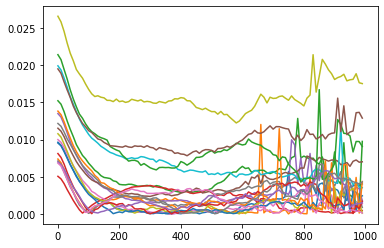

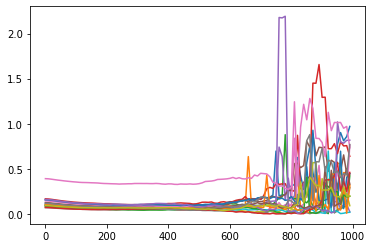

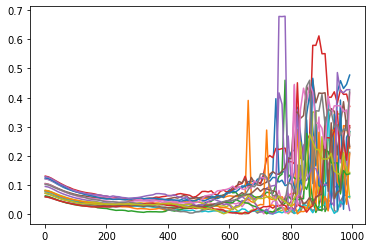

In [47]:
xvals = list(range(1,1000,10))
for cRes,truth in list(zip(resByChromosome,truthValuesCO)):
    plt.plot(xvals,abs(cRes[0]-truth)/truth)  
    
plt.show()
for cRes,truth in list(zip(resByChromosome,truthValuesGC)):
    plt.plot(xvals,abs(cRes[1]-truth)/truth)
plt.show()
for cRes in resByChromosome:
    plt.plot(xvals,abs(cRes[2]-truthValueL)/truthValueL)
plt.show()

# plotting the effect of minimum distance on estimates for all autosomes SINGLE REPLICATE and pooled individuals


In [26]:
autosomeNames = list(range(1,20,1))
autosomeNames

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [27]:
def calc_min_dist_effect_V2(argv):
    cName,minDist = argv
    testPooled = df.loc[(df['chromosome']==cName) & (df['replicate']==1) & (df['Unnamed: 0'] <= 1000) & (df['Unnamed: 0']>= minDist)] 
    testPooled = combine_across_individuals_and_replicates(testPooled)
    
    lowerBounds = [ 0.0001, 0.0001,10]
    upperBounds = [ 0.1, 0.1, 2000]
    startPoints = [ 0.001, 0.001, 50]

    opt=nlopt.opt(nlopt.LN_NELDERMEAD,3)

    opt.set_lower_bounds(lowerBounds)
    opt.set_upper_bounds(upperBounds)
    opt.set_max_objective(lambda x,grad: single_chr_obj_fun(x,testPooled))
    res = opt.optimize(startPoints)
    return([x for x in res])

In [28]:
def get_chr_min_dist_effect_V2(cName):
    jobs = list(range(1,1000,10))
    jobs = [(cName,x) for x in jobs]
    with Pool(cpu_count()-1) as p:
        estimateByMinDist=p.map(calc_min_dist_effect_V2,jobs)
    estimateByMinDist = np.transpose(np.asarray(estimateByMinDist))
    return(estimateByMinDist)

In [29]:
resByChromosome = [ get_chr_min_dist_effect_V2(xs) for xs in autosomeNames]
print([np.ndarray.tolist(resByChromosome[i]) for i in list(range(len(resByChromosome)))])

[[[0.0015502416354563676, 0.0015468962433517314, 0.0015413079493952018, 0.001536556760653134, 0.0015327673257397242, 0.0015324262575854733, 0.0015282520563474778, 0.0015279237582608773, 0.001526864253072903, 0.0015240450797632471, 0.0015268622904688817, 0.0015220430398239686, 0.001524278248237621, 0.001526211280183568, 0.0015228033959095734, 0.0015280585641952913, 0.0015238525918235867, 0.001523560996266455, 0.0015294001865991196, 0.0015289663545647366, 0.001535541906531636, 0.001533569670634784, 0.0015360309001356798, 0.0015334121082387956, 0.0015366189973196327, 0.0015374278333030729, 0.0015314746783259914, 0.001533988284702859, 0.0015355850208038512, 0.0015414971564433832, 0.001540974127601548, 0.001540955044495672, 0.0015423499855847186, 0.001543518097285679, 0.001540321403345285, 0.001540638662105588, 0.001538470838883008, 0.0015408182047428097, 0.0015385533165678989, 0.0015423348191402645, 0.0015423542931556982, 0.0015463653199302724, 0.001551818728472805, 0.0015483281457400453, 

In [ ]:
resByChromosomeSingleRep = [[[0.0015502416354563676, 0.0015468962433517314, 0.0015413079493952018, 0.001536556760653134, 0.0015327673257397242, 0.0015324262575854733, 0.0015282520563474778, 0.0015279237582608773, 0.001526864253072903, 0.0015240450797632471, 0.0015268622904688817, 0.0015220430398239686, 0.001524278248237621, 0.001526211280183568, 0.0015228033959095734, 0.0015280585641952913, 0.0015238525918235867, 0.001523560996266455, 0.0015294001865991196, 0.0015289663545647366, 0.001535541906531636, 0.001533569670634784, 0.0015360309001356798, 0.0015334121082387956, 0.0015366189973196327, 0.0015374278333030729, 0.0015314746783259914, 0.001533988284702859, 0.0015355850208038512, 0.0015414971564433832, 0.001540974127601548, 0.001540955044495672, 0.0015423499855847186, 0.001543518097285679, 0.001540321403345285, 0.001540638662105588, 0.001538470838883008, 0.0015408182047428097, 0.0015385533165678989, 0.0015423348191402645, 0.0015423542931556982, 0.0015463653199302724, 0.001551818728472805, 0.0015483281457400453, 0.0015465507603782066, 0.0015552255246861395, 0.0015596528029934464, 0.0015636615819059462, 0.0015583620689639183, 0.001563497896883774, 0.0015441474247978502, 0.0015337347840560845, 0.001559502829953173, 0.0015561304816067588, 0.001559363899678922, 0.0015609125586810101, 0.0015638615251583586, 0.001492578743325533, 0.001485912412837304, 0.0015091521526795564, 0.0014819113196846232, 0.0015453560776075325, 0.0015493435114151142, 0.0015484455800950842, 0.0015546230341762141, 0.0014806692700200966, 0.0015281968706310684, 0.0015152357388824073, 0.0015323163432143091, 0.0015552894561036337, 0.0015711039459384147, 0.0015675267422313992, 0.0016070799756426452, 0.0015997276494059028, 0.00010128802369364962, 0.00010001177231121405, 0.001568164345917564, 0.0016138641165560229, 0.0015795637136955917, 0.0015821538646054352, 0.0015571492142058031, 0.0016036821603456612, 0.0015694841263189467, 0.0015681769827390587, 0.00010000490218939223, 0.00010001697979461449, 0.0012926256629564258, 0.0012407047611564586, 0.0012881648057697565, 0.0014622033154561257, 0.001480206586855466, 0.0014097974504377307, 0.0014461287777233212, 0.001071333170334622, 0.0011511912507631947, 0.00012179282842707291, 0.00010012483826757279, 0.002060055612462664, 0.0020571964651044687, 0.0005076874327499411], [0.00315352776816222, 0.0031253724868374093, 0.003077361770557515, 0.0030365780707812835, 0.003003260808600211, 0.0030005198452589667, 0.002960655308441149, 0.0029576964039854632, 0.0029464160591009215, 0.002915279575069369, 0.002948801146786307, 0.0028904629544336887, 0.00291833725971199, 0.0029469473997862992, 0.002896521162105513, 0.002982781311546659, 0.0029070440095076374, 0.002902758136449093, 0.0030285565260205665, 0.003019762009025172, 0.0032177641019638745, 0.0031542663312200403, 0.0032553210259861328, 0.0031373450827893844, 0.003297792155709222, 0.003354992738542603, 0.003027626278625125, 0.003157811186095349, 0.0032656934895550806, 0.004300610679849437, 0.008671985375298393, 0.009029881901247056, 0.007644577052276258, 0.004491217421919439, 0.008050537189186247, 0.008071576287825616, 0.008508084875003614, 0.00759388715706351, 0.00807041336452598, 0.008059164346721734, 0.007987380949883329, 0.007462203411168376, 0.0064795556517862046, 0.006887861688047177, 0.007315146427661033, 0.006764437249150979, 0.00631479922809227, 0.005397948721109923, 0.002408648107433077, 0.0030092327257778126, 0.0019003319907149412, 0.001736051458086715, 0.0028586232071708424, 0.00520713175402158, 0.004957831757937584, 0.003917689287089438, 0.0035644872225139915, 0.001355852651204107, 0.0013276007857134663, 0.0014425629039332751, 0.0013101258791328814, 0.0021291358589446766, 0.0039577193068939046, 0.002109332769372492, 0.0024581744511577392, 0.0012621645847853715, 0.004615802157502119, 0.005166843383765455, 0.00463620558182427, 0.002566230795396232, 0.002451840637987444, 0.003985007881961872, 0.0025475109517898256, 0.0024635301192387216, 0.001370166519051929, 0.0013718499819963615, 0.0026059571301879246, 0.002377091306426914, 0.002426207050194007, 0.0024483081473529334, 0.0026299347212869993, 0.0026388004036206375, 0.0023858116368894932, 0.0026486837775603267, 0.0014066801238824312, 0.0014682828697593438, 0.0031538853395721928, 0.0045633592091588755, 0.0034430051732852723, 0.002713140556213442, 0.0028118164511572877, 0.0023946717078095086, 0.002978038064830063, 0.0030236912359691754, 0.00262336145724394, 0.004028881238125011, 0.003131582908474561, 0.00010004272324705017, 0.0001, 0.00237782941368033], [83.55623900830034, 84.68137740246331, 86.64088010487808, 88.35869642284189, 89.78990544285742, 89.9123660726028, 91.63387052831351, 91.76577041609326, 92.24930275283276, 93.59251897989861, 92.17285709173314, 94.65634915414878, 93.46507990830882, 92.30972247755682, 94.36157583967582, 90.96270382298275, 93.88628819635599, 94.06266288759183, 89.40878827732153, 89.72517716039727, 83.4125865537003, 85.33266484007706, 82.38860178732577, 85.81517737506556, 81.25559794692404, 79.77379153245712, 89.18708312125787, 85.18832903370533, 82.17558765112712, 61.842771131889805, 30.68295583006209, 29.467312793239387, 34.74199372658433, 59.048073818449424, 33.08293086117843, 32.98272617997462, 31.384813334264543, 35.048444671208344, 33.08384152263473, 32.952730443493806, 33.2486047255334, 35.38434378849831, 40.42725933288458, 38.22575832967286, 36.08824640725722, 38.52323817107829, 40.99067367896394, 47.658489168173645, 107.82256442478706, 85.53336272881393, 140.1972869784322, 156.399520947692, 90.63312645525137, 50.00691316610843, 52.2528453195613, 65.96733592757494, 72.15717693406214, 216.88903837786827, 224.35212640951264, 197.49683553682272, 229.12818571606118, 124.72611419238729, 66.5732872713955, 125.26860660145613, 106.30350967065365, 239.18899261940618, 59.09780980367688, 53.89625587479936, 58.44232367480933, 101.6427717441637, 103.51496636063284, 64.07203422240526, 93.26860719809622, 97.7904749790323, 1436.443439116907, 1433.5377430060994, 97.97956005076333, 98.61814866717711, 103.13147462722033, 101.71567090194225, 99.09616207878915, 90.5358857631164, 106.84192163443163, 96.46518397935753, 1320.577078732429, 1161.6686105939466, 122.41768376182779, 90.01141134380555, 112.71691393699894, 112.17855388685899, 105.17196862633483, 137.90433397404533, 104.86441902288479, 164.151525200883, 174.39990363852496, 242.9168763904845, 326.3457425601539, 10.0, 10.0, 345.13779969011387]], [[0.0018587670178447173, 0.0018564396847692223, 0.0018540650159872382, 0.0018505181041911013, 0.0018433350050236857, 0.001839405647624395, 0.0018367913629045653, 0.0018339419022464847, 0.0018304395957121108, 0.001821913320671163, 0.0018104135312714794, 0.0018108301235321034, 0.0018119601546098952, 0.001809306641353522, 0.0018135592011537876, 0.0018133360616058758, 0.0018119747483096422, 0.0018159137624299678, 0.0018151649746062978, 0.0018156809938709227, 0.0018136697310117765, 0.0018124944836949194, 0.0018156953340464565, 0.0018155745463844823, 0.0018103737306525238, 0.0018146133677665757, 0.0017967461146187196, 0.0017852027463130492, 0.0017805682549601025, 0.0017656139024976804, 0.001762084587550485, 0.0017505128008943036, 0.001755103205168816, 0.0017602051138513037, 0.0017615468415817246, 0.0017472222473297041, 0.0017366897067621224, 0.0017219458228940837, 0.0017353235365560606, 0.001751099842693608, 0.001761858444930249, 0.0017483663411163907, 0.0017604766004561524, 0.0017572883812819102, 0.0017593002821446818, 0.001783835719817303, 0.001757838376783922, 0.0017770414590087564, 0.0017709549067324612, 0.0017883848995395167, 0.0017808007818554527, 0.001780601470625439, 0.0017890960734001362, 0.0017921778429612033, 0.0017906488659664784, 0.0017716202444827728, 0.0017959823633858438, 0.0017615066043678062, 0.0017880408546131726, 0.0017315221644039099, 0.0017872131984248464, 0.0017751579787546553, 0.001788958712433667, 0.0017961544491391396, 0.0016689032893010872, 0.0017122308732223862, 0.0013646825812997998, 0.0016048349839392884, 0.0013797656342267668, 0.00012489634400345993, 0.0005979027781169129, 0.0008491069400683407, 0.001086753464935255, 0.00010000696326371999, 0.00010000210608421227, 0.0016558189498187235, 0.001691164767404462, 0.001757473942091416, 0.001716608812210443, 0.0016973201763059286, 0.001706107688777955, 0.0017516034712013813, 0.0016882009897133277, 0.0017050393078070585, 0.0016847845866065343, 0.0016880412599850649, 0.0017713539911908985, 0.0019143991016871312, 0.00010004047316684823, 0.0001001314546268695, 0.0016355674431235297, 0.0016014044002296897, 0.0013674331841063367, 0.0009345743930196781, 0.0009486600351236918, 0.0009728527869262639, 0.001091852615815206, 0.0025786277756235563, 0.0025877507839350278, 0.0025700868801887045], [0.003957981624006688, 0.003944564273058196, 0.0039306821507135966, 0.003909123428103043, 0.0038636401824260194, 0.0038385662681691564, 0.0038211901630026187, 0.0038016776087389705, 0.003776186925004794, 0.003713118741212637, 0.00362976864030225, 0.0036328771563278258, 0.0036419470740404938, 0.003618756391633996, 0.0036557984610790318, 0.003653192593952217, 0.003638944690883288, 0.0036819758262089065, 0.0036744649095097016, 0.0036812908596013877, 0.003655499214108956, 0.003639431300525694, 0.0036846052873862156, 0.00368053496706145, 0.0036000556464772953, 0.0036697506305737723, 0.003399201955801824, 0.0032578200509170473, 0.0032071156992326375, 0.0030547529355470066, 0.003021172158937428, 0.0029195417222742737, 0.002961257600387767, 0.0030128875115537665, 0.003028803661266878, 0.002883255538333131, 0.0027913294669030878, 0.00268078289670113, 0.0027861998842786746, 0.0029519342804904015, 0.0031057370808160703, 0.0029059492070223625, 0.0030910186274261306, 0.0030345001668128247, 0.003063505766786241, 0.0039050325208480684, 0.003009525003750262, 0.0035643550171431705, 0.0035388666413999426, 0.007398303198592011, 0.009071788217709997, 0.009036545637587202, 0.008260055385236081, 0.007764124657387543, 0.007686999458223555, 0.0029124018123670705, 0.006637242997578771, 0.0026884988802062452, 0.0034582479419353667, 0.002342797055736061, 0.006313085265796022, 0.007262681599295155, 0.0035431506705943636, 0.0035737810266040005, 0.0019418239951016713, 0.0021197698497630413, 0.001611698028040035, 0.0017951707946268069, 0.0016129117108351681, 0.0019307015997743237, 0.001746879852092713, 0.0016656079058045138, 0.0016146751093990097, 0.0019143125208704093, 0.0019066011506372227, 0.0022883264964771825, 0.006236079881110667, 0.0037583303661177687, 0.0037353624973574568, 0.003815392772332747, 0.003609561453926431, 0.003686304382364963, 0.0033755814996838237, 0.0038050616479695125, 0.005386434426855212, 0.0038800891840841483, 0.003708468623973709, 0.0028052805772792403, 0.0017929967115153436, 0.0018642029830364336, 0.0036263743770767977, 0.0038884325442014316, 0.00433904024276747, 0.007561664975115949, 0.0051528281552090105, 0.006473973726854024, 0.0071344849154286565, 0.00010001521804597419, 0.00010000000267822699, 0.001921809467613845], [95.1387829873459, 95.67099347457071, 96.22276492963908, 97.07778979944692, 98.89059687402327, 99.90778073624651, 100.61276350602256, 101.40465901433794, 102.43201639721116, 105.03197811720946, 108.64321776303406, 108.50607079155319, 108.11667520622521, 109.09366617165912, 107.53785539787128, 107.63921224090097, 108.20775940957651, 106.52333776545069, 106.81979846542401, 106.56553293015136, 107.53667308667603, 108.13997604886131, 106.46771248507855, 106.59869918592508, 109.56603989588334, 107.0154634991155, 117.6955994125365, 124.29266617184828, 126.87276854530606, 135.31869191429158, 137.33686031499929, 143.87999310563436, 141.15583906703066, 137.97701390979378, 137.05229235364078, 146.22062779678134, 152.77997138998603, 161.66559707028398, 153.27722767561366, 142.1730235478951, 133.53291449788702, 144.87858774358088, 134.36683482620043, 137.3608571136354, 135.75809063821578, 103.6098934708906, 138.44729288500432, 114.37066581719077, 115.89789582032417, 54.391029126862094, 44.69506767576122, 44.877437838797455, 48.67724813677457, 51.624118230794096, 52.22367918904865, 141.0998435164051, 60.15351860684942, 154.76119084194346, 116.5524440570644, 184.26055123798295, 63.83866817880696, 56.200102687955464, 113.61143426581481, 111.76248659575222, 241.06535009683205, 209.1085925023371, 417.06365836427324, 282.3440793790595, 410.0187978241464, 1017.3643364475947, 793.4450964553893, 673.6199025341921, 556.0827337753095, 1068.3672630440994, 1080.2570030852348, 204.9857337477235, 71.7152820285831, 110.93743998736768, 116.67823246675525, 116.56261740043794, 122.09131514265582, 113.76793779276095, 133.12156876683537, 115.9641786018227, 83.65401386374518, 115.77887359031237, 110.43724515219887, 121.71064907590565, 1284.578446859118, 1146.8683419772258, 131.12668560440017, 126.52854392782001, 139.72021586083898, 108.02142162154922, 157.4925245841731, 123.36634555000096, 103.71801363085038, 10.0, 10.0, 10.000270533671147]], [[0.0019157911999569776, 0.001911281795945264, 0.001911885553786942, 0.0019022545703828607, 0.0018978094985724744, 0.0019041749352631968, 0.0019059424338489254, 0.0019007434924752822, 0.0019065655218628319, 0.001909246300627943, 0.0019086193495174435, 0.001909681981785879, 0.0019109894208364335, 0.0019092480138512367, 0.0019052570700512444, 0.0018965721765054322, 0.0018947200388302664, 0.0018925988287556523, 0.0018988440213241757, 0.0018990528392810668, 0.0019007862538114539, 0.0019064797397227782, 0.00190377427407637, 0.0018824933769246662, 0.0018784198736998083, 0.0018893992223975695, 0.0018957361997596536, 0.0018997124050252143, 0.001890777588770082, 0.0019032132880590067, 0.0018809018825894953, 0.0018741335032929282, 0.0018672000718455333, 0.0018451367446694874, 0.001859162578320976, 0.0018527047694613854, 0.0018445567680962342, 0.0018560122539385653, 0.0018436031922486234, 0.0018330842922651609, 0.0018020843540228978, 0.0017718639301456728, 0.0017529528729620736, 0.0017425428600771798, 0.0017182968280849925, 0.0017207319546054907, 0.0017094943546329389, 0.0017075246981140425, 0.0017172593705851928, 0.0017272840342703153, 0.0017319674223051729, 0.0017269201952219589, 0.001813736848275079, 0.0018159382463769644, 0.001800902154201798, 0.0017719024727181256, 0.0017771292860373866, 0.0018184262762089454, 0.0016920818757084502, 0.0015236498051893741, 0.0010818519679470686, 0.0013699956490819598, 0.0013162054117836462, 0.0016097114746357996, 0.0011024245212344773, 0.00010000058662332491, 0.00010000068068266205, 0.00010001355033078743, 0.00010000424318692421, 0.0008170923909355207, 0.0016175193255069764, 0.0017342894646423179, 0.0017383908788378, 0.0013763593499770059, 0.001708992630168748, 0.00010007683009737983, 0.00010057541006385801, 0.0016980822267431237, 0.00010001708031886277, 0.00010002199944863264, 0.00010000084705450078, 0.00010000333778701804, 0.00010000003202418421, 0.0016191757279156935, 0.00154560990881764, 0.0015109670507487572, 0.0015146439942405093, 0.0017079783660790128, 0.0014889178106098663, 0.0016374864813156916, 0.0013882954903237869, 0.0012331505590832737, 0.001370063473994054, 0.0018809667700840607, 0.0018316307423173553, 0.0013564340526598094, 0.0017325219327100501, 0.0001, 0.002686155040608349, 0.002683304927048332], [0.004012338634160593, 0.003990681986522185, 0.0039936749538666706, 0.003944998610736735, 0.0039215236428351945, 0.003956721872632799, 0.00396676814699813, 0.00393462450232511, 0.003971757893923146, 0.003991047342278982, 0.003986944358045815, 0.003994796654763284, 0.004006190856852408, 0.0039908284388680505, 0.003953586173671008, 0.0038694489287711973, 0.0038513185861759787, 0.0038308553281557536, 0.003896886917063189, 0.0039005878740358537, 0.003922940395037553, 0.004002635138273541, 0.00395960379917477, 0.0036697276657477397, 0.0036224525128215456, 0.003770510158806306, 0.0038687830573565867, 0.003945373675430079, 0.0037770382354461894, 0.0040338449998957105, 0.0036012727131238256, 0.003499050909930304, 0.003403101965613398, 0.0031554112479451907, 0.0033075586311691932, 0.003229081337783655, 0.0031391620043311813, 0.003276930855609903, 0.003125037481265933, 0.003017502775786748, 0.0027708618787784054, 0.0026024214985572785, 0.002519940846601333, 0.002478328933409125, 0.002395699006514229, 0.002401700712403001, 0.002366140429865168, 0.002360273669523072, 0.0023929470966183434, 0.002429899372112404, 0.0024461069912332266, 0.002422637930372086, 0.003127563681086655, 0.0031700426155847113, 0.002928839065070894, 0.002636032272920301, 0.0026785616165262353, 0.0032423715617706204, 0.0022390960570322963, 0.001954979090799295, 0.0018591399227191664, 0.0018729086467519907, 0.0018590868029647412, 0.0020817911299166585, 0.0018466477770506004, 0.002121672619451706, 0.0021202951475321197, 0.0021338101022849386, 0.002140845555873379, 0.0019248591927150062, 0.0023278022348431657, 0.006529433236160737, 0.006746111608223018, 0.0019169086794145278, 0.002911246344092946, 0.002125696609266252, 0.002132535588280201, 0.0036384561972345646, 0.0021095541516214554, 0.0020769591799190187, 0.0020845071849333605, 0.002072461766413479, 0.0020382365813101416, 0.0035074633398730634, 0.003846341546411727, 0.004318911158307272, 0.006400934573508951, 0.0032597569478983023, 0.003527148996761894, 0.003789020610519244, 0.004749553114996408, 0.0042612734346923605, 0.004141804148075915, 0.003790135177747017, 0.0032356236233906355, 0.004631515226721828, 0.003793945591439073, 0.016259564089241813, 0.00010003071396223501, 0.00010006606507414356], [103.09429684820375, 104.06217241744406, 103.93024720749438, 106.10310150889046, 107.15846524106605, 105.60860079563368, 105.17623444098393, 106.52771165794445, 104.98551693496714, 104.22552271207078, 104.3921763227422, 104.08713566107886, 103.6673607714386, 104.23258166859523, 105.60081551469023, 108.76689917743929, 109.46659372217503, 110.26922757699546, 107.76945425772628, 107.6460165488393, 106.85595624328877, 104.16544180466087, 105.5698405859632, 116.25918108859702, 118.23949198585937, 112.39358601420543, 108.86728974563118, 106.34070256297073, 112.05641527074732, 103.64870625206666, 118.68571119668346, 122.98036049124674, 127.33034685657952, 140.41228641876432, 132.06876909830052, 136.1664732650134, 141.23704905889977, 133.72028139828953, 142.01930060981175, 148.68450243210987, 167.2168457491495, 183.7277798987218, 193.50942747153243, 198.90928075064562, 211.03099596874904, 209.9816310398152, 215.65572046678176, 216.63837409317034, 211.49951342453818, 206.08478842318698, 203.72236979793018, 206.8212960351987, 145.96429288790043, 143.66764289322714, 158.04310976236354, 181.23244814107574, 177.33857335447954, 140.07353273823756, 232.88112072496372, 319.11058949255977, 510.3701207680066, 388.68143667498225, 412.5492136806138, 273.24337550968426, 506.2804894864577, 940.3640906715165, 941.912037293052, 927.1012677547826, 919.6197074794757, 610.0470861683857, 239.36702792597856, 75.20652818333889, 72.51634152464655, 374.6926708894719, 173.66483711997387, 934.8519129665631, 927.1239712310964, 139.8219666957445, 952.1410170640424, 989.7342767682029, 980.8429233706169, 995.2607678561926, 1038.617322866905, 156.0203876280417, 151.2561247391506, 138.36925511418744, 93.00891491227759, 154.7067043080433, 173.12769518078005, 141.79915681458124, 138.46015148845873, 172.4785147123527, 161.16503805058227, 109.99412999424473, 136.41169211274158, 145.65205553497117, 128.72702924439554, 79.85251722193328, 26.123915992655405, 10.089960114239235]], [[0.0017272265305380958, 0.001724889612882283, 0.0017208391611932348, 0.001717292593133567, 0.0017141563056931705, 0.0017162405449874536, 0.001708976209329444, 0.0017017852913296153, 0.0017029451185326273, 0.0017043153955073331, 0.0017080571437282813, 0.0017067848347196916, 0.0017099080997906926, 0.0017065088210086398, 0.0017148123323737136, 0.0017158291618634804, 0.0017181399649110216, 0.0017180188730111189, 0.001715476520122483, 0.0017130537966194926, 0.0017139719450494596, 0.0017194954790265172, 0.0017130221445590273, 0.0017173820497813578, 0.0017226448147320056, 0.0017272639874441362, 0.0017215436790213692, 0.0017196053566537728, 0.0017157734598865961, 0.0017080528987214207, 0.0017098626080375586, 0.0017137649805235285, 0.0017095850089465408, 0.0017155684181426791, 0.0017148088367550454, 0.001720752311096817, 0.0017207513315910757, 0.001716440591695479, 0.0017219902390745263, 0.0017145654054469771, 0.0017190298113912953, 0.001724032611179104, 0.0017185945203158834, 0.0017244025922378238, 0.001723816871805313, 0.001723469601205696, 0.0017102900953137943, 0.001684895315004375, 0.0016594861716596886, 0.0016473955433332003, 0.0015698938121155187, 0.0015283322701787753, 0.0015431254983707913, 0.0015651812703613723, 0.0017074910898404586, 0.0016732290363573037, 0.0017045225256554545, 0.0016323288538131527, 0.001578523734604356, 0.0015278664197835236, 0.0017063943579823746, 0.0016928928729455753, 0.0016776964977084049, 0.0016925640967612034, 0.0015079538765790526, 0.00010000401543492101, 0.00010000040456802141, 0.0001000041430084321, 0.0017010614361035942, 0.00010000245337476066, 0.0001000322977258991, 0.001680125155568244, 0.00010000715151387955, 0.00010031579327233625, 0.001664997058200576, 0.0016242939901172377, 0.00010000359718138766, 0.00160196947887317, 0.001620674303492707, 0.0016079407230982059, 0.0015691470633849157, 0.0014924459417024138, 0.0014903247681369554, 0.0015202797493381274, 0.0014497112150902416, 0.0014863603817836576, 0.0015228878351313873, 0.0015409566615477584, 0.001432097377198036, 0.0015947196181607176, 0.0016076400491418412, 0.001639051243959497, 0.0016600658479316746, 0.0018699923220653362, 0.0019239290482039033, 0.0021413404259167795, 0.0021647620881940517, 0.002200392396337446, 0.00221251088298468, 0.002228873536241824], [0.002764447638199449, 0.0027473535292420513, 0.0027170472239335802, 0.0026902963534813085, 0.002666703169842788, 0.0026840648354798163, 0.00262316493553475, 0.0025635487301234614, 0.0025723477794684637, 0.00258456294974791, 0.00262323136506194, 0.00260859992609877, 0.002646057677290447, 0.0026032054728314597, 0.0027219813621468672, 0.0027401358598886406, 0.0027821448797030568, 0.002779599121156952, 0.0027253910532805572, 0.0026737722727475837, 0.0026963154561285155, 0.0028501986657333625, 0.002660271017652754, 0.0027877120406102325, 0.0030156139139006885, 0.0033068973543939084, 0.0029384510944271704, 0.0028358406081937966, 0.0026695540533251006, 0.002417442228925525, 0.00247689445377887, 0.002626501958245918, 0.002456030110231567, 0.0027475364691873254, 0.0027077497963048, 0.0037485737597438996, 0.004725510778030618, 0.006704936006412494, 0.0051432073608318595, 0.007115814921465316, 0.0069212421382080355, 0.0059784847247111046, 0.006808276815725692, 0.005829806510537591, 0.0025890797887713497, 0.002513625623394946, 0.0019760059118118373, 0.001607243968498591, 0.0014360052987290612, 0.0013817168655500412, 0.0011941443685363597, 0.001147858323615052, 0.0011623860600609355, 0.0011885437479019292, 0.0023377878995557767, 0.0016127983221128597, 0.004747326866391636, 0.0013340952099314186, 0.0011918480706725647, 0.0011260939056667056, 0.002321494799949523, 0.0023465896751031856, 0.002484223496919593, 0.00244700066098016, 0.0010895737951906763, 0.001454096360746443, 0.0014465094196599248, 0.0014736540070082978, 0.0023930620396151693, 0.0014754633977585557, 0.0014895636481777105, 0.002140333336703935, 0.0014862211698185377, 0.001491437254941831, 0.0020164092531016857, 0.0024780715220015467, 0.0014870582857629136, 0.0025061041436053987, 0.002554994715601025, 0.002668790406237559, 0.002540317373619022, 0.0024654110690739573, 0.004018497952125295, 0.0021838877928043983, 0.004811677439818433, 0.0027148420930551715, 0.0025139292355142342, 0.002457901298663614, 0.0026061189418282015, 0.001955679154434526, 0.002110303264828401, 0.002495477310537326, 0.002547928803766033, 0.0019076892339081185, 0.0019280824305482483, 0.0020859015800878907, 0.002087705466064636, 0.00010000414169474463, 0.0001, 0.00010000234680010786], [87.73590042356481, 88.57719013258418, 90.09029994792539, 91.45283042646435, 92.6805540565392, 91.80204057126, 94.93324238584228, 98.16760314539417, 97.66741307865655, 97.01003640480519, 95.05074572348528, 95.76502129557583, 93.96772211161019, 96.00512196243336, 90.66819701973687, 89.92732707311384, 88.25818761815808, 88.35496165919335, 90.46828205961468, 92.56134824063099, 91.65617513663102, 85.9574917355943, 93.0426336341747, 88.17602775584885, 80.83116535054792, 73.17381424523074, 83.1029659143831, 86.38019846524587, 92.33602572616681, 103.2746386558718, 100.48900710623133, 94.15016691640794, 101.39514965129416, 89.72748425683616, 91.15965397342214, 65.18661614313908, 51.703481470732726, 36.678506377970436, 47.41141326499382, 34.661036580412194, 35.39133949238557, 40.652922751134625, 36.00379624301675, 41.66146954460534, 93.97024322214719, 96.85935215319563, 126.18132958367154, 162.6373910597655, 190.9309551226097, 202.9882859100709, 271.1110320198429, 303.89835645129523, 292.2685118315981, 274.69737575111674, 107.0560411958319, 165.2634353872067, 52.94136765428323, 216.14123571519036, 267.89880528239075, 311.3054801647424, 108.01529113487362, 109.32454251338768, 105.87812920219201, 104.86532966064274, 334.9710294632496, 1450.0377925992698, 1478.1968783998977, 1382.6239108947962, 105.79506829868569, 1376.586205763474, 1332.8903865641742, 122.71048108915362, 1343.0850060031735, 1326.9543873062478, 133.70378152278408, 116.19793772331332, 1340.4595054268543, 119.01726790854573, 113.34773125077274, 110.71834338220488, 123.4407783955235, 141.8159309814165, 87.12128408088762, 154.21404363924074, 76.74893817999133, 129.75571117424343, 133.2269242859008, 132.76629229834896, 145.32256415248438, 153.72673294748523, 139.43919683768615, 111.74304155482528, 105.49492083774071, 87.09456127062967, 72.49911808338834, 15.778607938694357, 10.000000000000021, 10.0, 10.0, 10.0]], [[0.002069075198618521, 0.002067401363693296, 0.0020633568258375556, 0.002062819056472904, 0.002061685910793885, 0.002059319692141292, 0.002052486623981967, 0.002055691895370645, 0.002048014903774114, 0.002042327996995835, 0.0020417063936767474, 0.002038804788318103, 0.0020412116471138905, 0.0020442138357898414, 0.002040070902433096, 0.0020412716189444615, 0.0020442093105970446, 0.002044143999556796, 0.0020442716636036177, 0.0020544139538744193, 0.002048993816843212, 0.0020422651698350992, 0.0020425474706586054, 0.0020379151686532905, 0.0020460687804169245, 0.0020390304070061135, 0.0020402655891740423, 0.0020408962776475555, 0.002044790056777716, 0.002044730745590353, 0.002049553014563752, 0.002055347685408389, 0.0020516743934083717, 0.002056582726886168, 0.002058546634241807, 0.002059111666363359, 0.0020603957112896682, 0.002056704370239378, 0.002060595459811426, 0.0020637119211961933, 0.0020621532090021218, 0.0020628260275994195, 0.002054366507500998, 0.0020534215199225613, 0.0020628417082048708, 0.002064744263444793, 0.0020704988309790734, 0.0020547822325163, 0.0020623250567476208, 0.0020809551569264434, 0.002090507767941425, 0.002086628523082225, 0.0020872518454881344, 0.0020839468357186355, 0.002080831273333893, 0.0020652891459050733, 0.002073072244021008, 0.0020650334484488553, 0.002088858795151329, 0.0021026931137477734, 0.0021114911440891808, 0.002108913344301142, 0.00212454261806134, 0.0021363620191330096, 0.002154718729060228, 0.0021530686030682717, 0.002159326107851647, 0.0021790584841186234, 0.0022026217191144903, 0.0022051684781655423, 0.0022243042445616672, 0.002257625063030526, 0.0022892979866626383, 0.002294810946098188, 0.0023031299968897453, 0.002297087999739179, 0.00231716481331297, 0.0023399774736916693, 0.0023131739399885652, 0.0023679663426896397, 0.0023652026917564614, 0.002522110674391333, 0.0025352196833930258, 0.002538811950064948, 0.00244083097919581, 0.002413684779103342, 0.0024189746405571372, 0.0025240521907658937, 0.0026179668187372223, 0.002412799768753024, 0.002571107311969081, 0.0024967136996907314, 0.0017844060350728041, 0.0018324089747660038, 0.0018169418254330829, 0.0013406830363114019, 0.0001, 0.000280701810825634, 0.0027336819896831305, 0.0027554061229454283], [0.0035177614388543776, 0.003508306331050554, 0.0034853946473999897, 0.003482085585241934, 0.0034750863018033346, 0.0034601121907265643, 0.0034144155158260347, 0.003436065803686466, 0.0033789143711842897, 0.003337056278772914, 0.003331569729007747, 0.003309751907063608, 0.0033300777941414382, 0.003357960640384005, 0.003316457184789072, 0.0033296827198284803, 0.003364887127487784, 0.003364498470156456, 0.0033667797465102437, 0.0035274702409767676, 0.0034336864356240004, 0.0033221465611184076, 0.0033287448211917073, 0.003250127257379786, 0.003402758776866773, 0.003255350504552017, 0.0032801402416329398, 0.0032954274025172123, 0.0033969361320861117, 0.0033989089346093968, 0.0035751862234631436, 0.003920225383706689, 0.0036661948990336125, 0.004080214956466598, 0.004413424812165176, 0.00891603108051062, 0.0077129045912535605, 0.009691458773747295, 0.008514731116306781, 0.007000838738982128, 0.007980046529501997, 0.0074966221876261755, 0.009592440081155128, 0.009341447383027734, 0.007950802773903316, 0.008200829364105443, 0.007432592676730188, 0.008638263109100763, 0.008480653384555017, 0.006609444169877815, 0.005509177031889219, 0.006363911063437342, 0.00626013382394593, 0.006511313839591777, 0.006634095672028953, 0.007469046726577076, 0.007257883746672073, 0.0073721926411990935, 0.006918089965451875, 0.006467258287867493, 0.00624174323215413, 0.006262204885204372, 0.006015373804302284, 0.005496523894305445, 0.005147662601330656, 0.005494763781079715, 0.005450798591344673, 0.004977097787098788, 0.00473915469866853, 0.004614016039400154, 0.0027763114891928755, 0.0026370854986183146, 0.003691293496542266, 0.002479518599359468, 0.002515754108546484, 0.0024844935456699935, 0.0023652828903581984, 0.002320270599836681, 0.002489013873271312, 0.0023052896537437955, 0.0023081782489241965, 0.0020097397257726, 0.0017751047951239675, 0.001842871020626447, 0.0020530762023130717, 0.002143132198943246, 0.0022205511924960515, 0.001752642095276864, 0.001726465977001023, 0.0022812002913897523, 0.0015514356433305903, 0.0020320879300365705, 0.0028295723920817185, 0.00371649442693274, 0.004065011286630864, 0.004304740017018886, 0.016286590140349527, 0.006332434678395719, 0.0001, 0.0001000026038565421], [95.35196591142397, 95.77724103649362, 96.81615338370204, 96.96350981278869, 97.2751774224276, 97.9408808718965, 99.97506767736682, 99.00699750028096, 101.51533922208586, 103.42031827524661, 103.66308023015756, 104.6718299520077, 103.76025199678324, 102.56060935697346, 104.32181516167122, 103.76699461838112, 102.34457173145672, 102.36283713752368, 102.27786807329568, 96.50133867987967, 99.75099808004896, 103.90010542475103, 103.65982916788681, 106.74117165596249, 100.98596499706355, 106.4398360346346, 105.48056372165041, 104.91199950094824, 101.30222977345795, 101.24943709740126, 95.695665588357, 86.65659021074188, 93.0804830848488, 83.12783483851265, 76.6626897162159, 37.9034711721962, 43.755649510707926, 34.963485506381204, 39.625000864991776, 48.02577451821453, 42.20640851494868, 44.895216580663266, 35.423470264724614, 36.41455425498838, 42.32657934197797, 40.94386603732137, 44.87278184070758, 39.32646251948674, 39.70497070746784, 49.82203602628692, 59.07722572618542, 51.38716789172669, 52.19981685490065, 50.3934001314139, 49.65301448169891, 44.96225354922426, 45.82359415911432, 45.56800578518272, 47.11752302962434, 49.50334025748134, 50.697281454785205, 50.70643543130538, 51.67514709139023, 55.63226417087189, 57.86076336733561, 54.33714216899237, 54.27275097989428, 57.7006661542505, 58.41053468590122, 59.75304641536823, 96.25815900527977, 95.71783558391316, 64.52409462165821, 95.0841032535013, 92.22312697090604, 94.48012039064585, 95.38374721865898, 92.76364986983225, 91.42613227365607, 87.7341348169578, 88.19979472400858, 64.96495883363794, 70.10404508683462, 66.61620301385011, 82.2772601480792, 84.79718077416665, 80.66425760639905, 73.70853236875635, 48.75830074811772, 80.07283722834148, 68.61778100515431, 70.07826914649084, 173.23705967535267, 125.18498228912343, 116.16751504545684, 164.43805499644446, 81.11800402310166, 194.930163271923, 10.0, 10.006537609249959]], [[0.0017038487080182942, 0.0017029405502387732, 0.0017020031536211836, 0.0016983274522492174, 0.0016968600400343418, 0.0016974682197075622, 0.0016999863595041427, 0.00169042086158977, 0.0016944848093773848, 0.0016979848287148247, 0.0016971565545253198, 0.001694916195799657, 0.0016871366974844791, 0.0016852771332241407, 0.0016903283923871506, 0.001697207599572381, 0.0016982845789424751, 0.0016975730684458043, 0.0017030388173355513, 0.0017072629766158218, 0.0017106892372576398, 0.0017140022780863973, 0.001721451341903317, 0.00171902614748619, 0.0017120630306958792, 0.0016902558390834497, 0.001680725423201708, 0.0016799224208780496, 0.001678029929475336, 0.0016684087770072182, 0.0016627425333838298, 0.0016686288092405562, 0.0016693269463730791, 0.0016774984422096594, 0.0016814965170525342, 0.0016814800008079058, 0.0016723540757019669, 0.0016957076344039776, 0.001707600546747265, 0.0017070800672941866, 0.001705420333287485, 0.0017051430640981499, 0.001709361900201038, 0.0017085170340353838, 0.0016768271893363102, 0.0016651133951861596, 0.0016986498018153975, 0.0016805828974187065, 0.0016664159289007802, 0.0016470791557351818, 0.0015966765040633037, 0.0016060332577086994, 0.0015377137192702061, 0.0014736556225984146, 0.0015120383710595787, 0.0014933269420863843, 0.0014483308445235093, 0.001482225353404535, 0.0015290223993770532, 0.001464942449260796, 0.0014240561043939583, 0.0015298121455024818, 0.0016405867552295522, 0.001618554419869584, 0.0016170315091677927, 0.0016290216519936817, 0.0016178426791114864, 0.0016212931641006287, 0.0016149289960367176, 0.0015979003015448843, 0.001644486671650236, 0.0016788605694640787, 0.0016663489796109243, 0.0016933376685074769, 0.0017016108412866368, 0.0017138044858426293, 0.0017240610470336917, 0.0017277095053367946, 0.001767076715512869, 0.0017236159145938936, 0.0017064544031342613, 0.0017294730008975694, 0.0017331968814898084, 0.0018117513003001098, 0.0018518906219595747, 0.001859732836831822, 0.0019016048137632563, 0.002142928090140015, 0.002204200161229045, 0.0020182726094687123, 0.0018625256896394615, 0.0014745491813678217, 0.0015100774766917575, 0.0020084922664177045, 0.0016781724871825286, 0.002324790324608021, 0.0023226592405660076, 0.0023242570145208946, 0.002338502633823395, 0.0023494001284587074], [0.002874212041804441, 0.002869905442610481, 0.002865350038291481, 0.0028468222340144126, 0.0028390999505638007, 0.002842352400108213, 0.0028559721978191335, 0.002799284233627356, 0.002823828075805066, 0.0028472056010446565, 0.0028416138020902902, 0.002824372576078002, 0.002766691822761841, 0.0027524797339720554, 0.0027935218703839075, 0.002857305588987366, 0.0028692870364919795, 0.0028622281927115746, 0.0029286307900814957, 0.0029891725493267425, 0.0030447887743472023, 0.003108349802618442, 0.0032749008530296424, 0.003212681399093574, 0.003049118665374366, 0.0026784647442266974, 0.0025599688005246975, 0.0025506584673409844, 0.0025276571483448997, 0.002419318816585061, 0.0023607111829840838, 0.002424191862617814, 0.0024320501813230757, 0.0025446364111909236, 0.0026130071463312393, 0.0026079868373912133, 0.002444911989591761, 0.003041894637874396, 0.0045114102177649575, 0.007404125112592029, 0.007904267606909236, 0.008193564876031869, 0.0072023512968534195, 0.007545219638666789, 0.002319478980378743, 0.0021492542559685924, 0.003100602046586615, 0.0023840080028090177, 0.0021466037156981765, 0.0019451976580685563, 0.0016734502622748624, 0.001710786184110523, 0.0015179672398962902, 0.0014288765304347507, 0.0014765059663122988, 0.0014496965395190623, 0.001401287938911376, 0.0014348987045209305, 0.0015094271224212882, 0.001410972657285388, 0.001373100469658647, 0.0015223055111354554, 0.0031892567475365163, 0.005959588612286487, 0.006201790841955507, 0.00543476751026979, 0.006120954446876645, 0.005875381111141178, 0.005991084000165401, 0.006346468683363952, 0.005585189501509732, 0.004653864482105087, 0.005089430650975493, 0.004631112984445877, 0.0047191741096983915, 0.003522828211389952, 0.004106509450514854, 0.0029396534690073277, 0.002734831993172834, 0.004021549137875417, 0.0039799008781882935, 0.004041350959403329, 0.003205283148635408, 0.0024807733692833525, 0.0022768342181492033, 0.002384716226774249, 0.002249110931983012, 0.002155204691406854, 0.002148895792927154, 0.002095468900693748, 0.002504935018691194, 0.0040270628254681215, 0.004450762287249982, 0.002086049798978133, 0.002565863679496426, 0.00010008155400694865, 0.0001, 0.0001, 0.0001, 0.0001], [106.27969176563593, 106.55492241809509, 106.8459878007908, 108.01643264922191, 108.50361731514589, 108.29843487655671, 107.45462959225131, 110.91769771050392, 109.40790891735712, 108.04458388977991, 108.36676299051229, 109.3327877062347, 112.69887744036555, 113.5449420438348, 111.1690050597125, 107.74634681886724, 107.14851726634947, 107.50919886398913, 104.3375446208847, 101.66892032725399, 99.36992198515014, 96.91980960902109, 91.10467563582793, 93.16309647723355, 99.06189705549517, 116.080823793845, 123.01256168682764, 123.59488723923448, 125.03956047383457, 132.35866843157214, 136.70181495911856, 132.04890146308003, 131.4966658026341, 124.26759598546683, 120.34756634008997, 120.58565859354678, 130.29071055724597, 101.34860241219363, 67.22771255102447, 40.98393050350197, 38.47087575321657, 37.12606522390543, 42.009639529976745, 40.1441257914083, 136.6911885824837, 150.09925226767055, 99.04309263801764, 132.26348511382787, 150.0288302400358, 170.46612729880997, 213.86482735202253, 206.24337593512348, 257.6444099957848, 300.7325732337764, 275.12692564158533, 288.08926939443916, 318.29320725303046, 295.89403280940155, 262.29046167817506, 308.85457540190134, 336.94487541803437, 259.49493294403396, 104.14669408844182, 57.30627131841622, 55.17540558159767, 62.00363987863137, 55.8463588602603, 57.92425553919312, 57.27323390018715, 55.25608101073807, 59.07760254127544, 67.60176342797412, 62.92235876455398, 66.5245967485109, 64.49083940111343, 84.81966397009994, 71.63481461696387, 99.52146543259114, 100.35911479295208, 73.24038380617174, 75.99985289615037, 72.19980342812377, 90.5073179772063, 102.06402432614203, 102.90169411685932, 96.68468817321461, 93.6664879138033, 44.3345509094422, 30.87666857861786, 74.3485284678842, 92.15411637858423, 103.95827818602146, 90.21230768843681, 75.95823269890734, 124.81018254876011, 10.000123281552774, 10.0, 10.000010093662423, 10.0, 10.0]], [[0.0016728087722569702, 0.0016722017745935637, 0.0016677859076642486, 0.0016674269206036175, 0.0016693052937356732, 0.0016687945025098355, 0.001669175012870892, 0.0016666725155516952, 0.0016712396263795296, 0.0016668690982356161, 0.0016611509393293495, 0.0016521914613391903, 0.0016533870212911005, 0.001651349604662186, 0.0016478840477054685, 0.0016437880114925335, 0.0016451886931278597, 0.0016470981675521415, 0.0016603528196783251, 0.0016575145616911295, 0.001665651909001978, 0.0016638255111423742, 0.0016595602596467607, 0.001642271974857847, 0.0016458723990372213, 0.0016369247221260088, 0.001625671488005023, 0.0016340480872447946, 0.0016311184931657756, 0.0016465607088446785, 0.001645120230814548, 0.0016536117305735508, 0.0016619715045034114, 0.0016683407189091318, 0.0016659404126130016, 0.0016733299287959651, 0.0016748023350714857, 0.0016753781690591035, 0.0016750512903374714, 0.0016728912580193413, 0.0016747174069468148, 0.0016711261866044162, 0.0016696908763129438, 0.0016701753199804233, 0.001677503837369719, 0.0016722263618812495, 0.001667633298998753, 0.0016765863074883179, 0.0016851068787522322, 0.0016902006505739738, 0.0016856580638479413, 0.0016795924626513443, 0.0016779340223896677, 0.0016809442387734838, 0.0016886776925643997, 0.0016921196175261571, 0.0017043115717035539, 0.0016885762609772704, 0.0016984998519811478, 0.0017088164731067306, 0.0016986628841377605, 0.0016823082948631048, 0.0012679415374664408, 0.0015134614569971374, 0.0016959967626187524, 0.0016941115959036388, 0.0017005002524298947, 0.0016856430619545167, 0.0016986812029572795, 0.0016915387421519807, 0.0016951699803960671, 0.001166028539622525, 0.0006794076883372267, 0.0017111824306033346, 0.0016962926916502803, 0.00010002739851908593, 0.001729269034769089, 0.00171859098794339, 0.00010103718228717022, 0.0018075533670756368, 0.0018319073967943658, 0.0018339752607756284, 0.001816385666326816, 0.001802779081375573, 0.001671165656901061, 0.001629288571771323, 0.0014901527511995314, 0.001534562266295734, 0.0011921259553720888, 0.00010000000013644187, 0.0009058678119408115, 0.001162131894645869, 0.0012476032469818554, 0.0004306505896040523, 0.00035994791309867317, 0.0002603018743160819, 0.0001, 0.0001, 0.002232801606763415, 0.002262603338847453], [0.0027609216589171365, 0.0027582222926258067, 0.002738390532783226, 0.002736600297733245, 0.0027460471458613067, 0.0027429097901815317, 0.0027451837031263852, 0.0027309749031269965, 0.0027576760620215937, 0.0027293866580894535, 0.002693017111150656, 0.002637049350878841, 0.002644400938838286, 0.0026306055914310346, 0.002606662195617373, 0.0025774755793845235, 0.002588188735491671, 0.0026037309000631883, 0.0027253567482420672, 0.0026985989787359508, 0.0027919567869754266, 0.0027712413198796616, 0.0027162613313117382, 0.0025259063435057847, 0.002566440495724528, 0.002471268550989408, 0.0023642782911839078, 0.002445147791902392, 0.002412385256118601, 0.0026142796992057026, 0.0025890117729803477, 0.002755570585800495, 0.0030027758456198867, 0.0033294341931334745, 0.003174462805984767, 0.003929488520176218, 0.00441975638363289, 0.004836900666650271, 0.005016818004004754, 0.007298020990637881, 0.004033140411107208, 0.006919676737789449, 0.007592915193013583, 0.007785609520708188, 0.005985195451725461, 0.0072641796093051315, 0.007885054592583332, 0.0072415717559917445, 0.006144814191402429, 0.004491592901567552, 0.0060557617091672004, 0.006730103733365614, 0.006723758525963294, 0.006728672696246961, 0.006191363417970961, 0.006281360662461452, 0.005458954510072905, 0.0019194976561149003, 0.002145248517061842, 0.004002369233209407, 0.005292837918978894, 0.0017803562304796834, 0.001162297057012668, 0.0012242916517090508, 0.0023118733448568157, 0.00431292847890943, 0.0032611728905196456, 0.004739871947822662, 0.0042417204522132495, 0.004506765064517096, 0.004430390111138889, 0.0011229138034974128, 0.0012875125497381222, 0.0035431929114345785, 0.00440668837584513, 0.0015256202931723157, 0.002934455293319333, 0.0028878740915490525, 0.0014955250484153402, 0.00249328092391672, 0.002550378463252208, 0.0027344183722898593, 0.002686465968704861, 0.002461656030819099, 0.0029158752855667864, 0.0036796981437148763, 0.0038889871840082344, 0.0033426842742020194, 0.003742403724210395, 0.002144315755121683, 0.004017617597320366, 0.004134822907714743, 0.003369584056263117, 0.004408422781620811, 0.002984974169889531, 0.005902157489068258, 0.014403408341113158, 0.014247960767760158, 0.00010005348286901738, 0.00010000434163081034], [109.44680098304326, 109.63514840010725, 111.02632642048792, 111.14840882295567, 110.50944914158487, 110.70625828942673, 110.56213143849702, 111.48436079997651, 109.77803563179941, 111.52639269952081, 113.84853774668939, 117.58513132115506, 117.08184424987382, 118.00148035006342, 119.61307215156671, 121.60531097132088, 120.8821937730869, 119.86314373137762, 112.55823491608403, 114.09240723846455, 109.10715015612449, 110.18545415156707, 113.053287780148, 124.40031347034574, 121.8428044580685, 128.06925600068632, 135.92706675024263, 129.93801646336775, 132.23531972413653, 119.4576389490116, 120.8645791858699, 112.22749684159895, 101.7980089967364, 91.0008330386693, 95.76429831715981, 76.56924459511676, 67.93580400342944, 62.02656929567001, 59.82622056798712, 41.23595696063612, 74.46417552814157, 43.588975438327026, 39.79772058323264, 38.787791291319884, 49.97747849899847, 41.462956250710505, 38.42731005893761, 41.3522470365276, 48.18027019477687, 65.4618769939151, 48.85335633663708, 44.32181887342685, 44.4626155112133, 44.24680725422967, 47.572642717873435, 46.66468148968635, 52.76643707406629, 154.38038026544982, 135.81128745382824, 71.51920831022396, 54.89249017048255, 168.37349684175757, 501.01643442329794, 327.017037898134, 126.42942192502332, 67.87334658896975, 88.91368857802813, 62.54487831308486, 68.53074927924726, 65.20636593789183, 65.961638160923, 616.4144960159648, 955.732333171527, 80.47328964123895, 66.22999360998335, 1392.4311476963348, 94.36077980209197, 97.57901246300563, 1490.2086769921405, 96.53818986546065, 89.94033837814752, 83.53096381034969, 88.08690655173473, 98.74210516592726, 104.6572824673369, 88.29295930349085, 100.52919375934707, 110.62294064489981, 142.78897560415436, 631.9360461820831, 167.69886040665244, 132.49155106933932, 150.34700988884123, 206.9780045211271, 332.0217048432619, 167.96988303130286, 74.37878348306884, 74.95859514276296, 10.0, 10.170101113566252]], [[0.0024549227282853175, 0.0024504387359587793, 0.002446880395460471, 0.0024349686606470865, 0.00242530749049867, 0.0024219896071289663, 0.0024129035458902385, 0.0024115241277755063, 0.0024094327135281966, 0.002411769997150312, 0.0024172827656187374, 0.002421683288297215, 0.0024240827172667687, 0.002420064640787178, 0.0024271995725569373, 0.0024364101561647512, 0.0024364213225278944, 0.0024311089849931343, 0.0024235098211788835, 0.0024305906495541234, 0.002420728726416234, 0.002417327959035718, 0.0024288702677179885, 0.002429918309493672, 0.002444336883811878, 0.0024349860108530625, 0.002427302428939078, 0.002408857328246094, 0.0024052260564972707, 0.0024099989797123945, 0.002410536089162893, 0.0024106221532983556, 0.002416530472472742, 0.002428359678181143, 0.002425474630514684, 0.0024017544266441617, 0.0023862354196274743, 0.002381935488016811, 0.00240094314403656, 0.0023978556082599307, 0.0024220803346844152, 0.002399285665446876, 0.002398149114637902, 0.002391870041833797, 0.0023501022352545417, 0.002384688642664096, 0.0024106077627312613, 0.00241352184504599, 0.002414150957203428, 0.002407605725102346, 0.00241080426951665, 0.0024102069235911656, 0.0024066028399231075, 0.002413858859517986, 0.002410533725032432, 0.002322814683972106, 0.0024037795551585103, 0.0024063641207816584, 0.0024064672641035253, 0.0023166284733208194, 0.00241106581695178, 0.0024117865914505764, 0.002266900307962138, 0.0022024632877490117, 0.0021154758313365594, 0.002323781648475639, 0.0023346369886824, 0.0020394803480228364, 0.0024195769802862394, 0.002403044670385752, 0.002156907421542823, 0.0023907522987429183, 0.002361061551399243, 0.0023785058822306075, 0.002382947809156724, 0.0023833002031576384, 0.0024181612923846593, 0.0023701013400054013, 0.002379187859889751, 0.00010008662506276812, 0.0023640398274187313, 0.0024381376600694452, 0.0024663577436737755, 0.002361410339606373, 0.00010026901888411039, 0.002479504436075259, 0.0023637676375647372, 0.0019399504085078519, 0.0020303579591552353, 0.0023724871939295577, 0.002642886488736767, 0.0024343699446529887, 0.0024582645693069487, 0.0015124111932053922, 0.0019446344798263056, 0.0025056859834714632, 0.00010017236961386962, 0.0001091769636298732, 0.0032271758836922328, 0.0001], [0.004307258757816383, 0.004283256070520958, 0.004263591615799672, 0.004197260963776363, 0.004142489830205778, 0.0041241767952864584, 0.004070482569416689, 0.004061211034628582, 0.004046845806448479, 0.004063716065530625, 0.004104362078118163, 0.004141940225520191, 0.004164398144623991, 0.004125296126286198, 0.004202064151554892, 0.004315202297616905, 0.0043176721420594075, 0.00424157234517363, 0.00413355754817115, 0.0042444448237786495, 0.004084192118578103, 0.00403205250819441, 0.004227738648933709, 0.004250152515156187, 0.004636553548664006, 0.004353252981877477, 0.0041530593137034215, 0.003785074012769703, 0.0037196290104737737, 0.0038040080484788024, 0.003817542466107931, 0.003812826398360721, 0.00395676101812739, 0.004381176244940414, 0.004244856224067128, 0.0035467005050975834, 0.003313905355633808, 0.0032517840657830064, 0.003621222113717562, 0.003546921952921218, 0.0046935636536417046, 0.003564500437342076, 0.0035661029300967655, 0.003372358865312761, 0.0027757419023496203, 0.0032543624434259264, 0.00445500932267855, 0.005306768981857677, 0.006796650554475939, 0.009134828339547468, 0.008720147274127968, 0.009100745780447787, 0.009631353651071844, 0.008803746227225153, 0.0034120764493170996, 0.002274553639374656, 0.0032363884768317006, 0.008227494060439919, 0.008247604473623944, 0.002171951303063915, 0.0033988783132301095, 0.006738548464102956, 0.0019722390157315643, 0.0018534906457090229, 0.0017612760985215672, 0.0022159855345902273, 0.002272190042532745, 0.0017063070660608111, 0.0033100187885655966, 0.0034816437876653305, 0.0017799504224211666, 0.0033521908056387923, 0.006446979860659365, 0.0032409537421389176, 0.003315558935929507, 0.0033378390740459486, 0.0034145156903168947, 0.0055788435551723786, 0.003314493813221289, 0.0021479051194988165, 0.003220983267680901, 0.0032765120795323925, 0.003222816364975778, 0.003498920883188892, 0.0021796560663884567, 0.0033237968254528297, 0.003433522702051934, 0.004222177361035046, 0.003818529453845496, 0.0035916859790876554, 0.0031105418356209406, 0.0034874237653596206, 0.0034520983381069632, 0.00520497464542643, 0.004445144621200291, 0.003649122296911781, 0.003392652680601871, 0.012407319356186344, 0.0001, 0.019653438151461984], [93.67446408754239, 94.56168085914177, 95.2877682776678, 97.79011186897156, 99.91193952708574, 100.64305291456424, 102.77668299898563, 103.13659985008144, 103.69284958432007, 103.04957957909103, 101.53392239088323, 100.21811725210252, 99.46280682338131, 100.76988657694494, 98.29150567106491, 94.9151530472055, 94.85948326722473, 97.03436539714004, 100.27302927910615, 97.00974975772147, 101.75293877499118, 103.40020665419607, 97.54464378968287, 96.93363686388722, 87.64417557293422, 94.18575716604059, 99.46190666536731, 111.1110984759178, 113.47333280776999, 110.43525781963075, 109.98368713476285, 110.11415620797766, 105.48291396932785, 94.144821541043, 97.44932509083607, 119.48991449291313, 129.91764074072518, 132.9908792127903, 117.07461514572672, 119.91265422722559, 88.37214131970798, 119.14960715563473, 119.22153408931403, 126.9414233790047, 161.3719100917386, 132.53957852716078, 94.154976302848, 78.79285802824757, 61.47255972739569, 46.02271546025868, 48.06431238806728, 46.079415441566624, 43.6922659523231, 47.46588605492449, 123.11989887265946, 204.48572668166958, 130.78021093980976, 51.18825639538029, 51.05647974620439, 216.25543302729324, 123.5327677222979, 62.17369204034598, 253.12984713888744, 290.5036261423034, 337.78102928030387, 210.0995746843196, 202.26926781391006, 380.12703398571983, 125.77066294369979, 121.63652247380217, 319.5330295389933, 128.01625356730253, 68.55099361719803, 134.13165500754047, 130.46913021811616, 129.54425897933237, 121.92100241576674, 78.5297087006987, 131.04468318780573, 1522.7937538229426, 137.13370816930677, 124.1755207085119, 122.13488138366273, 126.61623272094272, 1444.712781183684, 116.46909558832874, 128.81597161077275, 152.86973354134693, 157.75913805222922, 121.66224647846181, 98.58633258924118, 116.91578846141766, 114.78366407959524, 165.1456948643915, 145.60945104163014, 101.75613397557817, 551.4469442347352, 126.0278238279323, 10.0, 80.16762722977818]], [[0.0018435163550699868, 0.0018408133507795855, 0.0018439335288141544, 0.0018407527374451715, 0.0018378127269981968, 0.0018377707275431155, 0.0018333507008314563, 0.0018291012466918825, 0.0018224392082567412, 0.001819193377137155, 0.0018249278223932464, 0.001824071745713902, 0.0018306865317100525, 0.0018308030729977704, 0.0018322531344373196, 0.0018312877043447206, 0.0018266697699038494, 0.0018275471576073142, 0.001841827302827049, 0.0018366227141410128, 0.0018330265722554594, 0.0018312672645831077, 0.0018236982927878633, 0.0018141310670971153, 0.0018130466609842652, 0.001803673860303503, 0.001789684345115648, 0.0017674462197410576, 0.0017653423471494594, 0.0017607854573144471, 0.001745497541298895, 0.0017265825748005894, 0.0017024792977891271, 0.0016640086122504411, 0.0016486719625947695, 0.0016223513402273213, 0.001648481366207569, 0.001672060813219935, 0.0016255190639276546, 0.001614804853161758, 0.0015990497252588388, 0.0016054018772537495, 0.001567304849449189, 0.001561630077942086, 0.0015356293608061009, 0.0015260857194781382, 0.001487078822375162, 0.0014933748482092858, 0.0011606397011147264, 0.0011015430989072404, 0.001169434054405141, 0.0011408367217547904, 0.0011548559395633436, 0.0006254625478543665, 0.00010001654808131383, 0.00010002237618809918, 0.0006497927365402972, 0.000960343465430351, 0.0011353677168164707, 0.0012285717410866577, 0.0012899421091476832, 0.001322399754430232, 0.0016077616714789307, 0.0015090145374193117, 0.0016265146155542685, 0.0010817695829289573, 0.001534589261716931, 0.0012993936788133788, 0.0012489517394460138, 0.0013118817415180267, 0.001375367116373853, 0.0016079025202522688, 0.001442990552746756, 0.001560604426722358, 0.0015337726263604781, 0.0015701013254848734, 0.0015770236658107506, 0.001575225758231897, 0.0015667847449148894, 0.001494923703900467, 0.0015327176822577313, 0.0015379231865708103, 0.0016460998740572559, 0.0016242022917371769, 0.0016149647864328188, 0.0016113742555114918, 0.0015945086570539188, 0.0015754920828438832, 0.001795934439319584, 0.0017962792705327245, 0.0021858316231470366, 0.00211734556695993, 0.002276254291764505, 0.002168032979739967, 0.00234369236495076, 0.0018714105256402657, 0.002255722663607036, 0.00011397332478243989, 0.0025921893233789616, 0.0025987715675065658], [0.003934957936961792, 0.003920434596913398, 0.00393804340706388, 0.00391946412442537, 0.003901658076615453, 0.0039015437856687943, 0.003872409621956556, 0.0038444191103804122, 0.0037979469085947497, 0.0037750268623619647, 0.0038194069284209218, 0.003812814234071838, 0.003872246530453689, 0.003872830901723325, 0.0038891927919476738, 0.003878840740200438, 0.0038268625298285295, 0.0038377517538146014, 0.004040557765231842, 0.003957091134557618, 0.00389625949763765, 0.003867393571621059, 0.003749266364488439, 0.003611595250564946, 0.0035966344506186427, 0.003476033889453432, 0.003320399636687281, 0.0031136983648689135, 0.0030963079684584783, 0.0030592916739012816, 0.002944456388977781, 0.002823161386762179, 0.0026949242674898953, 0.002536099285479411, 0.0024844540879432465, 0.002407752335033169, 0.0024865987235224867, 0.0025786777616913456, 0.0024102750159153133, 0.002380575428124026, 0.0023372510218883833, 0.0023542617050919907, 0.002262178192941418, 0.002251075378049052, 0.002201314091485005, 0.002184707134804516, 0.0021243772964422984, 0.002133891765505028, 0.001938557155722249, 0.0019334950295798261, 0.0019403545621697672, 0.001935852154878623, 0.0019377855252139514, 0.0019957249972147703, 0.002163723341992995, 0.002153764051846686, 0.0019966015696610325, 0.0019495459031643701, 0.0019630952137443757, 0.0019968375034499376, 0.0020339919493747114, 0.0020618946871020514, 0.003499914984039239, 0.0024371719015295126, 0.003909531205986336, 0.0019184862505571504, 0.002601703668866596, 0.002004484212451688, 0.0019673981545856607, 0.0020217620538826595, 0.0021081333080174387, 0.004018846304597168, 0.0022520892382950197, 0.0042115181052211625, 0.007867136419673099, 0.0041474748548874976, 0.006309764344013924, 0.005124302516204502, 0.003952427636073807, 0.0021038724822509325, 0.0041593763304593745, 0.007149927206620805, 0.005232159872840394, 0.005382704795800908, 0.003919531659095329, 0.0039200235915458825, 0.006153802027270344, 0.006033056368589508, 0.004737903303457491, 0.0034774281786735563, 0.002391333596237662, 0.0025439802537667875, 0.002169676634328903, 0.002429110477471086, 0.0019389457148342466, 0.0026242017004467757, 0.002251732101048439, 0.010629443820757676, 0.0001, 0.00010000000000010283], [98.93024871944476, 99.54418254766813, 98.81342846043495, 99.57472703110497, 100.30211778912717, 100.30913011993289, 101.48180150353329, 102.62766570164948, 104.53685811889594, 105.49362717800975, 103.70209425084869, 103.96545120887541, 101.72319669390495, 101.69749833999145, 101.12650163078666, 101.49109026370641, 103.3338529394927, 102.9515870370424, 96.41964186332501, 98.96038526382515, 100.86756851274536, 101.79873392482429, 105.80502008960681, 110.90294874081175, 111.48689902786528, 116.45452842987709, 123.65808205965895, 134.89959087478542, 135.95021338866968, 138.24168276414247, 145.9152462838757, 155.18857616204633, 166.67988774717242, 184.30700245859973, 191.13995446066346, 202.64199726526675, 190.99364304987222, 179.699786918061, 201.8202416873077, 206.61486254145942, 213.92726161620703, 210.9796574200676, 228.43858467542128, 230.90880170988936, 242.55799102111658, 246.81633735984315, 264.2164094988865, 261.33214227500923, 396.89074496649766, 419.64512603376767, 393.313278405717, 404.6780043620145, 399.1479314508457, 600.9442765999543, 798.6381687063845, 807.1703746581826, 588.1279481290339, 468.82761854716773, 398.81131583028, 359.27372732573883, 332.4455473471942, 317.62190504864293, 139.37244910704152, 222.09430790234575, 122.52019427244083, 431.65093619078993, 202.33504917813505, 335.7053567912351, 359.64470029226834, 328.4525755912688, 294.9959889062417, 121.26286891094995, 257.2524977199744, 120.78250209445432, 66.16108793632914, 121.59000363391468, 79.37852550144316, 97.9037806931102, 128.02662830548104, 264.24417502472795, 125.47773892925866, 72.60628792347256, 89.52537795010767, 88.92961999654997, 123.2971171474172, 123.7157541146069, 80.08720855453905, 83.19207945763317, 83.64323939498553, 113.96169207574376, 87.13990586018218, 94.87886628525668, 75.67975811763137, 89.31726144090914, 67.83846955035492, 138.60570305579353, 77.4196151170693, 116.369466824791, 10.0, 10.000311992587338]], [[0.0020281208753049904, 0.002022350226336894, 0.0020168544420930278, 0.0020110815702434875, 0.002010371607043813, 0.0020068801104182266, 0.002002324417768477, 0.0020027465456813913, 0.0020059815978420367, 0.002005561954303614, 0.001998106378802831, 0.0019977125690638243, 0.001998469775664698, 0.002004608752237709, 0.0020098455937426606, 0.002015428349163474, 0.002015696940929835, 0.0020254754097544575, 0.0020282828610942998, 0.00202394713106152, 0.0020241450706805896, 0.0020248465564826914, 0.00202806167138052, 0.002024782187286288, 0.0020239393832882898, 0.002020744154584057, 0.0020221736482255504, 0.0020100846599440964, 0.001998561272955659, 0.002014180994380131, 0.0020026637540972335, 0.0020203978300834743, 0.001995040592586786, 0.0019962749970682974, 0.0019943046063562453, 0.0019967530895038006, 0.001989414482231212, 0.002010303639087914, 0.0020053831368137135, 0.001995265195597125, 0.0019955177072180034, 0.001967637155298958, 0.0019682257423433787, 0.001946027585955933, 0.0019434328460977684, 0.0019530828512515329, 0.0019588736013557953, 0.0018902420683835526, 0.0019173905697175506, 0.0018706589001464115, 0.0019225154946519588, 0.00191608610646703, 0.0019203516843953748, 0.0018892352802984405, 0.0018729770695215917, 0.0018753682786904176, 0.001956008926389753, 0.001957529540443333, 0.0019639893936777794, 0.0019513765054854164, 0.0019310173815057616, 0.001962166996792174, 0.0019617311038574595, 0.0019658376125487147, 0.001980828438040193, 0.001996694135422544, 0.002001281058784321, 0.0019868385424161826, 0.0019867632114606145, 0.001999681871881853, 0.001989017298032766, 0.001978966879305234, 0.0019761941808955955, 0.0019901476861869877, 0.0020174292009357926, 0.002014699563868693, 0.002033447141613594, 0.0020894086091652287, 0.0020786328287383466, 0.002171094897187003, 0.002099688766841932, 0.0020735634276773194, 0.002207838483040893, 0.0021697995939054396, 0.0021378798556432304, 0.0022926035937720964, 0.0023031158397073988, 0.0022960894719077354, 0.0023068182545637342, 0.002460533590182872, 0.0022936627995936046, 0.0027786553988903362, 0.002851128433700379, 0.0029387663686256307, 0.0029215026593833234, 0.0029401429035441386, 0.0029401547103436306, 0.0019915839630090856, 0.002955336966216389, 0.0029702782939687606], [0.004456617942540035, 0.004427636654978661, 0.0043992732445781065, 0.00436863058471189, 0.004365149393824881, 0.004345227050233807, 0.004318295792821049, 0.004321633733211953, 0.004344422152159352, 0.0043414701342719235, 0.004284686218712807, 0.004281686577618235, 0.004287273398476402, 0.004342499197602029, 0.004396292831855069, 0.004460464525355976, 0.00446259132674269, 0.004600762232761256, 0.004641501229063063, 0.0045676704809918395, 0.004569235449005303, 0.0045835005171044555, 0.004654485055448856, 0.004577299542190072, 0.004554104314745492, 0.004486958156095775, 0.004521027808464723, 0.0042403842360802125, 0.004019225711814992, 0.004343880530824528, 0.0040819330391466645, 0.004555197727529149, 0.003915265727895107, 0.0039414315133416596, 0.0039010753754326636, 0.003947112054836499, 0.0037938144951818204, 0.004402601679411094, 0.004205100253069703, 0.0038933293939233775, 0.0039003741660019672, 0.003364205380671682, 0.0033760840650234724, 0.003104285748526133, 0.003079261763157982, 0.00318794566281217, 0.0032635679615644554, 0.002671004130514718, 0.0028446133301371166, 0.002566986325729821, 0.002894641256480814, 0.0028328912350123695, 0.002862298387765189, 0.0026319863783697797, 0.002544691143180503, 0.002562020364242157, 0.003614912768014924, 0.003752928024747152, 0.0067626862658796, 0.008920669758853719, 0.009739419798992706, 0.008347798910416473, 0.008686308866354709, 0.008331104537856682, 0.007504302186236959, 0.0039895762179143045, 0.0053844976334097685, 0.007100719219077647, 0.0043688680931569185, 0.006351138819909409, 0.006870541358356743, 0.007343611541271569, 0.004294583645439639, 0.00692070169602127, 0.00665170024322739, 0.006798575087971499, 0.0059849140995735205, 0.00579715768499022, 0.00554540138609565, 0.004040328781279893, 0.005694258521970207, 0.005340537895354083, 0.004355346897401606, 0.0050367833846916175, 0.005114560432198779, 0.0034145954144571785, 0.002551694185761083, 0.0025110906663288876, 0.0025229942749113053, 0.0023135472040458106, 0.00253504036563004, 0.0020097636260551274, 0.000897843810282385, 0.0001, 0.0013290366539212978, 0.0001, 0.0001, 0.002667953561929926, 0.00010002077342111634, 0.00010000826988713926], [99.67187210798727, 100.78964902799214, 101.88913580314235, 103.08259423986152, 103.2241854395829, 103.99188838364275, 105.02969544455271, 104.91105552626644, 104.08239772751006, 104.18899773079579, 106.22690694055105, 106.33575406578234, 106.13029955887305, 104.24052505619429, 102.50811532477437, 100.55314070267798, 100.48230538771489, 96.64751243798204, 95.56875793874913, 97.48040613495141, 97.4309686254226, 97.06770465661154, 95.31553111041458, 97.20588999433292, 97.77534510924468, 99.52119261202506, 98.64360582415347, 106.33381999284806, 113.37544691476165, 103.40937851614795, 111.21930479271546, 98.04439609317214, 116.78790358800993, 115.87694411408975, 117.29396919554478, 115.65973575035144, 121.17747437126602, 102.35998985296908, 107.6713127004885, 117.43144562990943, 117.19158568520716, 139.62766969445428, 139.05223458521516, 154.60838797685977, 156.26805483694847, 149.4820735952467, 145.1719592576518, 190.19422351294077, 173.69907458622643, 201.9486903616468, 169.7818247808247, 174.65485299925587, 172.11742676347342, 193.36413305901038, 203.42390164232398, 201.51345146990838, 131.18598810987498, 126.13014149444803, 69.46538804353452, 53.25644604243155, 49.665932091375296, 56.354980277525755, 54.18054372605458, 56.27705252339676, 61.61121828326482, 114.2356577560646, 84.21347161613824, 64.74754915405325, 105.27448299015089, 71.49297488706344, 66.77698492651221, 63.084566063518764, 108.1973638629663, 66.20703076104273, 67.02573731762337, 65.75454051888765, 73.26521960295656, 71.2140115767424, 75.35207239934016, 92.84971014808832, 71.6934617178606, 78.72881194790767, 82.10417794812227, 74.53722331392123, 76.35635477362948, 92.96027369044555, 122.48229459482641, 125.79798530429986, 123.13747486044046, 102.36621524143185, 125.20272363896525, 40.99097716912249, 52.055991291411154, 10.0, 10.000000017932116, 10.0, 10.0, 180.3641845992063, 11.079168171891272, 10.0]], [[0.0017701349501134918, 0.0017673064515589022, 0.0017602187319850381, 0.0017531736406811121, 0.0017500831401863297, 0.0017480335617285879, 0.0017415171170571692, 0.0017372062410708016, 0.0017407182739768018, 0.001743384324647519, 0.001733792165036472, 0.0017279031663911155, 0.0017327061664981342, 0.0017381496147288464, 0.0017332443195436464, 0.0017373000093660975, 0.0017339676729895385, 0.001736558228615717, 0.0017487847886798972, 0.001741191169465754, 0.001750675034109667, 0.0017496165642753162, 0.0017542132881542029, 0.0017436335663402443, 0.0017463606639569734, 0.0017424165178885668, 0.0017373551353458512, 0.0017253400387104013, 0.0017255617869731531, 0.0017225579891172356, 0.0017314184947392016, 0.0017307899235180428, 0.0017330665824519147, 0.0017241955033147635, 0.0017131905360098791, 0.0016927488821998024, 0.0016816466373662773, 0.0016920344986191297, 0.0017215349286428814, 0.0017386483057500529, 0.0017380026247885267, 0.0017409590584147078, 0.0017402853170395732, 0.0017459515885548966, 0.0017351877672400898, 0.0017366564188319856, 0.0017431327342672422, 0.0017542588773472986, 0.0017516537746952699, 0.001742473283478139, 0.0017326481297192963, 0.001722225517974772, 0.0016673921698909058, 0.0017322205744552794, 0.0017369469871550292, 0.0017449669659063216, 0.0017492796997467044, 0.0017497102987417035, 0.001748633470725102, 0.0017196521356860764, 0.0017356731090588532, 0.0016956635607193536, 0.0016796207518833188, 0.001733226406802184, 0.0017232189291918054, 0.0017316953661547392, 0.0017135684473230288, 0.0017198588439195364, 0.001732989780981507, 0.001756296172261783, 0.001704394237007151, 0.001740486354098011, 0.00174948085619574, 0.0017633692442681282, 0.0018054704200148961, 0.0018003175811771837, 0.001806107713958129, 0.0018690878740666114, 0.0018654166858975917, 0.0018366443770581565, 0.00194983696294014, 0.0019177156512546142, 0.0019826509366630642, 0.0019382801997752108, 0.0019812159567106553, 0.0020064535770286263, 0.002112809791787561, 0.002069275324485809, 0.0017646230396363243, 0.0018985267356828644, 0.0017819794665918215, 0.0015814530508672091, 0.0016294458704096178, 0.001306419375719294, 0.00038413845202231163, 0.0001, 0.0010966921301906992, 0.001305941125462662, 0.00010000348322078707, 0.00010000175601274653], [0.0032801977785759983, 0.003265487673985564, 0.0032280690718072807, 0.0031908700766758165, 0.003174778936085524, 0.0031632005335473696, 0.0031261355649803606, 0.0031004869026243923, 0.003123119936462475, 0.003140354645281315, 0.003074524996890758, 0.0030345693379247776, 0.003069207187834131, 0.003114006909489133, 0.003070761565697035, 0.003106394376199144, 0.0030764211979190923, 0.003102951941115605, 0.003247754485976636, 0.0031490027161936024, 0.0032799429269863567, 0.0032641943087066876, 0.003346971963783521, 0.0031636660330112924, 0.003211612490421782, 0.003144751798024393, 0.0030594785491786305, 0.0028829809056498904, 0.002886286696400388, 0.002843361094078752, 0.002983283651338917, 0.002971564972215445, 0.0030154538874711647, 0.0028423924981159686, 0.002672234241006983, 0.0024417686062415756, 0.002343947193252667, 0.002436100176641563, 0.002895079154781322, 0.0037005255046338075, 0.008962513550699373, 0.008274203966691596, 0.008581080014977307, 0.006701835629608252, 0.00920636636836906, 0.008615757820448815, 0.008757617986024285, 0.007521264746034113, 0.0032415401694827406, 0.002788048019355156, 0.002494253069100941, 0.0023083022555109214, 0.0018496307821839687, 0.002580896009313582, 0.006899387420525282, 0.006102601430417442, 0.004473258611707163, 0.004645134866252723, 0.0035188569857651482, 0.0021057546293847852, 0.0024220489904368606, 0.0018486878008439477, 0.001747923149970666, 0.004049285592752536, 0.005713820245426042, 0.0052304471999551115, 0.005826179444962838, 0.005973629690543811, 0.0057196676351023296, 0.0049611126602436915, 0.005985806318293134, 0.005615559480346373, 0.005141599837412946, 0.00512863813853524, 0.0031903625221966726, 0.0030041146472349943, 0.004759475329653167, 0.0030489434185150275, 0.003016170395218081, 0.004192806464265874, 0.0026827307304278687, 0.002797335856648614, 0.002602808160346035, 0.0028251029616605202, 0.002635840893477126, 0.0024590284942481336, 0.0021417604751176452, 0.00227188999727875, 0.002898047738342976, 0.0027426056318700523, 0.0034345446760235022, 0.0034200811169414, 0.0035194405480706804, 0.0036287991270247057, 0.006317116392261603, 0.013945429424871597, 0.00414114002534265, 0.003108528947523841, 0.003872983014904104, 0.005216624841773177], [100.32732409653784, 101.09018194621086, 103.05664764696982, 105.06414811505728, 105.95327601103276, 106.58129618902225, 108.62199369985547, 110.04600980120054, 108.82082239605236, 107.90205139143438, 111.40436570931976, 113.62039462886702, 111.73047979629392, 109.4426229143834, 111.60881293726725, 109.81779055178633, 111.31317336540152, 110.02910550241523, 103.64062435163927, 107.84343617200227, 102.39377146241661, 103.01453833923924, 99.92198602905833, 107.04792637336922, 105.10578766691356, 107.84861374800921, 111.53362139423622, 120.1036179407281, 119.93326601918838, 122.19616724365034, 115.19787352233512, 115.74281702277568, 113.73574484482052, 122.01195764557849, 131.60337491355426, 147.83289153587043, 156.2234028799878, 148.31068892546472, 120.12218144675474, 91.93054322565976, 37.94826702303661, 40.96871119444644, 39.533398567404, 50.29352011316314, 37.06497988707889, 39.540610906613196, 38.607171270177375, 44.36629348456674, 103.36775328445543, 121.685913966768, 137.90430171736824, 151.2161671824819, 204.10681569247413, 133.2775885192964, 49.42093644392955, 55.331293092558354, 75.08712465819326, 72.26765363548657, 95.55155777700412, 166.72281385884583, 141.52111798101544, 197.01760439501868, 213.5456642090656, 84.68213586637467, 60.76928035555376, 65.67968854715221, 60.319720229475315, 58.36488284752264, 59.94467831981616, 67.02647197744608, 59.4083775041573, 60.45087400659192, 65.23625904696834, 64.18300125233972, 97.22151927957096, 104.03921751149824, 65.09935462319932, 92.152335254873, 93.7369209290849, 70.60372395789628, 90.7853874924576, 92.41297534586323, 87.63827489833304, 88.10001969666925, 86.74589536924591, 88.14022683980627, 77.62821065381547, 82.276062612365, 114.84368985588144, 97.8657208222767, 94.47451950868557, 123.32638078131889, 113.19993268441652, 153.4534704636951, 159.83620194387072, 82.2967614558186, 158.52210498666932, 178.2158957752411, 310.10120678749865, 221.8237952006421]], [[0.0018948985361005072, 0.0018916940120746522, 0.001884205724361711, 0.0018753666353113992, 0.0018637708599688902, 0.0018534771670117942, 0.0018625158306345383, 0.0018579562987859838, 0.0018639670437341676, 0.0018600285859772827, 0.0018530120585310782, 0.0018546644543601947, 0.0018531190011304732, 0.0018491390857801866, 0.0018481139186778375, 0.001851659605149437, 0.001851439900399727, 0.0018514818541207855, 0.0018502431835864049, 0.001848265741558715, 0.0018711229792893285, 0.0018567910882824157, 0.0018717732638014548, 0.0018708159346629157, 0.0018601428041171205, 0.0018511241631451, 0.0018475468952547144, 0.0018368398044048013, 0.0018514668299061871, 0.0018429857226204408, 0.0018523071714955737, 0.0018336513589081748, 0.001847543066941223, 0.0018536650755177492, 0.001865818370117399, 0.0018727355737785025, 0.0018770493220643188, 0.0018729717737414617, 0.0018739594497129424, 0.0018737464769592754, 0.001871553559016951, 0.0018736851847149254, 0.0018698293042942937, 0.0018654030922056635, 0.0018020640960412805, 0.0018065826621407822, 0.0017849491711906824, 0.0018328476380996134, 0.0018140476575728894, 0.0018185405454864976, 0.0018202851272209838, 0.0018495655820678209, 0.0018488066299572165, 0.0018512769120692832, 0.001838819813179357, 0.0018311989940987983, 0.001831680545436302, 0.0018201914434905788, 0.0018335251082240134, 0.0018234587190105486, 0.0018475293353245727, 0.001838842840802842, 0.001873113114565913, 0.0018779415898335428, 0.0018846550705620125, 0.0019190370017151096, 0.0019188451157238673, 0.0019226777784238315, 0.0019270596988998287, 0.0019063084338021784, 0.001965406662643601, 0.0020205945231588727, 0.0019921488615007843, 0.002026267976625207, 0.002064112691658039, 0.0020564188907217203, 0.002026602464054326, 0.00200290613257215, 0.002057303437564954, 0.0020866645226125377, 0.0019353864280123672, 0.0018915656436519512, 0.0019428634132323704, 0.00010003626702023856, 0.0018728786548492342, 0.001824982007206558, 0.0016873131560648108, 0.0016787619090403304, 0.0018131127426163996, 0.001912467002774363, 0.0021189934169249013, 0.0017904403771800415, 0.0016085714002452558, 0.0022818762863283555, 0.0021154051195264754, 0.0024939963546460487, 0.0019950997180588226, 0.001051423457147413, 0.0026670611746196374, 0.00010238700318341678], [0.004035893533454827, 0.0040176696763981855, 0.003974492934335334, 0.003923044670751984, 0.00385443557456255, 0.003793493955728101, 0.0038490774976418446, 0.0038190823634004153, 0.003861458946620334, 0.0038318114093007756, 0.0037778732445812027, 0.0037913778319111353, 0.003779134530074454, 0.003742766023532443, 0.0037325651645834113, 0.0037685853308787125, 0.0037653261518820844, 0.003765625895127493, 0.0037494124337427008, 0.003721994493986813, 0.004081435052916912, 0.003827455198586482, 0.004111212994931834, 0.004084398612710873, 0.0038510471270231097, 0.0036798933286371774, 0.003615389866157637, 0.003445206121995432, 0.0037103994010365196, 0.0035389776377615276, 0.003744402134416142, 0.0033563608765640723, 0.0036378858309579418, 0.0038154626520962394, 0.004414384137355235, 0.005195063312078387, 0.008948487267893358, 0.0051349038974796805, 0.005427259745553203, 0.010612790804098382, 0.011443092331885129, 0.010439417149305522, 0.011334662460877998, 0.003720064028473428, 0.0025185446996894285, 0.002553550246963159, 0.0023939456404335627, 0.002912015296209561, 0.002630766166112486, 0.002692299204681644, 0.0027218602575131644, 0.005493224299205424, 0.0056774523587060245, 0.0039764261626436806, 0.007642686210589602, 0.0082787991963753, 0.008119503331249374, 0.008766020378515683, 0.008190001552131745, 0.00865039701476979, 0.007935269204033826, 0.008259580982505156, 0.006973390492027932, 0.00720013821896719, 0.006964692557032765, 0.006399750109645757, 0.006715783523371519, 0.006630199247960426, 0.006378131703221258, 0.006662824251718888, 0.003196498645562045, 0.003170096664143034, 0.004953575009254687, 0.002977705708658401, 0.00278541895227171, 0.0030280153767881252, 0.0031091722039052125, 0.002968068315388926, 0.003050602536212599, 0.0030485034393549996, 0.0032723087735729156, 0.0034724073985214743, 0.003418168232756494, 0.0017878269583071979, 0.003510348344826804, 0.003595737027540371, 0.005682789309396944, 0.0038825290086538307, 0.003400457052438688, 0.0036694340076837443, 0.002830210200352223, 0.0035063598078015497, 0.0038905478449285566, 0.002317019144256454, 0.0028124197181749553, 0.0014935471402043208, 0.0032022230738189476, 0.005568952764039884, 0.0001, 0.012495823021491277], [95.21805906692413, 95.93173937528715, 97.64408312068113, 99.73389970337394, 102.60432737134727, 105.25219637779739, 102.86414972450639, 104.11424988747596, 102.39206682169815, 103.56908086978174, 105.74717349292393, 105.20485137457374, 105.70125859221471, 107.13812314065686, 107.5373459858755, 106.14365425160024, 106.25990047120521, 106.24645032625446, 106.83577888292868, 107.83532912922533, 96.13090846270666, 103.98790327539294, 95.36774616073079, 96.08704036518593, 103.01782059580083, 108.8087547975313, 111.16075276031471, 117.95267399210874, 107.86435391052147, 114.0968850803412, 106.78643902423745, 121.5122424884448, 110.46217510164982, 104.63574750453935, 89.27788177962867, 75.31251780563886, 43.5281110751464, 76.17813833755315, 71.99824655794102, 36.8180144693998, 34.21919090983212, 37.43160377834397, 34.605834274842906, 106.0791549987974, 168.61142582228797, 165.4284672652475, 181.00206522780144, 140.60711806890177, 159.1566796422227, 154.67682898552505, 152.66931914247579, 72.96849038221956, 70.65382716674934, 100.67877236283333, 53.0241226270696, 49.33127445199359, 50.27321431002321, 47.11201523198446, 49.740631972865984, 47.58480764922709, 50.58619370380549, 49.047748112379075, 55.99098366449523, 53.93686151875049, 55.344077953899955, 57.891472524635645, 55.176708583442405, 55.63414465798979, 57.52863345227607, 56.44989226353057, 109.494415350883, 102.61311414795571, 68.23637921144714, 108.39910805718193, 109.7347974926393, 102.08002308747788, 103.79870766864397, 112.40440554926184, 101.15160352051734, 96.76004769295616, 111.5979508234671, 111.05581082774029, 105.79336666357018, 1416.2601303695453, 112.45515744040749, 116.1204747092716, 84.9827881286283, 125.5275497535373, 124.45340770233749, 102.31144683596646, 97.48867672854784, 124.05687051156502, 134.58925487162543, 84.14957058367423, 97.91656946481106, 60.44240023980026, 104.95785450178283, 144.24786740714055, 10.01062823019706, 104.46354552523351]], [[0.001851108717334311, 0.0018501854728369322, 0.001847778562354644, 0.0018459979789046616, 0.0018482951474770733, 0.0018532416761824532, 0.0018531485838131439, 0.001852153430236082, 0.0018530579406373562, 0.0018539683154648384, 0.0018554156930754117, 0.0018608348849390487, 0.0018547948717335522, 0.0018602955746450556, 0.0018638131903689352, 0.0018686179165669924, 0.0018741231275027515, 0.0018741584522230233, 0.001884354958757212, 0.001899161655778948, 0.0019021854945056496, 0.0019088369191184902, 0.0019028957429023793, 0.0019092172439094546, 0.0019091161793388853, 0.0019173225274539574, 0.0019164136284070803, 0.0019158174248289383, 0.0019168216304882918, 0.0019182130363118231, 0.0019196910997525175, 0.0019197903567299184, 0.0019217838048387857, 0.0019208928658003988, 0.0019161001503743402, 0.0019216269438886479, 0.0019262240550566097, 0.001924458885588503, 0.00192371418778753, 0.0019254238920120039, 0.0019201965195284995, 0.0018881725586492378, 0.0019109342910373914, 0.0019018878662896937, 0.0019165153520360819, 0.0019178212870437773, 0.0019207796008931897, 0.0019197470382651123, 0.0018971928567390313, 0.0018812540866780193, 0.0019046094666845864, 0.0019094296645555328, 0.0018998992112122409, 0.0019042050106026134, 0.0019256584681353983, 0.0019235376679015107, 0.0019214857721239196, 0.0019236900386145998, 0.0018812407057588704, 0.001747267850944873, 0.0017007890595846435, 0.0017115856288037982, 0.0018277955298828777, 0.0018399062142712857, 0.001869645885266913, 0.0018867046394042267, 0.0018720002920773146, 0.001870234190079493, 0.0018670492691521673, 0.0018585565261132195, 0.0018549128739220409, 0.0018428197233838, 0.0018694906138032744, 0.0018513791998832378, 0.0018442320329644683, 0.0018925710242454555, 0.0019571935810420954, 0.0020442431754280985, 0.0021244633450408675, 0.002005388724519135, 0.0021208478699642035, 0.002102810285555458, 0.002092325848921604, 0.0022017872482214445, 0.002165290248608736, 0.0022327362487598486, 0.0022555722922762995, 0.002133030280411001, 0.0022740649648230553, 0.002830357657704523, 0.0023198293289359673, 0.002564554015747806, 0.0028019515060562945, 0.0028230753186705205, 0.002829473987080639, 0.0019380015016739753, 0.0028270134967322887, 0.0023448584303184905, 0.002401659580990937, 0.0001], [0.0044387137004244445, 0.00443400188162082, 0.004421795778151999, 0.004411669698721084, 0.004425113480218179, 0.004455047377500714, 0.0044545377481739635, 0.0044479715557484995, 0.004454538782999489, 0.004460836950470882, 0.0044718111198472545, 0.004522536413105937, 0.004464566054884239, 0.004521221513135198, 0.0045648157687136984, 0.004630920099411787, 0.00471333864077698, 0.004716772485539377, 0.004918040278758539, 0.005308476079426198, 0.005416039538684763, 0.0057037055282334265, 0.005416284976302782, 0.0057691945788052095, 0.005769855585734505, 0.0066254493627962725, 0.006497722092721205, 0.006372928866129932, 0.006473138981022949, 0.0068469450184055185, 0.01450289772310413, 0.013728242636173152, 0.007991223218351487, 0.012639678559072554, 0.0152995550699274, 0.013383278793250814, 0.008851227031714953, 0.0064188016421548675, 0.011850792637442393, 0.011016298866303134, 0.005171304518494805, 0.0035288943002253037, 0.00439157578732328, 0.004067514677022387, 0.005097712128465311, 0.005320545779964481, 0.006810148095062914, 0.005299469803208701, 0.003509200725004589, 0.0031487110947776295, 0.003873924398036372, 0.009372947569138005, 0.010045600817733358, 0.009583108101361808, 0.004863975570830807, 0.004459692659008278, 0.004195809173118015, 0.007018219579698867, 0.0027832217478666373, 0.0020544186383766403, 0.0019637577036240627, 0.0019801096732503425, 0.0023702110949204475, 0.002455449675117413, 0.0028151714188782767, 0.0034151274369740407, 0.0066948306359966275, 0.007232735696277363, 0.007301400600800848, 0.007465585214013379, 0.007705086691608717, 0.007762228919496716, 0.0076104700894024605, 0.00792455182265659, 0.007819883866738056, 0.007084395635871394, 0.0067294017996226314, 0.005171729463013896, 0.004049430489227816, 0.005842610578193126, 0.004603302116520906, 0.0047145029148234815, 0.0047114369374830775, 0.002478213412689427, 0.003958146139474606, 0.002403024216706246, 0.0026681172162503364, 0.0022370678021933427, 0.00323382857186275, 0.00010001683002965788, 0.0023353972035572933, 0.0020114821373617723, 0.0013386118551869735, 0.0001, 0.00010002168086171076, 0.0036660357733709417, 0.00010006291076490706, 0.0023717600297609494, 0.0023115099810593395, 0.016017914553893668], [103.87932613211976, 104.06584954402459, 104.55229087169022, 104.94180993400428, 104.43063194890635, 103.31835997452421, 103.33766164964939, 103.57308388330678, 103.34411895817152, 103.12126968103524, 102.7480742273815, 101.14033689007486, 102.96804759359932, 101.21140901309974, 99.94739374401988, 98.11956398046513, 95.95329654767556, 95.87983771662832, 91.15252641401972, 83.37709203486725, 81.50733142037869, 76.95166918330077, 81.45656197193468, 76.04993444196779, 76.04731174016993, 65.7486795841431, 67.0946645240476, 68.44605097193026, 67.3253455116968, 63.57105769419459, 29.96744922420051, 31.655142886944024, 54.29575508273622, 34.35122597476705, 28.492970931459666, 32.4215239984202, 48.82981318814389, 67.44677243312546, 36.55033368714845, 39.26086869464239, 84.06358147269464, 127.21421066425009, 99.8903148603608, 108.79146085996277, 85.56847483725022, 81.87934984568915, 63.78455522975134, 82.05713956386916, 126.86252432801865, 143.80851002523872, 114.00157096351558, 46.83646734648793, 44.08624313175157, 46.0295478078845, 88.89052718917262, 97.16480585316272, 103.50250688910343, 61.719310842758766, 163.21321747076323, 257.65813399296655, 284.03453404524987, 278.346088143591, 203.54402220693595, 193.73273932421887, 163.18418791235814, 131.81417315910022, 68.09151203032147, 63.129014700438034, 62.729108534003075, 61.8535263705556, 60.1405617821206, 60.391371772448565, 60.02333366520131, 58.67693766386412, 59.8774332741699, 62.987673710374544, 61.92295304094678, 72.86620273211871, 83.95072237169225, 67.6083848030498, 74.17407958110665, 74.20917799721272, 75.31569163912155, 122.51766031884513, 81.03668186453137, 120.21972619112026, 104.16412318101649, 150.65693569326547, 83.1423604998765, 10.024974302032126, 106.11751190708932, 64.29103560143139, 10.000009847448528, 10.027033445568469, 10.046294980658358, 120.08628959564967, 10.140349904095974, 101.03570438342048, 89.32622861476804, 84.8754756693745]], [[0.0019823821143198908, 0.001979319443980847, 0.0019758544185002032, 0.00196842820359265, 0.0019670415052507693, 0.00196152138608641, 0.0019567256456034317, 0.001956733610911754, 0.0019568631330711098, 0.0019571137873088257, 0.0019465831770757338, 0.0019483371265091288, 0.0019497001691799768, 0.0019593541527610043, 0.0019719402761298396, 0.001969182377450994, 0.0019669480968827497, 0.001970164870190282, 0.001981167699315743, 0.0019756828521829, 0.0019714481093432074, 0.001963169643736343, 0.001964572249577314, 0.001948730776247771, 0.0019358629538316064, 0.0019603988660156346, 0.0019498796771954625, 0.0019519619962544707, 0.0019222995963180246, 0.0019021963280271173, 0.0018991642547569651, 0.0018940408526686185, 0.0019054663641317367, 0.001912955741587654, 0.001901384978945266, 0.0018889032765736086, 0.0018674717632330394, 0.0018735968220532832, 0.001858944293700952, 0.001834846464727113, 0.0018307953428780854, 0.0018250459310723832, 0.0018454315169612765, 0.0018267366018062663, 0.0018069934589852602, 0.0017676914328912678, 0.0017901768288990706, 0.0017751203495824988, 0.0018250945503251034, 0.0018120501610836854, 0.0018794797313196325, 0.0018303144895046564, 0.0018667398713125912, 0.0018911602605042942, 0.0018906013698803403, 0.0018944972580322045, 0.001897939528144457, 0.0018943145719232022, 0.0019020912229889373, 0.001891009722290642, 0.0018876434394044387, 0.0018815212511804, 0.001895274577387007, 0.0019151124563466788, 0.0016344394012280695, 0.0019243324520513859, 0.0017287912860752914, 0.001249500337331266, 0.001545214476722625, 0.00010001473738207388, 0.00010000585012968392, 0.00010002803693472139, 0.001849615077462546, 0.0018534044015586994, 0.0008596499200604981, 0.0007106312681808101, 0.0018437987736976812, 0.00010023041336257729, 0.0011515891553848998, 0.00010005618449694396, 0.00010000376162911634, 0.00010004106626220578, 0.00010000000000011624, 0.00010000020785785939, 0.00010002805485641996, 0.0016924912586163783, 0.0015788827940416558, 0.0001000347828306789, 0.00010004155796131101, 0.0016588920356389633, 0.00010003864028082542, 0.00010006805060589898, 0.00010000087768197388, 0.0001000070815781685, 0.00010000288450051693, 0.0001, 0.0001, 0.0001, 0.0001, 0.0027439891994639424], [0.004148169135299099, 0.004134697333321549, 0.004118982036920503, 0.0040845037576063715, 0.004078411859289045, 0.004050647236972247, 0.004026310641104923, 0.004026410344201542, 0.004027220244442893, 0.004028776121238699, 0.003963326423345919, 0.003973169385563086, 0.003981745335413699, 0.004053677927600497, 0.004163153435481973, 0.004137576357943807, 0.004116420217638868, 0.004150464924496935, 0.004282801650684957, 0.004213555994059881, 0.0041556367150236955, 0.004051726856092352, 0.004069563727767567, 0.0038762340085623575, 0.0037361461655719074, 0.00404107743170987, 0.003894904084309447, 0.003925670013223539, 0.0035690598773586058, 0.003385294597350473, 0.003360323187255908, 0.0033177648514166953, 0.00341753980463479, 0.003496259174487942, 0.0033738140804130587, 0.003256569833922869, 0.0030879978470121448, 0.003133193187032873, 0.0030276883344381236, 0.002884356789234455, 0.0028635803169474935, 0.002834003096737059, 0.002958104941728489, 0.002838927240288544, 0.0027346686183992827, 0.0025759618037325166, 0.00266119771391233, 0.002600204426502528, 0.0028572839483114675, 0.0027732582998565053, 0.0035333752315292225, 0.0028873694258545936, 0.003316763752564113, 0.004099252727741197, 0.004201761721354289, 0.009029327472028795, 0.008306170183111371, 0.008927947393190916, 0.006652120053382369, 0.008746342732500918, 0.00906016398480545, 0.009025276631606446, 0.008996086187774513, 0.0075071449844899, 0.0020043073820396836, 0.004450178896276209, 0.0021489933371984255, 0.00186195092904542, 0.0019269552465202128, 0.002171460465865748, 0.002188490779953065, 0.002158406837632415, 0.002953806029283651, 0.005035077415046458, 0.0019335285311462532, 0.0019726819188862384, 0.005086509385824258, 0.0021841534407637305, 0.0018838858647166907, 0.0021409244199821083, 0.0021483489407929865, 0.002154006132243934, 0.002176654744117985, 0.0020617438100050556, 0.002235842432902218, 0.00458296639769379, 0.004738030708456785, 0.002336179082876447, 0.002298743071959624, 0.0034514093990938724, 0.0019506050867443018, 0.0020080367712165025, 0.0023921403048145704, 0.002870993390273676, 0.0035466557458364253, 0.01463336036101047, 0.016953247601629147, 0.017826487230593196, 0.017621592201210533, 0.00010000000000003444], [106.05277026382382, 106.66665788930493, 107.38076444938346, 108.95489164717934, 109.24200907956865, 110.49898949567762, 111.61194927437954, 111.60867957169205, 111.57411863915172, 111.5070197373104, 114.3674948290656, 113.91567885028074, 113.53800232945883, 110.60056761593478, 106.52362861724887, 107.43874470438456, 108.20121854872092, 107.0102936388119, 102.70255305502991, 104.89699382357503, 106.76257530177013, 110.31314190609373, 109.6918228784624, 116.82013461412446, 122.62369534516114, 110.86606098767678, 116.13506302997997, 115.00362069308292, 130.00136309749286, 139.64131280738968, 141.0768405656211, 143.5737544238884, 137.89731306931188, 133.8444808732454, 140.22831072487028, 147.0130416671766, 158.24876364549664, 155.05185309830793, 162.7319979825578, 174.83326792591646, 176.7894024297989, 179.63151585369872, 168.70167102680182, 179.04044424507958, 189.51187945670324, 209.10636842167054, 197.98529959693045, 205.66616988382643, 178.08588647649404, 185.89060142130074, 136.36372271262633, 175.3327839255636, 147.1086215378432, 116.12999712937993, 113.32811642906623, 52.497897855927135, 56.89637321212227, 53.104821050495374, 70.78187713247178, 54.368731168464095, 52.645205157983234, 53.14022403643814, 52.65821089969634, 61.96652639965844, 313.33101077137485, 103.67955318259703, 264.6612614242598, 489.3817001780073, 357.1445193644257, 991.6438277941812, 971.8134537969995, 1007.2717608999552, 168.46274608436488, 97.99807529049983, 650.1342186780171, 714.1632473902139, 97.88444483110136, 976.0603428989151, 524.6649434863517, 1027.2462138371238, 1018.2599125167881, 1011.4593484429386, 985.2670630967311, 1136.6474309418852, 923.9565363228484, 124.4078948402803, 131.79744096770884, 837.034973862161, 866.9671159081742, 170.32657629844437, 1328.6730261825992, 1217.8703070220295, 797.9404698372505, 573.8410516885288, 421.61719078592444, 92.2365257896408, 79.77050471688679, 75.85393529771193, 76.37821508328655, 10.056200565954146]], [[0.0016714639102452808, 0.0016696898747057662, 0.0016627578766496265, 0.0016609169307656487, 0.0016521645157715125, 0.001645229497595668, 0.001645713272843556, 0.0016436256892387383, 0.0016404480712829046, 0.001633115501512421, 0.0016191087446651774, 0.0016171096458993043, 0.0016209095665301234, 0.0016118664699234391, 0.0016066248678115306, 0.0016053988214652243, 0.0015929492907744234, 0.001587851174776697, 0.0015906619476696092, 0.0015818414561974401, 0.0015716178161329086, 0.001563936043206069, 0.0015630638387742002, 0.0015674252697826644, 0.001575382362883806, 0.0015725070434341446, 0.0015708220830187867, 0.0015805587395605791, 0.001573214004554363, 0.0015818925661437414, 0.0015724342192877474, 0.0015643523617341736, 0.0015437166576515028, 0.0015517355614658851, 0.001568349065119121, 0.0015590495812491173, 0.0015550208210558455, 0.0015484718674290835, 0.0015472129277558293, 0.001534837135788649, 0.0015514932069138436, 0.0015532850041282981, 0.0015746651788081135, 0.00158494763241109, 0.0015736910505106218, 0.0015589991021749544, 0.0015665917323072556, 0.0015644950018800078, 0.0015585324962347842, 0.0015572264911909168, 0.0015748789701455156, 0.0015728659456885877, 0.0015610125392322945, 0.001552932843032991, 0.001556923980960172, 0.0015530807095114492, 0.0015518902642332585, 0.0015746127631117305, 0.0015781003463946354, 0.0015857322234242776, 0.0015923111826767005, 0.001588210669786137, 0.0015675282287048757, 0.0015874629951952725, 0.0015706038915442456, 0.0015690883448410738, 0.0015893243310407105, 0.0016103459478512764, 0.0016757925408865493, 0.0016931336575985606, 0.0017035656757058463, 0.0016655724450326754, 0.0016816993663919886, 0.0017120052827652769, 0.0017549988245691996, 0.0017248914460859046, 0.0017763860132124407, 0.0017622783012300673, 0.0017985909155395913, 0.0018024846166813178, 0.001879312246233366, 0.001967377540088963, 0.00195651376739733, 0.0018769944109673564, 0.001875739361528904, 0.001870632716715928, 0.0017425405105780693, 0.001773673612634764, 0.0016450497710887397, 0.001377163941719682, 0.0012723509888766427, 0.0014611721787329097, 0.0005396435983106554, 0.0009711734092550089, 0.0019523553328305169, 0.0012150815384586013, 0.0001, 0.002133087522112102, 0.0021367698314073975, 0.0019240964987733724], [0.0028500228771805476, 0.0028364997206228645, 0.0027837519770489453, 0.002769967159652484, 0.0027026063546017947, 0.0026503928193802734, 0.0026538745470266337, 0.002635515510594805, 0.0026086601601917887, 0.0025488896476797748, 0.0024402213011365153, 0.0024250902095632994, 0.0024548828655844455, 0.002381654096948735, 0.0023404182553177287, 0.0023300351235191795, 0.0022343600748540417, 0.0021974741582563013, 0.00221682139099744, 0.0021530715093777512, 0.0020835017716608947, 0.0020353324378880712, 0.002030190060381611, 0.0020594634753868853, 0.002119649331329602, 0.002096547931726317, 0.0020821328237092636, 0.0021769665543703515, 0.002101838118658551, 0.0021973192598606604, 0.00209200509347951, 0.002011456682668446, 0.0018548391105633326, 0.0019092482950100497, 0.002069349537810472, 0.0019686473657622794, 0.0019317805245645358, 0.0018754043439440195, 0.0018646355548408572, 0.0017692106903991782, 0.0019132723265180324, 0.0019330500209115802, 0.002306514622222184, 0.0030332700035883456, 0.002310706277550528, 0.00197436177086578, 0.002122990478918392, 0.0020724948709911276, 0.0019423354665188612, 0.0019304932435081038, 0.0026149293823621235, 0.002680480753893234, 0.005692332291427933, 0.006055054762337352, 0.005958471826291377, 0.0059712648376784305, 0.00633877279973042, 0.005195973645773823, 0.005210918319393794, 0.004745706616867504, 0.004753722476575634, 0.0048173513836455495, 0.00525567160133385, 0.0049194511131363285, 0.005642300086354354, 0.005619884487218915, 0.0052719521045573765, 0.004893440431209196, 0.0039665394147162724, 0.0037443028725686047, 0.0025888470862202224, 0.004068054076123829, 0.002381833365875727, 0.0020174383726115027, 0.002215248761605502, 0.003269219675062221, 0.001833360219629467, 0.0019099214709605906, 0.0019466446451137532, 0.0019154554525369046, 0.0019015441685486612, 0.0017564531110912296, 0.0018231653625412668, 0.0019210741740516629, 0.001871899741477574, 0.00191423299804709, 0.0019333966584026453, 0.0019046186664378405, 0.00214285115529931, 0.0017416509763132026, 0.002073898983565659, 0.002841547984497347, 0.002631316243143951, 0.0056963134125124736, 0.0014965931479299169, 0.004190768773840614, 0.013741434059169267, 0.0001, 0.0001, 0.0019282664902795419], [84.76443440288644, 85.38418570492928, 87.86691674273169, 88.53653036116947, 91.88649689447023, 94.63223066428395, 94.44351719092558, 95.38964470675043, 96.81661140464533, 100.14421077324477, 106.75285230093093, 107.73255256208851, 105.83695098824288, 110.54694244919455, 113.3662619470023, 114.079007470307, 121.18110608007221, 124.154773129817, 122.55754699041938, 127.8610617359034, 134.17674081682065, 138.9501845917051, 139.4858171674964, 136.594382139936, 131.11691761784462, 133.1443011578084, 134.41407759814092, 126.6368736968326, 132.66628462638215, 125.19613598777758, 133.4561899170441, 140.58249115209676, 157.5110504374435, 151.09223688363096, 135.75097739539933, 144.8388787758036, 148.5611696616665, 154.65464518535052, 155.86645207715526, 167.64207544838538, 150.8195152489842, 148.83453252152205, 120.43310700671582, 90.0243839480797, 120.37737326852327, 144.40829230849624, 132.58001190748132, 136.29731807307041, 146.95261813302238, 148.16974422244263, 106.08887289825404, 103.78482830467246, 49.682216278146264, 47.25277194746633, 47.74191882283188, 47.906186343083384, 45.20831597404558, 53.3193344073562, 52.88833452046945, 57.396507611128584, 56.70854946040424, 56.323000331352546, 53.31341128530379, 55.20821862620129, 49.430507151432906, 49.7470327693116, 51.351251057746545, 53.43599071344903, 58.648236914294316, 60.07622029987753, 85.09828678312954, 58.32088643638281, 96.58889344309671, 107.28636372205287, 88.89220121722707, 64.42219268102562, 102.06373803749696, 101.35083093285607, 90.82581908023903, 91.39671790331364, 73.2973970136703, 55.99933678641758, 56.721115812555965, 73.26198414856617, 75.47896689078479, 75.11047212434792, 105.82946287023488, 99.6300500780245, 117.30875530038017, 221.14938115904337, 209.89823546250608, 119.56825606991843, 313.3982196559198, 101.4414532458809, 65.1698810119438, 109.45897423702678, 73.52440426244796, 10.237401933315684, 10.0, 72.5074224014806]], [[0.001967203710128723, 0.0019602772176314327, 0.001948765353682087, 0.0019350602408127445, 0.00193162365625757, 0.0019326509363632692, 0.0019271441420748775, 0.001933645387407614, 0.0019291651628490923, 0.0019211978425508211, 0.0019385747974307822, 0.0019425171324147365, 0.0019408418869343138, 0.001929982324518911, 0.0019258472073980576, 0.0019301848251341432, 0.001927191561759998, 0.0019224600923885779, 0.001933679588084951, 0.0019353913781063304, 0.0019285479817516484, 0.0019169409630112356, 0.001908968637450743, 0.0019051844316931945, 0.0019014446403151138, 0.001872698739349474, 0.0018719724212869421, 0.0018761443795100073, 0.0018831225403772183, 0.0018683733417248108, 0.0018811345262643112, 0.0018299364432952593, 0.001844069053428952, 0.0018375248139968138, 0.001828550866025874, 0.0018553618102103166, 0.0018294484176264, 0.0017502409299641856, 0.001783025799346255, 0.001771462137627685, 0.0017888006180364186, 0.0017922766160871186, 0.0017968197838455612, 0.001837340840383858, 0.0017952693564972622, 0.0017560700263534713, 0.0017094794769319148, 0.0017329918758170319, 0.0016570881538458477, 0.001563663654823009, 0.0016067688335783834, 0.0016626563824614963, 0.0014508326978377919, 0.0013399667398615233, 0.0015955606295158, 0.0015810745233492073, 0.001527143230125842, 0.0014416878992194234, 0.001634672609855377, 0.0017685427240618692, 0.0017788358830211222, 0.001794176588262531, 0.0017928606951600227, 0.0017893563923443933, 0.0017759286874499563, 0.0017796208185202455, 0.0017468446061395233, 0.0017679651992708726, 0.001821890676122783, 0.0017391949685442551, 0.0017755421124793455, 0.0017810884121614698, 0.001775652152077619, 0.0018158813197816045, 0.0017955489983104628, 0.0017815512215683354, 0.0017692596511976097, 0.0018000600536532494, 0.0018314107407443629, 0.0018809396600557708, 0.0019743867765406936, 0.00208113494152374, 0.0020970462374943206, 0.0021328877203151708, 0.0021971334743835355, 0.0022183992949137595, 0.0021471510649791227, 0.0021166544313962416, 0.002375027466697004, 0.0028609626295065566, 0.002750629597997752, 0.002412457753683421, 0.0023364626864834552, 0.0020253323507063367, 0.002506170679886299, 0.0015222845114280618, 0.0028289769404732934, 0.002843918281181749, 0.0001, 0.0001], [0.004392333054901075, 0.004358663719737039, 0.004301738597150112, 0.004234824356736286, 0.004217378450353465, 0.004222627159511211, 0.004192303355253698, 0.004229340058643273, 0.004202007984269605, 0.0041524368109131906, 0.004271565964784556, 0.0043035921291695416, 0.004290581481893048, 0.004199413933815293, 0.004163488632278578, 0.004203251576112871, 0.004175524486825515, 0.004130259703814709, 0.004250855590723826, 0.004271579959483917, 0.0041900783306028175, 0.0040552603826545935, 0.003968658661728233, 0.003933134609993002, 0.003894476161037921, 0.0036235513565320643, 0.0036192258370314695, 0.00365812052742208, 0.0037315332715918705, 0.0035795673497997726, 0.0037132175530128807, 0.0032692695571589266, 0.003369123706401818, 0.0033160851852556965, 0.0032537310964828557, 0.0034891217892456107, 0.003253803544062211, 0.0028269747400059657, 0.002970031531802167, 0.0029138592707013307, 0.003006968551271744, 0.0030274652037064467, 0.0030552987355535596, 0.0034409105016818303, 0.003043970989280286, 0.0028148728927080728, 0.0026304856644931204, 0.002713527119404635, 0.0024807159749753956, 0.002318132073572453, 0.0023837259369901788, 0.0025045312113852894, 0.002201605172179803, 0.002142120032608022, 0.0023775952112689847, 0.0023512272683053645, 0.002273500051019826, 0.0021898277732348877, 0.002495597875134639, 0.00360364107393864, 0.008848543162167285, 0.005379981229781126, 0.006638974714731204, 0.007208742442365797, 0.008425002916144283, 0.008319709333076596, 0.009524900517772564, 0.00933195682122447, 0.005997747524931082, 0.002377581138887478, 0.008331458726003223, 0.00769716980964515, 0.008535300091105497, 0.0074417591235721725, 0.007883821166079082, 0.008397992948393034, 0.007510735692758213, 0.007783352939903969, 0.007530965854317522, 0.006996878267193212, 0.00607615941938839, 0.004747771040010133, 0.004690969231666431, 0.004292093897407838, 0.003661637148886238, 0.002474897333550061, 0.003387756636831364, 0.004032043582809589, 0.0027397012415199197, 0.000386009766360326, 0.0014325658001429489, 0.0021268216946300975, 0.0020019217416446383, 0.002847597762377815, 0.0019967461253841967, 0.007707714871310367, 0.0001, 0.0001, 0.01714686777885348, 0.017386033437503227], [100.61097421949282, 101.95670546745053, 104.27300132872278, 107.10222720607035, 107.84511972190438, 107.62208553601761, 108.89056869814077, 107.36294530160455, 108.46057238940881, 110.48061328151576, 105.8591296057608, 104.72396656577556, 105.18819824269588, 108.46183556410637, 109.78170627927527, 108.34175932517955, 109.34001340209936, 110.98743198473514, 106.80007568935798, 106.12420510140684, 108.83235828493869, 113.59494356057462, 116.8885645873207, 118.33347911047863, 119.90338440190445, 132.19583805985926, 132.43720083624368, 130.53909781161252, 127.16851827619101, 134.3476713109028, 128.02360907436662, 152.3376146068674, 145.93139441372762, 149.16224060364573, 153.27223900582158, 139.43505645968412, 153.15496750655439, 189.72572914432152, 175.17358382257981, 180.4864455230515, 172.07167406502384, 170.35084253779775, 168.0818819627786, 143.61044288664624, 168.95675253141405, 189.6762040715484, 212.19477322526296, 201.15051801988685, 236.54672901414307, 276.31293129215226, 258.0976366440714, 232.94913308518292, 322.76197557541536, 366.01132070454327, 261.2886117381065, 267.8841188680396, 291.4339846073651, 327.3847634068435, 239.4353062465861, 145.3401798179231, 58.475816223346996, 94.97726960088112, 77.03668661421841, 71.15813511828176, 61.57577368499216, 62.16307389766881, 55.804170080787465, 55.96304945778914, 83.11374530627484, 230.24921344259405, 62.309277666113026, 67.12587922875078, 60.817150981069936, 67.31970837644546, 64.71564508710765, 61.518953561118295, 69.52868514059978, 65.28265502524921, 65.55083631757353, 67.28104460873716, 70.32922806385733, 79.52307649333127, 78.8980140087307, 82.31831008563816, 88.21762739469952, 126.49929207867136, 102.32711593167946, 89.56643064518629, 86.70059826144703, 10.474530613824593, 40.01201979059775, 103.98142228109924, 128.9718307379739, 143.97120813157437, 87.09595816532766, 85.35165541482968, 10.0, 10.0, 81.36644385582522, 79.3370806134476]], [[0.0018481647001751015, 0.0018462718823043943, 0.0018437748181635155, 0.001837894761614526, 0.0018383276413615293, 0.001830170669765555, 0.0018263186653380557, 0.0018272263233714066, 0.0018291914948230764, 0.0018192687326432154, 0.0018090889276032554, 0.001814613069514494, 0.0018128405119434425, 0.001819609205009073, 0.0018234439232944538, 0.0018162931483212956, 0.0018127133049817387, 0.0018096296099430792, 0.0018043221753896782, 0.001806056585940222, 0.0018100013980804647, 0.0018096902952669356, 0.0018195900762270308, 0.0018326984289675598, 0.001829350421909811, 0.0018337835434024349, 0.001839298819673854, 0.001847944381392831, 0.0018480991119824452, 0.0018475913185773056, 0.0018435051882220474, 0.0018368051390005619, 0.0018348455157798007, 0.001841706716998123, 0.001844621758854358, 0.0018513880592212356, 0.0018468618543048408, 0.0018621611420180624, 0.001868283476991711, 0.001869390272314972, 0.0018754340924024323, 0.0018717059336527636, 0.0018720649043450046, 0.001867469764014943, 0.001862394733733526, 0.0018649208711939195, 0.0018593162510982396, 0.0018618795845799976, 0.001879631949330313, 0.0018970728529869468, 0.001896701762254704, 0.0018959942896961605, 0.001897822378585936, 0.0019073491955998347, 0.0019049073804673082, 0.0019025129533227106, 0.0019070595059505484, 0.001904167337784683, 0.001922665142371236, 0.001931700911744061, 0.0019114473515308963, 0.001909655351525811, 0.0019186993405245654, 0.0019079269808835314, 0.0019400239353845718, 0.0019647088515529227, 0.0019676642702591346, 0.001995485874122141, 0.0019938865934893794, 0.002036545663559367, 0.002000865517054232, 0.0019836867934630684, 0.0020549726533187155, 0.002038826695414652, 0.0020720183737199978, 0.002089535804520856, 0.0020504393842262296, 0.0020104302838388002, 0.0019973670982001744, 0.0019428111143572637, 0.002009001775437452, 0.0019785350015837583, 0.0020964563389675086, 0.0020919003177871306, 0.0021840966544593044, 0.0022710644320549384, 0.002261931061526037, 0.002537775267364254, 0.0025387498802389207, 0.0025393678224002987, 0.002539924522419568, 0.0025272252792534872, 0.002538310447655542, 0.002538745982365389, 0.002540751696690374, 0.002555624590210483, 0.0025546962727536213, 0.002585285910129461, 0.0001000023475646211, 0.0001], [0.0033229845899800893, 0.0033122541482362468, 0.0032976093742857716, 0.0032630847388678405, 0.003266040430220961, 0.003214671031446732, 0.003189947145363475, 0.003195969585822256, 0.0032102120239831007, 0.003137192463467787, 0.0030644776584212406, 0.0031074939612203614, 0.0030925937992648243, 0.003153353008329486, 0.00319170369557581, 0.0031161235593060695, 0.003078870814868093, 0.0030448934441511134, 0.0029883415976070422, 0.003011244861591716, 0.0030637920437576933, 0.0030615757917553913, 0.0032329913679845787, 0.003575798872147099, 0.003467006307148084, 0.0036236647989394185, 0.003934098259057, 0.005329275196098448, 0.00515293843501388, 0.004899765860953392, 0.010507987833412325, 0.012632283732868461, 0.012681416790250775, 0.011936370244541963, 0.011734271648079327, 0.01021146514331337, 0.011657795408380061, 0.009673274888242385, 0.008797194115743107, 0.008017466090676578, 0.004823375660705129, 0.006718137248629127, 0.006935312392272261, 0.007769002291930394, 0.008471125461350898, 0.008320007882285114, 0.008512782619503704, 0.008314882228990645, 0.007735666029190593, 0.006422826547398284, 0.006729503512076863, 0.006944412120862461, 0.006588113029924151, 0.005781661461181477, 0.006174969673194617, 0.0061983327861845385, 0.006304710816682055, 0.006215685220364627, 0.005329788491722637, 0.005162127049025654, 0.0029511910976333204, 0.005852534750658159, 0.00563456905402327, 0.005926017832651334, 0.005468387621526011, 0.004994064661968313, 0.00472425249682999, 0.004271596916977577, 0.004640494763599147, 0.0030672149504234595, 0.004294224045992419, 0.004383317879460731, 0.002611818126404826, 0.003321298590118817, 0.0025523276236534918, 0.002525458853305875, 0.002623539276341389, 0.0035362127383378097, 0.003914521692231431, 0.0037891367331151816, 0.0028255819397713265, 0.0029113975293732263, 0.002998014233030327, 0.002859316479630554, 0.0023909056951969703, 0.0017742674709518647, 0.0020736814621267453, 0.00010000000440568378, 0.0001, 0.0001, 0.0001, 0.00010017465850688611, 0.00010000000000067006, 0.0001001780135007333, 0.0001, 0.0001, 0.001172113529036556, 0.00010001401357762367, 0.0034676691936505384, 0.014501975774066762], [97.07888215113778, 97.59706230413653, 98.30120590830381, 99.99087475154744, 99.85149956979282, 102.37292005977423, 103.61310941822614, 103.31288414791824, 102.62566853185541, 106.20042376192421, 109.98602380312172, 107.77917025622818, 108.51972600076074, 105.59948044938838, 103.86741069377358, 107.27913089298612, 109.03353646447948, 110.65463183975292, 113.46088546431079, 112.36089031222293, 109.90858104917771, 110.02752926775321, 102.94175860889708, 91.59010281912214, 94.85329593204787, 90.2569769050545, 82.56317770616857, 60.29212486162352, 62.34766443495441, 65.61368209713305, 30.720722678353525, 25.743983332921434, 25.699613443343935, 27.096366248003044, 27.47278099468135, 31.326120951650346, 27.583303044054936, 32.6550221198724, 35.646878579809204, 39.0622984563485, 64.45878767003676, 46.48788444760796, 45.01092204420129, 40.408672414461364, 37.29163238542077, 37.85158960062539, 37.25330171050592, 38.01775040544928, 39.95101411014639, 47.03044882005989, 44.90963001822743, 43.56023940968021, 45.80446811138036, 51.52176575221501, 48.40248773021226, 48.38036732612788, 47.2649552135356, 48.13651497804428, 54.68153408929811, 55.72375143720757, 100.423598343263, 50.7517805605996, 52.0298695270014, 50.254384628762544, 51.925784340876035, 54.716878811154174, 57.56935728962108, 60.81789447905623, 56.13058798400947, 78.77635244584624, 59.96341384059642, 60.499264148324386, 89.31242489214014, 72.40761956710412, 88.34836982599401, 86.13109671009664, 89.71559682349806, 71.73691152433683, 66.33964398510622, 75.19417765203508, 90.00552454923385, 92.24264261220678, 71.18046370032272, 75.36289897899472, 71.97150028096982, 73.85654287546913, 65.32611369739351, 10.0, 10.0, 10.0, 10.016041453015005, 71.58144548733944, 10.0, 10.000465245289178, 10.00005761397694, 10.0, 10.000004237835448, 10.0, 385.59441047028326, 85.17823359937209]], [[0.002157045780058823, 0.0021547358942877798, 0.002151569515093818, 0.0021514241261804262, 0.0021526253974049362, 0.0021527568160011595, 0.0021508891743835107, 0.0021522607295591002, 0.00215314830721839, 0.002153198127914836, 0.0021549760116706808, 0.0021546047233692153, 0.00215872901889001, 0.0021638167173610597, 0.0021716444549727126, 0.0021736104335640886, 0.0021860152065885973, 0.0021908954980638944, 0.0021955531531595712, 0.0021991455815835023, 0.0021976068775467323, 0.002196162968140754, 0.0021905844695760766, 0.0021884156265523725, 0.00218159734830564, 0.002181725074159066, 0.002180859177497182, 0.0021800862886983126, 0.0021801014351529122, 0.002167752233124791, 0.002174411859999953, 0.002195376481790615, 0.002191736858632474, 0.002189378775507024, 0.002181928323245103, 0.0021850728361595497, 0.0021745739790801546, 0.002165782578048385, 0.002176290637791577, 0.0020949764362170817, 0.002111235337838246, 0.002122877777014796, 0.002082010042440604, 0.002047441893919748, 0.0020494449396171502, 0.002071319878315814, 0.002141383154304055, 0.0021405160510979773, 0.0021594293780639344, 0.002154323015873618, 0.0021587037277879034, 0.0021024121504900194, 0.002067496497439962, 0.002120497117362126, 0.002084026610018353, 0.0019036994583296852, 0.0020044045977314767, 0.0018007984868220121, 0.00135593213431487, 0.002021466844408613, 0.001963501004406858, 0.001870057074501331, 0.0021586429425127706, 0.002128340597797457, 0.0008874986166899209, 0.00010047645426669658, 0.0014085945513748394, 0.0019261313613683916, 0.002119853167145266, 0.0009321520632352129, 0.0021023517319256543, 0.00208098389830762, 0.0020781775738377803, 0.002109455077138396, 0.0021026988258905895, 0.00010001967523915483, 0.002105319691958535, 0.00010022855941626803, 0.00010000940613651507, 0.0019778703421610335, 0.001827907487172821, 0.0018180621668567214, 0.0018522384796766755, 0.001992481559997158, 0.0021861641844706896, 0.0022440443946536203, 0.0022872686164488436, 0.0024291563187392017, 0.0023261536389230847, 0.0024143031483496906, 0.002551594716753554, 0.00210283262421932, 0.0024995306231409917, 0.0020833558979850876, 0.0027316945454571567, 0.00216931591593642, 0.0027283771524602477, 0.0012064300417642367, 0.0027260812973098347, 0.0001], [0.002808447974075718, 0.0027971230689362407, 0.00278096943883137, 0.0027806268934184603, 0.0027871845931572415, 0.00278824277484724, 0.0027768212413834476, 0.00278636173644292, 0.002794489220728078, 0.0027939439717014044, 0.0028075413316944408, 0.0028055084189928543, 0.0028433767766941225, 0.002899649086071894, 0.00299706109728464, 0.003027256629690866, 0.0032611315494555006, 0.003389561047908509, 0.0035369782510080066, 0.0036753358552312604, 0.0036093020315205015, 0.0035476963147840655, 0.0033092215727691787, 0.003225004299598938, 0.003008313876883168, 0.003014247615845722, 0.0029792419292460036, 0.002952793283574738, 0.002946202169817613, 0.002606558113646897, 0.002780570073761446, 0.006883028067665246, 0.00942297736407496, 0.009999023392714346, 0.0028783102502967966, 0.003035559718116165, 0.0026034364479896347, 0.002379579276023506, 0.0026686104153993495, 0.0017179100301453263, 0.0017971519401948706, 0.0018744769586166578, 0.0016520519857999914, 0.001544279209758405, 0.0015513008966847592, 0.0016215650636100627, 0.002200638955105765, 0.0021856792590913476, 0.002878414346883157, 0.002890611194708537, 0.002800219356210018, 0.0017137536202597803, 0.0015471338323747265, 0.0018691978620389478, 0.0016064934989763395, 0.0012781045451659596, 0.001384935388765712, 0.0012381980458556052, 0.0013026916718019573, 0.0014439234096466982, 0.0013396112736804321, 0.0012605049557422661, 0.002783454356994307, 0.0029575476228177015, 0.0014651168515565586, 0.001797940771132656, 0.0012810544057776248, 0.0013494166890060768, 0.0028277132779514127, 0.001442861064274492, 0.002955363152581848, 0.003029936139563795, 0.0028342063080833303, 0.0029069827991807327, 0.002832205128270541, 0.0017426742747125128, 0.002839916195771755, 0.0017951859747939608, 0.0017896714245807664, 0.00307452799943365, 0.0060339619699849596, 0.00654628125482825, 0.006376503745607925, 0.0029963963015992336, 0.0026692620290101987, 0.0025779182975640383, 0.0023861500638714967, 0.0020090722825061623, 0.0023294172489087845, 0.002070733522524772, 0.0015808710342331428, 0.0028847693754340347, 0.0017697744318876567, 0.0032075798103242473, 0.00010007711276713657, 0.002679138555000259, 0.0001, 0.004483770127082056, 0.0001, 0.016231263574765172], [101.58239772445765, 102.28766763792692, 103.29115500039879, 103.32171057586132, 102.92296074121967, 102.86672600784695, 103.53550628210198, 102.99868210843829, 102.57851707103285, 102.5926302704541, 101.86193870323211, 101.984404959634, 100.08172244324422, 97.47959444270072, 93.33565563382612, 92.1603676670469, 84.13585625725878, 80.41497633771024, 76.57889850042014, 73.33972085865537, 74.83613021938649, 76.28758415726813, 82.41936352067717, 84.8294091987292, 91.81713194741661, 91.61893150328015, 92.8115496709465, 93.74770168782929, 93.95771832871472, 108.13650695227996, 100.37803865835477, 39.33565104045796, 28.869923185127625, 27.28972697167991, 95.94642337616858, 90.55144378982757, 107.25916575856091, 118.93867689600282, 104.36491331211906, 183.98049452008547, 171.46562906002814, 161.40498783290374, 195.35170048654203, 220.61192181755507, 218.9010892628142, 202.3095156202715, 133.32037033416162, 134.41579497902796, 99.08819981642574, 99.37405752103382, 101.96633453912433, 182.50107561904014, 214.0395368552998, 162.40926186600706, 200.70526227889405, 336.2380570248251, 264.9827498254533, 404.4192820010752, 674.5535370309995, 246.67856261217392, 291.91200732087634, 358.7106377362995, 102.63329491866617, 100.99728730809528, 967.5931018695657, 1482.8560096597043, 648.9238177019397, 304.9562661303179, 107.00907010871055, 947.2359566554694, 105.0034829535138, 105.56131982143097, 113.31425018796796, 105.6038333876408, 109.4784096372612, 1668.1062410007057, 108.80252623855614, 1489.6403030064407, 1506.5719671933273, 119.64436115325924, 72.46133960602994, 67.48942560386047, 66.78252827071957, 120.14486684104344, 100.61844054278603, 93.56669184117155, 92.4223826515253, 76.09113317816087, 86.81201512987582, 77.17647948068077, 59.24507684085091, 107.77839822214598, 66.69798344722327, 100.18340622948558, 10.0, 104.98717538672258, 10.0, 170.86067781823198, 10.000099872145075, 81.95071577506613]], [[0.0028253514480671886, 0.0028181846064689303, 0.0028007150810016325, 0.0027938740415634758, 0.0027870637402104236, 0.002787034228762917, 0.0028015450325885, 0.0027971384013770013, 0.0028053222088549106, 0.0027966891545189365, 0.0028108377307565283, 0.002812078673584544, 0.002792424313764879, 0.002819308910625845, 0.0028155795684247902, 0.002814246792965861, 0.0027992519876979998, 0.002796954137575086, 0.002778160882294293, 0.0027794046569442144, 0.002779415926089734, 0.0027842672846039537, 0.0027946872569153246, 0.0028019900487541403, 0.0028090918633383007, 0.0027883753767353786, 0.0027551047070043183, 0.002729142824682227, 0.002747152625797219, 0.00275726312474128, 0.0027416251812990354, 0.0027513565370121873, 0.0027469015397043692, 0.0027320464055856724, 0.002790077171204362, 0.0027831610431195315, 0.0026927438736693457, 0.002779358090014304, 0.002756187674087815, 0.0026295679549928294, 0.002687800766029211, 0.002582198386188507, 0.0023965228694359146, 0.0024747537558705342, 0.0023450405453644646, 0.0018882846987181552, 0.0011873100216071267, 0.0009513805555153476, 0.000772260413210525, 0.00010009837221086013, 0.00010001353573717754, 0.00010000485352987601, 0.00010001344419784186, 0.0007998704102194088, 0.0005540849004160049, 0.0015001248079487973, 0.002005402451294808, 0.0020704863077016505, 0.0024094069144975933, 0.0025066285111516777, 0.002473952282702219, 0.002502156340121601, 0.002501788121802866, 0.00250487464974012, 0.002462601914655411, 0.0024671956123486086, 0.0024385524811147497, 0.0024636988575755664, 0.002477671624290802, 0.0024674811831798702, 0.002507384082263262, 0.002500757784349571, 0.00248875502432419, 0.002502772528675229, 0.0024871167193711505, 0.0026013025960384545, 0.002594711852189311, 0.002695013571177827, 0.0027368913005091913, 0.0026827516948994866, 0.002761213909297443, 0.002878447892327273, 0.002941160158034833, 0.003035350281676492, 0.0030548119792526912, 0.0033032776126281737, 0.003310456837461084, 0.0035153397454608564, 0.0038395981843065063, 0.003879522680002939, 0.0035939175017317623, 0.0032739107006771488, 0.003250837932886657, 0.0033927464213226862, 0.0006384204084556477, 0.0001, 0.0001, 0.0001842660074565165, 0.0001, 0.0001000039173417108], [0.005215248186293684, 0.005183811012228776, 0.005106223570109605, 0.005075558777928979, 0.005043254773301864, 0.005042564429175378, 0.005120127611181002, 0.005093331991443064, 0.005143613403222912, 0.005088161881323539, 0.005188852097481643, 0.005198282895986207, 0.005037857986295485, 0.0052758112603142025, 0.005237122354677513, 0.005220135143082094, 0.005060967396468147, 0.005037042474777094, 0.004840176472073571, 0.0048519717074630405, 0.004852254059744104, 0.004902092893273028, 0.005042367230636837, 0.005157815765171591, 0.005290726980387, 0.004929528785287156, 0.00448840662575784, 0.004232472489715268, 0.004404775186518158, 0.004530419678744468, 0.004335568864282005, 0.004454337506661724, 0.004390612279534814, 0.004213405140320635, 0.00529758409270395, 0.005076742200871787, 0.0037951726814960955, 0.005048594802859408, 0.004524538170661761, 0.0033880154018926818, 0.0037397811907102707, 0.003194900125596537, 0.002803825085067923, 0.0029260191481285565, 0.0027388319193404715, 0.002555560745406654, 0.0026705838009391672, 0.002743863929695315, 0.0028050929941835136, 0.0030437302159137284, 0.003047976469808553, 0.003062216117124747, 0.003066495816694969, 0.0028073724999968285, 0.0028923531373162125, 0.002636603889276009, 0.0027006207507978258, 0.0027416243973762367, 0.0035067013110532614, 0.005153453804848637, 0.004126515596130369, 0.00505197935687093, 0.005105487567406703, 0.005853975472604158, 0.011205243682995681, 0.011541267419424874, 0.012323965312826604, 0.011510751974806072, 0.011122002596755286, 0.011710058144276681, 0.01046695021021607, 0.010502475350078564, 0.010989851385043744, 0.010422216841888541, 0.010932204265309265, 0.009303113736675538, 0.009539770274414027, 0.008351620557622586, 0.007237956458724408, 0.008192887732362424, 0.007908343099364133, 0.006843992109845326, 0.0061932856784362575, 0.0050483557723169405, 0.0050274092146266915, 0.0027812586231525803, 0.0027138704710511687, 0.0025704670298739166, 0.002013753007652108, 0.0001000000000027505, 0.0026571709135924304, 0.0027847722740672945, 0.0028156457682630073, 0.0026185779443946245, 0.0038107600583253175, 0.027409939183261206, 0.028348801103842233, 0.009075794779966149, 0.024154790015780345, 0.007801659541470095], [99.13586896135709, 100.21857955567697, 102.94345448921894, 104.04440307632345, 105.19489948972345, 105.21188656726923, 102.59582460971794, 103.45007766548865, 101.86163896497843, 103.59075927265378, 100.58159546306466, 100.31157340690356, 104.9538856344356, 98.32523947230253, 99.31612857495168, 99.73657455447253, 103.99160214577932, 104.65946743762656, 110.42108939351421, 110.05272589683358, 110.04539911677881, 108.54035957678356, 104.70587232503712, 101.80638216856528, 98.72215745080332, 107.61885957623608, 121.22085233916518, 131.12562025931348, 124.2728085039428, 119.88759297657049, 126.8018401616858, 122.4925085263802, 124.70676457048556, 131.46811033303374, 99.93052171734858, 104.84138519606697, 150.63192096089784, 105.72420254357594, 120.13903312753519, 177.55493624779166, 153.49708407813557, 195.5943413912704, 257.9542159534018, 232.55234022650117, 274.8454130428123, 409.068406948748, 600.4139392853623, 663.4705354594153, 711.3029356695959, 905.591221722389, 902.4024735886776, 891.6642467661252, 888.563790831445, 697.85188128719, 765.1149761012623, 502.4454883159751, 351.3378751787253, 330.2841829331679, 199.6844014298054, 125.86311494853729, 161.30727972812923, 128.8061480105041, 127.4767024291827, 110.85124578621569, 59.506988801312986, 57.604785819700865, 54.96299276343794, 57.88641093590604, 59.358073547986955, 56.76159271436312, 61.80965191986697, 61.88293996667052, 59.63203046455547, 62.27140715209619, 60.01263262888736, 64.95186352335955, 63.66033736252085, 67.22211151115522, 74.91411881526273, 69.2370639891971, 67.11982858842552, 69.5799992964078, 72.16945746656344, 79.78095454508306, 78.2712051965974, 99.27290884959491, 100.46368773597987, 68.14634718446518, 10.0, 10.09437550739626, 52.13404324748352, 105.25863368977409, 108.09510104876097, 90.03393440626428, 477.54992186989307, 67.87920917363462, 65.6546691366262, 198.47789478714532, 75.739308379383, 232.97713325476406]]]


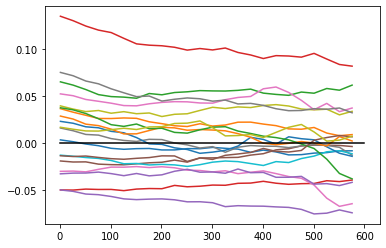

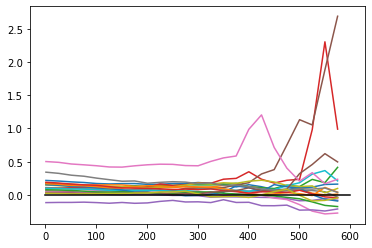

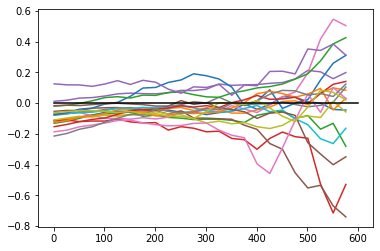

In [37]:
xvals = list(range(1,600,25))
for cRes in resByChromosome:
    plt.plot(xvals,(cRes[0]-truthValuesCO)/truthValuesCO)
plt.plot([0,600],[0,0],color = 'k')
plt.show()
for cRes,truth in list(zip(resByChromosome,truthValuesGC)):
    plt.plot(xvals,(cRes[1]-truth)/truth)
plt.plot([0,600],[0,0],color = 'k')

plt.show()
for cRes in resByChromosome:
    plt.plot(xvals,(cRes[2]-truthValueL)/truthValueL)
plt.plot([0,600],[0,0],color = 'k')
plt.show()